In [1]:
import os
import pickle

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sklearn.utils

from model import FiringRateModel, PolynomialActivation
from train import train_model
from data import load_data, preprocess_data, get_train_test_data
from evaluate import explained_variance_ratio

In [2]:
#device = torch.device("mps")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
def plot_predictions(model, Is, fs, evr=None, closed=True):    
    pred_fs = model.predict(Is, closed=closed, fs=fs)
    ts = np.arange(len(Is)) * bin_size / 1000
    k, l, m, n = model.k, model.l, model.m, model.n
    fig, axs = plt.subplots(2)
    if evr is not None:
        fig.suptitle(f"{'closed' if closed else 'open'} cell_id={cell_id}, bin_size={bin_size}, k_l_m_n={k}_{l}_{m}_{n}, evr={evr[0]:.3f}/{evr[1]:.3f}")
    else:
        fig.suptitle(f"{'closed' if closed else 'open'} cell_id={cell_id}, bin_size={bin_size}, k_l_m_n={k}_{l}_{m}_{n}")
        
    axs[0].plot(ts, fs, label="Actual")
    axs[0].plot(ts, pred_fs, label="Predicted")
    axs[1].plot(ts, Is)
    axs[0].legend()
    axs[0].set_ylabel("firing rate")
    axs[1].set_ylabel("current (pA)")
    axs[1].set_xlabel("time (s)")

def smooth(fs, n=5):
    k = torch.tensor([1,2,3,4,3,2,1.0])
    k = k / torch.sum(k)
    k = k.reshape(1, 1, -1)
    new_fs = []
    for f in fs:
        new_fs.append(F.conv1d(f.reshape(1, 1, -1), k, padding='same').reshape(-1))
    return new_fs
    
def train(cell_id, bin_size, k, l, m, n, loss_fn, save=True, a=None, b=None, c=None, d=None, static_g=True):
    Is_tr, fs_tr, Is_te, fs_te, ws = get_train_test_data(data, cell_id, bin_size, device=device)
    fs_tr = smooth(fs_tr)
    Is_tr, fs_tr, ws = sklearn.utils.shuffle(Is_tr, fs_tr, ws)
    
    actv = PolynomialActivation()
    actv.init_from_file(f"model/activation/{loss_fn}/bin_size_{bin_size}/{cell_id}_0.pickle")

    model = FiringRateModel(
        actv, k=k, l=l, m=m, n=n, static_g=static_g, bin_size=bin_size
    ).to(device)
    
    if loss_fn == "poisson":
        criterion = torch.nn.PoissonNLLLoss(log_input=False)
    elif loss_fn == "huber":
        criterion = torch.nn.HuberLoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.05, centered=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.85, step_size=5)
    
    # open loop
    losses = train_model(
        model, 
        criterion, 
        optimizer,
        Is_tr,
        fs_tr,
        epochs = 0,
        print_every = 1,
        loss_fn = loss_fn,
        bin_size = bin_size,
        up_factor = 15,
        ws = ws,
        closed = False,
        C = 0
    )
    
    #print(model.a.tolist(), model.b.tolist(), model.c.tolist(), model.d.tolist())
    
    '''
    print("open")
    for i in range(len(Is_tr)):
        plot_predictions(model, Is_tr[i], fs_tr[i], evr=None, closed=False)
        if save:
            plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}_{m}_{n}_{i}.png")
            plt.close()
    
    print("closed")
    for i in range(len(Is_tr)):
        plot_predictions(model, Is_tr[i], fs_tr[i], evr=None)
        if save:
            plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}_{m}_{n}_{i}.png")
            plt.close()
    '''
    
    # closed loop
    losses = train_model(
        model, 
        criterion, 
        optimizer,
        Is_tr,
        fs_tr,
        epochs = 50,
        print_every = 1,
        loss_fn = loss_fn,
        bin_size = bin_size,
        up_factor = 15,
        ws = ws,
        C = 0,
        scheduler = scheduler
    )
    
    '''
    print("open")
    for i in range(len(Is_tr)):
        plot_predictions(model, Is_tr[i], fs_tr[i], evr=None, closed=False)
        if save:
            plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}_{m}_{n}_{i}.png")
            plt.close()
    '''
    
    for i in range(len(Is_tr)):
        plot_predictions(model, Is_tr[i], fs_tr[i], evr=None)
        if save:
            plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}_{m}_{n}_{i}.png")
            plt.close()
                
    if save:
        plt.plot(list(range(len(losses))), losses)
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/loss/{k}_{l}_{m}_{n}.png")
        plt.close()
    
    r = explained_variance_ratio(model, Is_te, fs_te, bin_size)
    rq = explained_variance_ratio(model, Is_te, fs_te, bin_size, quantize=True)
    plot_predictions(model, Is_te[0], fs_te[0], evr=(r, rq))
    if save:
        plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}_{m}_{n}_noise2.png")
        plt.close()
    return model

In [76]:
data = load_data(with_zero=True)
data.keys()

dict_keys([583836069, 565871768, 605889373, 513593674, 504615116])

In [77]:
for cell_id in data:
    print(cell_id)
    counts = {}
    for sweep in data[cell_id][:-1]:
        stim_name = sweep["stimulus_name"]
        if stim_name not in counts:
            counts[stim_name] = 0
        counts[stim_name] += 1
    print(counts)

583836069
{'Short Square': 9, 'Long Square': 22, 'Ramp': 2, 'Noise 1': 3, 'Noise 2': 4, 'Square - 0.5ms Subthreshold': 10, 'Test': 1}
565871768
{'Short Square': 13, 'Long Square': 36, 'Ramp': 1, 'Noise 2': 4, 'Noise 1': 2, 'Square - 0.5ms Subthreshold': 10, 'Square - 2s Suprathreshold': 12, 'Test': 1}
605889373
{'Short Square': 17, 'Long Square': 37, 'Ramp': 3, 'Noise 1': 3, 'Noise 2': 3, 'Square - 0.5ms Subthreshold': 10, 'Test': 1}
513593674
{'Short Square': 29, 'Long Square': 25, 'Square - 2s Suprathreshold': 13, 'Ramp to Rheobase': 3, 'Short Square - Hold -70mV': 14, 'Test': 1, 'Ramp': 3, 'Noise 1': 4, 'Noise 2': 4, 'Square - 0.5ms Subthreshold': 2, 'Short Square - Triple': 21}
504615116
{'Short Square': 26, 'Square - 2s Suprathreshold': 6, 'Ramp to Rheobase': 1, 'Test': 1, 'Long Square': 24, 'Ramp': 3, 'Noise 1': 4, 'Noise 2': 3, 'Square - 0.5ms Subthreshold': 2, 'Short Square - Triple': 13}


In [78]:
try:
    with open("model/params.pickle", "rb") as file:
        params = pickle.load(file)
except:
    print("No pre-existing params to load. New file created.")
    params = {}

cell_id=513593674, bin_size=20, k=2, l=2, m=0, n=0
Epoch 1 / Loss: 5191.33950445279 / lr: [0.05]
Epoch 2 / Loss: 3875.386364220084 / lr: [0.05]
Epoch 3 / Loss: 3140.063921664923 / lr: [0.05]
Epoch 4 / Loss: 3389.144700199517 / lr: [0.05]
Epoch 5 / Loss: 4399.516145947979 / lr: [0.0425]
Epoch 6 / Loss: 4365.027925887153 / lr: [0.0425]
Epoch 7 / Loss: 4306.721655611657 / lr: [0.0425]
Epoch 8 / Loss: 3165.0879113892556 / lr: [0.0425]
Epoch 9 / Loss: 3278.5711906693364 / lr: [0.0425]
Epoch 10 / Loss: 3320.8945537084614 / lr: [0.036125000000000004]
Epoch 11 / Loss: 3100.76407247641 / lr: [0.036125000000000004]
Epoch 12 / Loss: 3443.925152922137 / lr: [0.036125000000000004]
Epoch 13 / Loss: 3964.9945394701285 / lr: [0.036125000000000004]
Epoch 14 / Loss: 3757.0591919537846 / lr: [0.036125000000000004]
Epoch 15 / Loss: 3686.282269419892 / lr: [0.030706250000000004]
Epoch 16 / Loss: 3460.5806189299033 / lr: [0.030706250000000004]
Epoch 17 / Loss: 3323.5818652921375 / lr: [0.030706250000000004]

/var/folders/1d/cmypn_251jlfyvc132scjqd40000gp/T/ipykernel_48116/2483228628.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2)


[0.1853727102279663, -0.23888233304023743] [-0.604421079158783, -1.5982969999313354] [] []


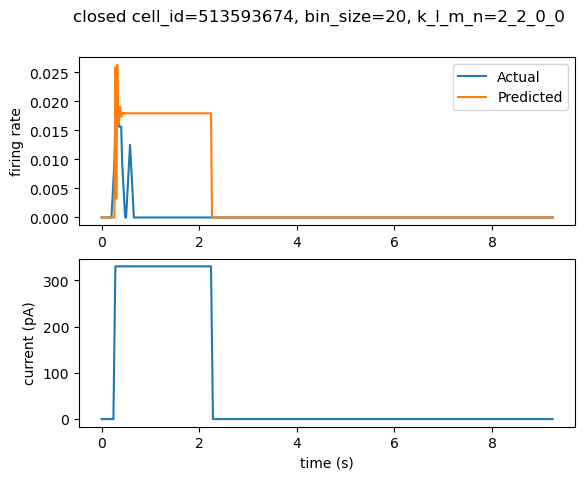

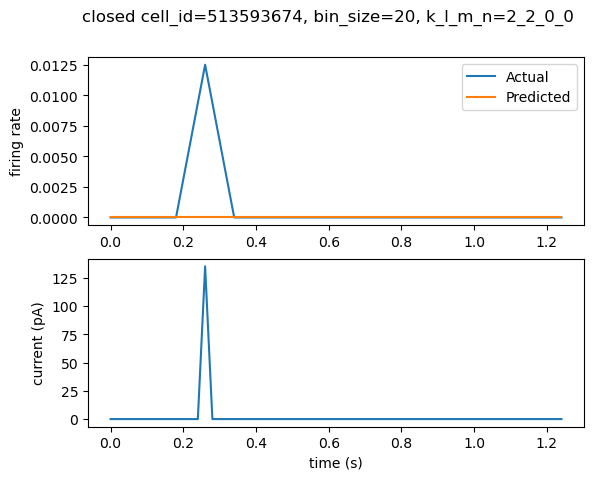

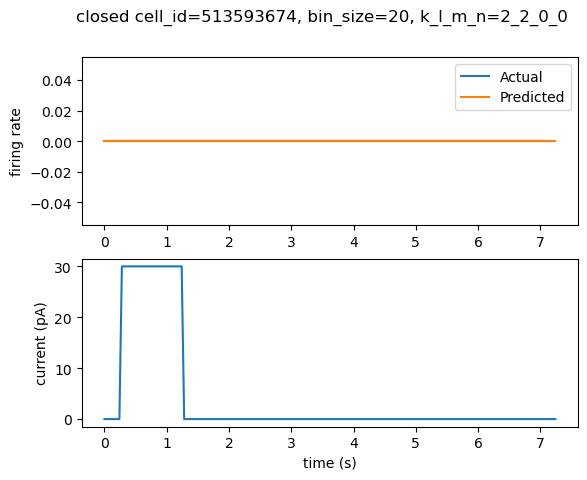

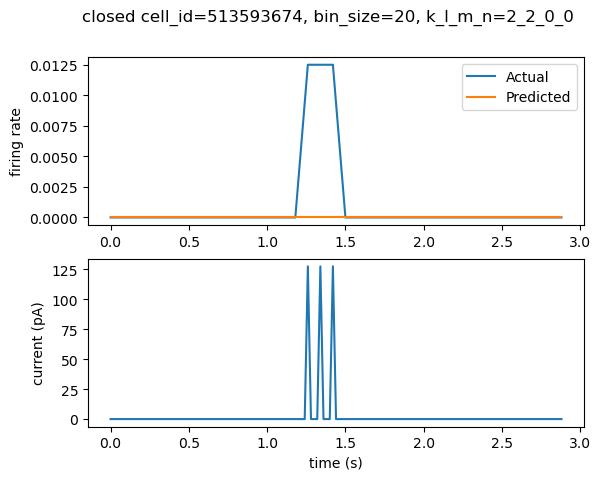

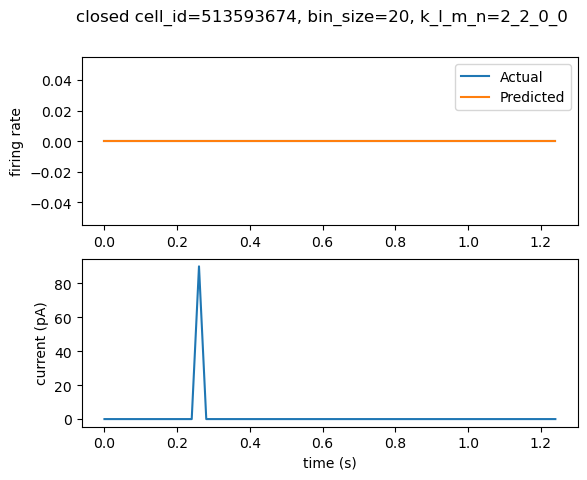

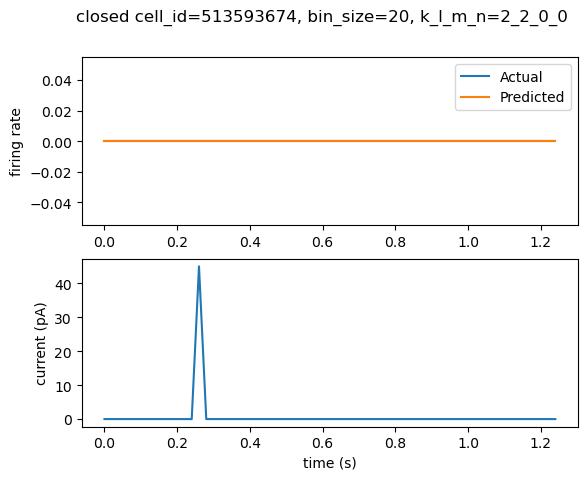

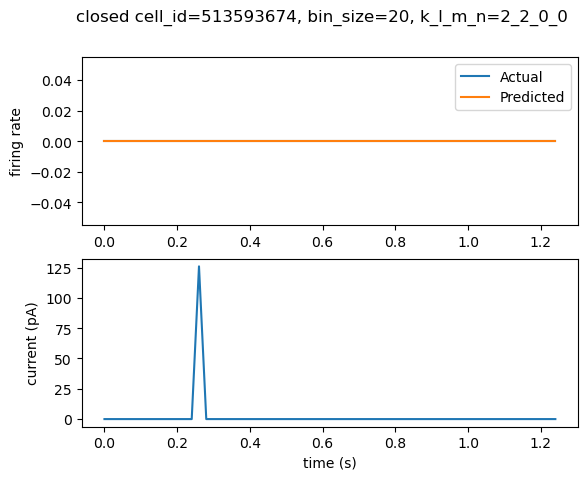

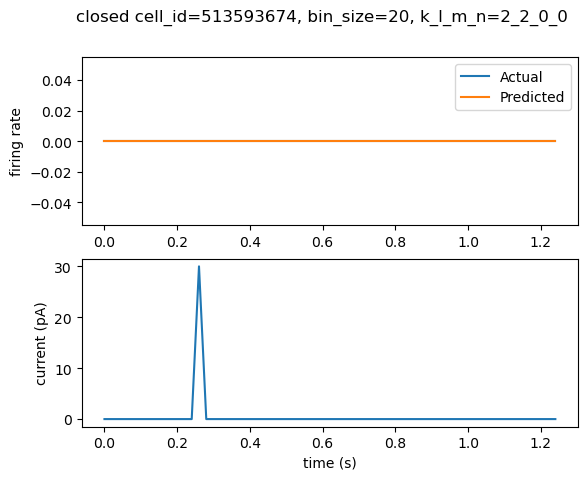

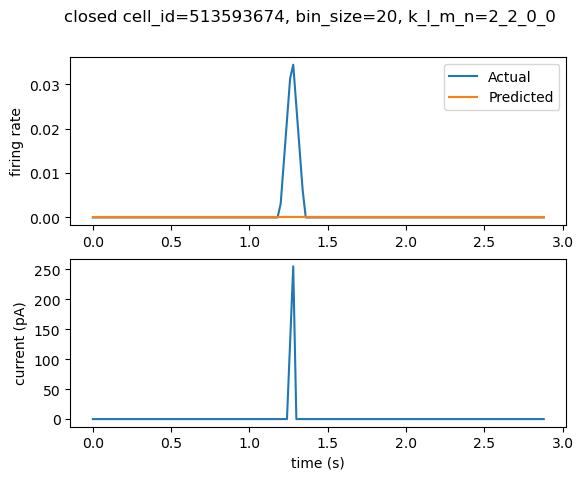

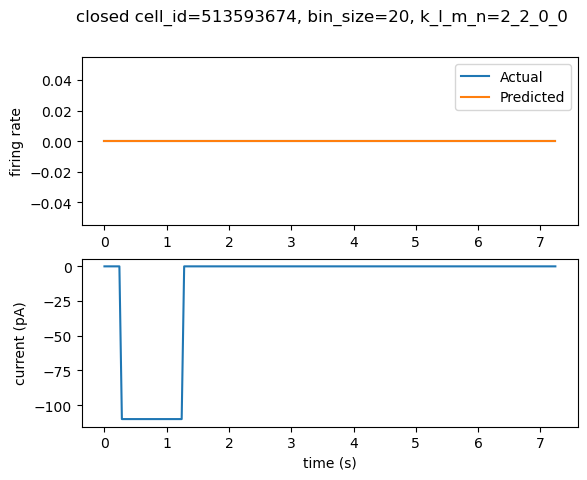

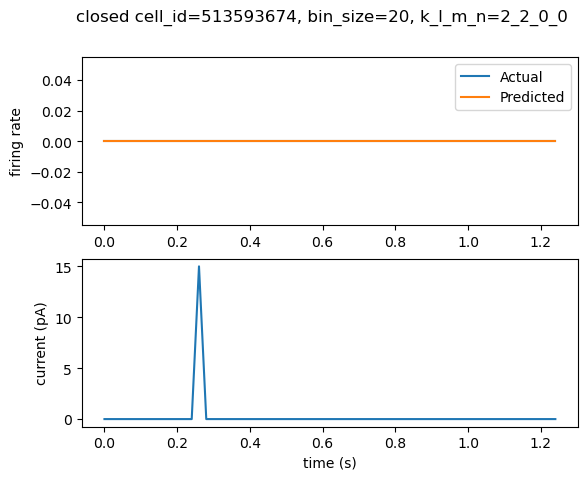

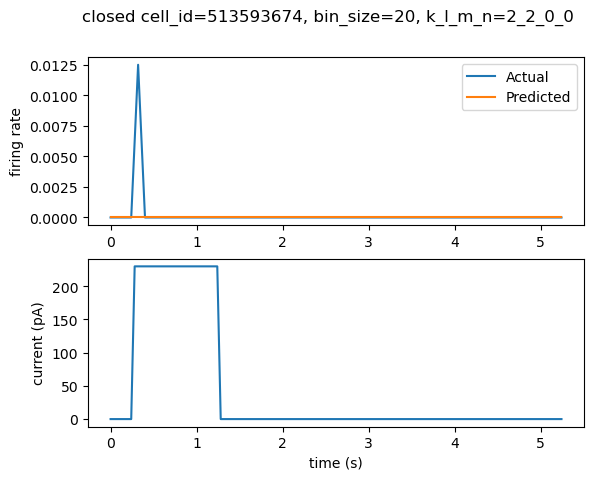

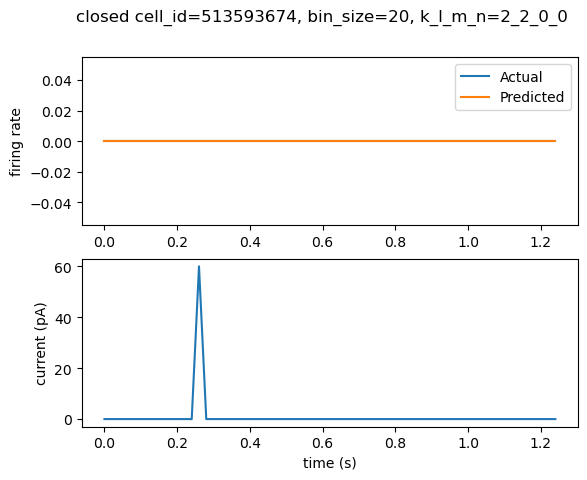

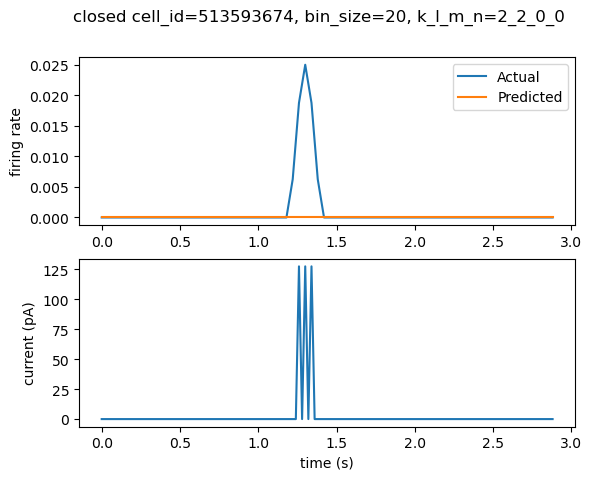

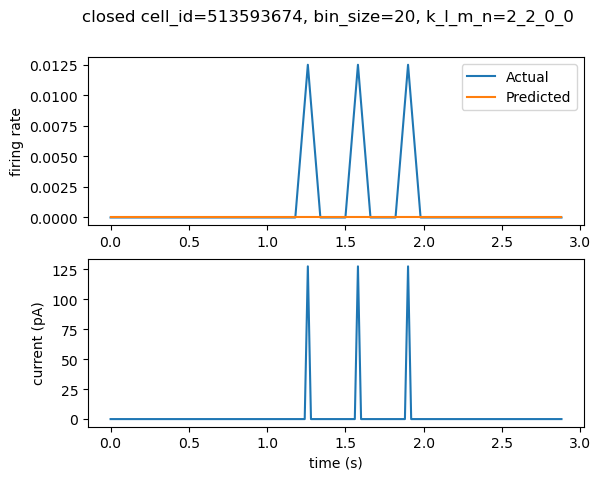

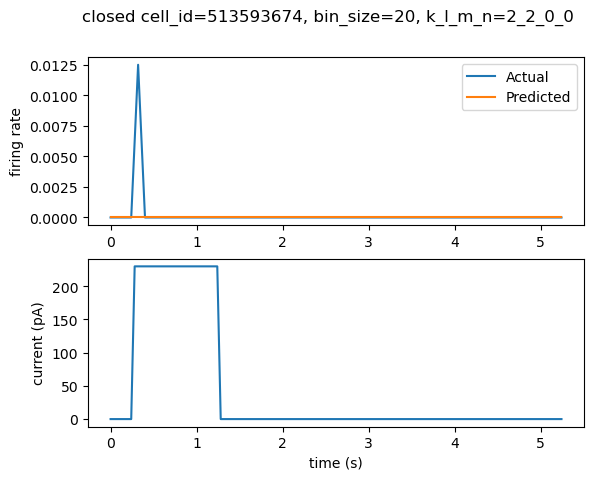

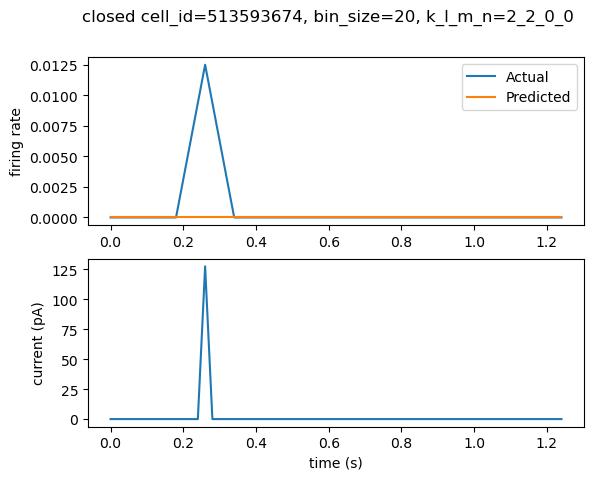

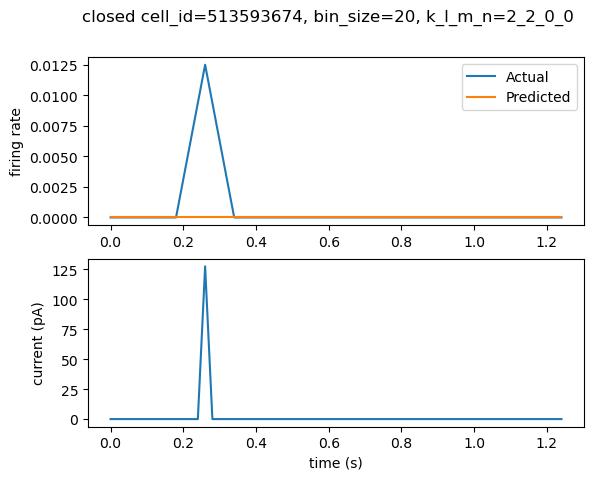

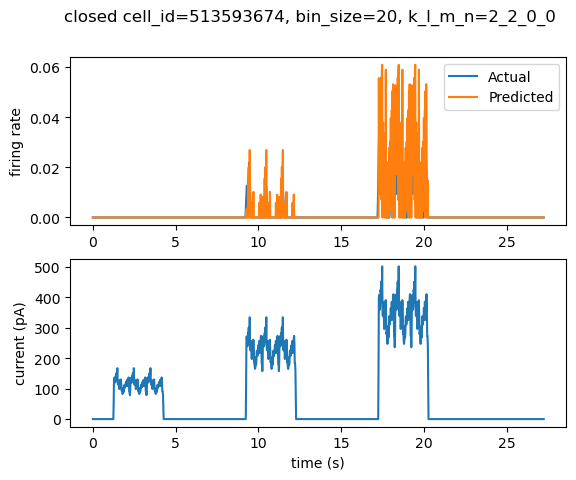

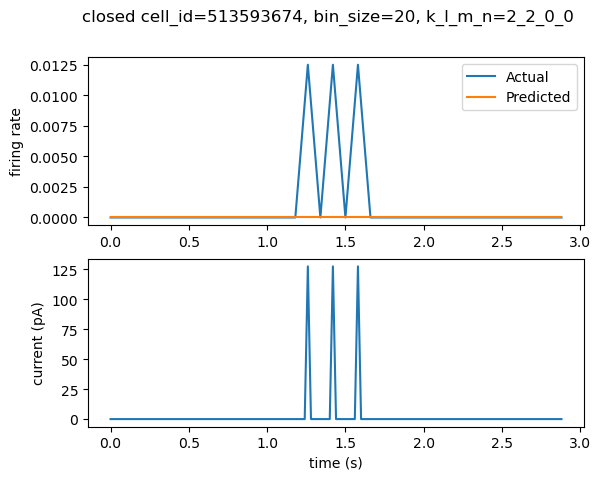

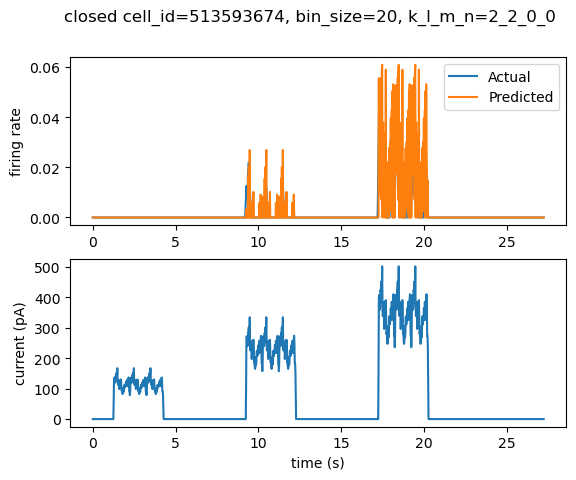

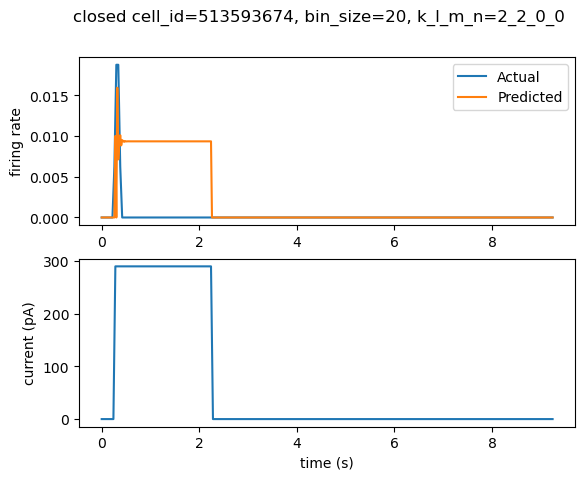

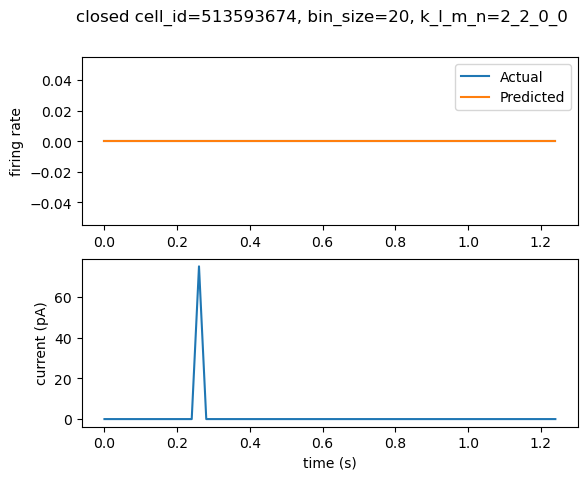

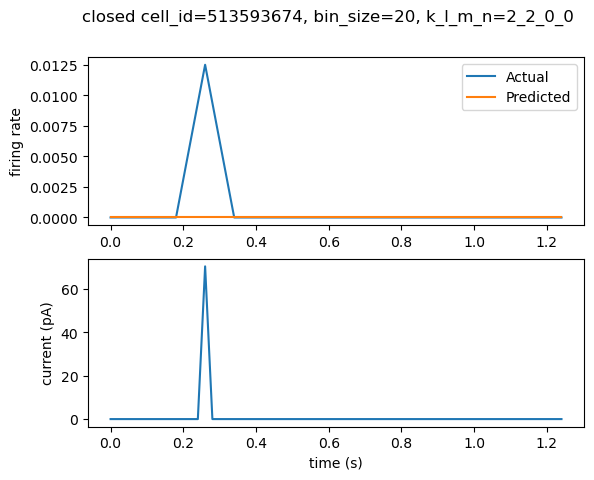

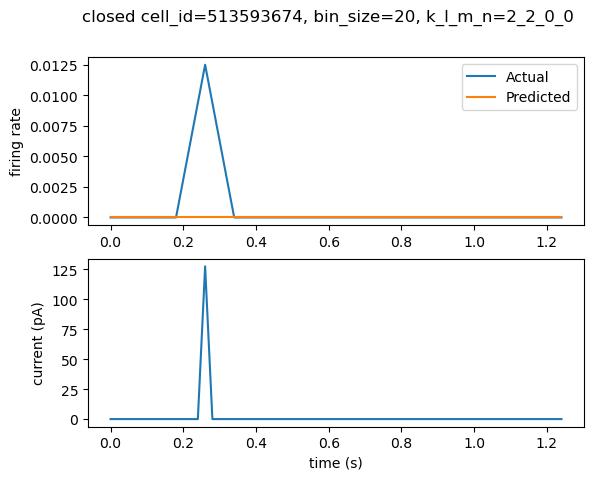

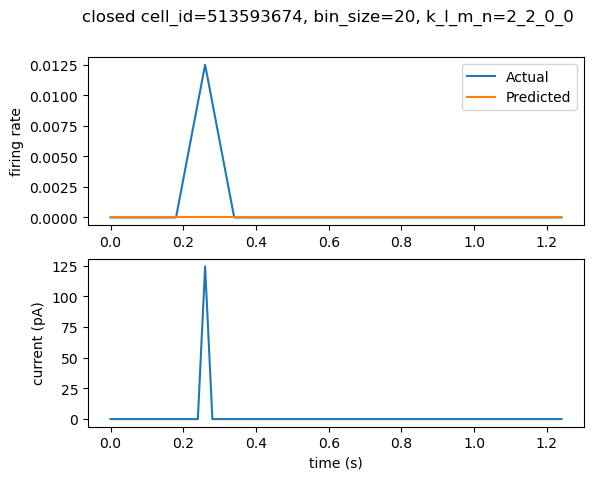

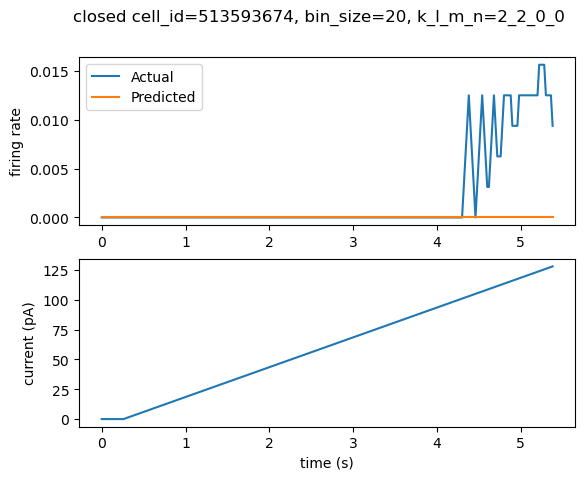

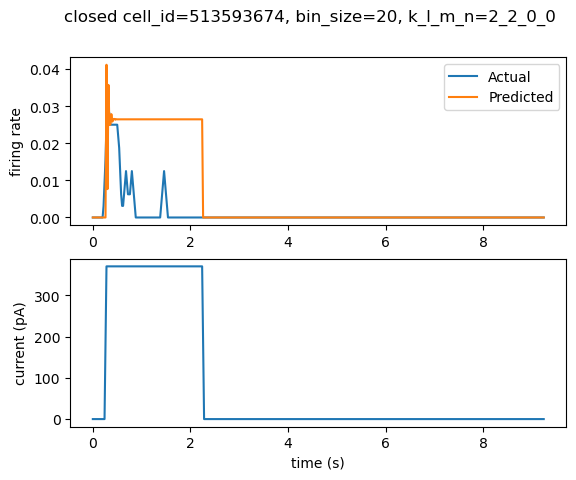

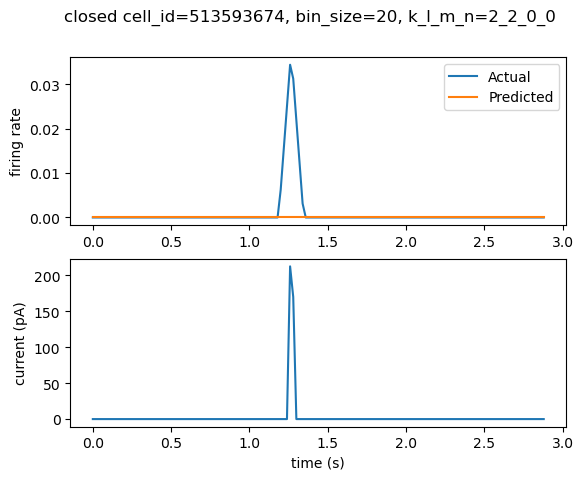

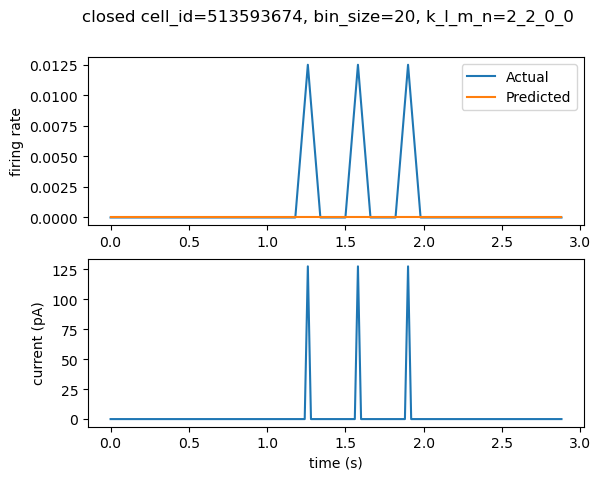

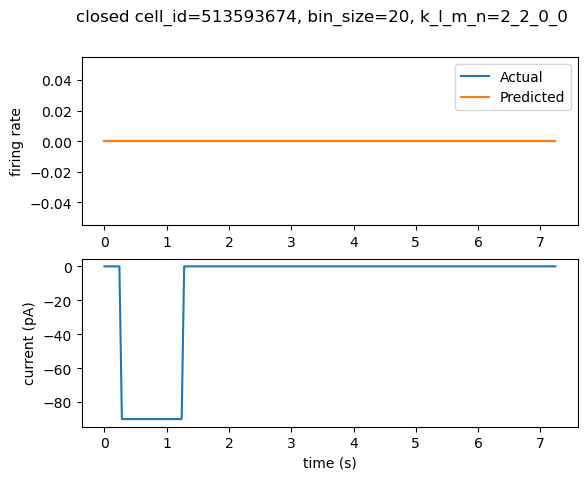

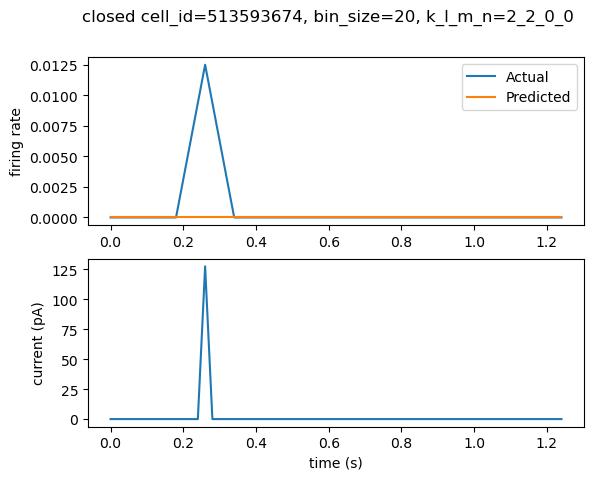

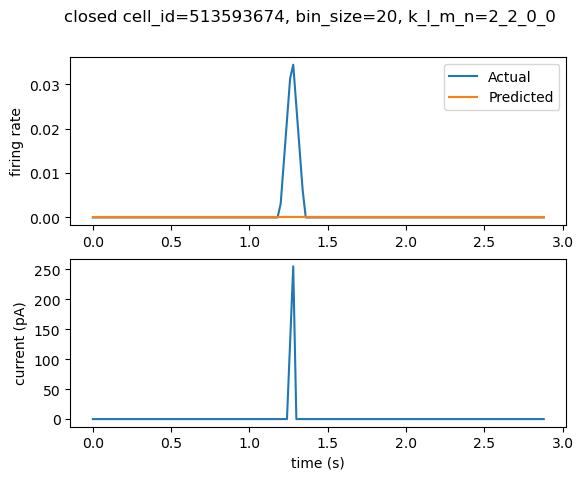

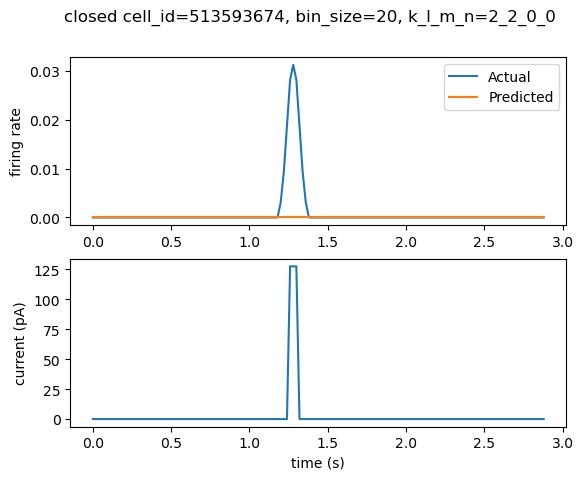

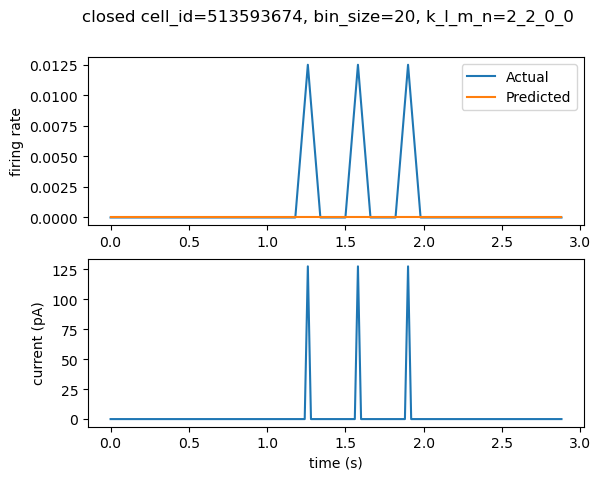

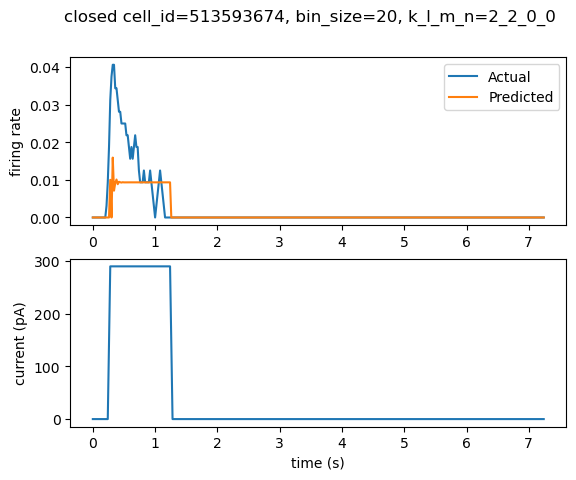

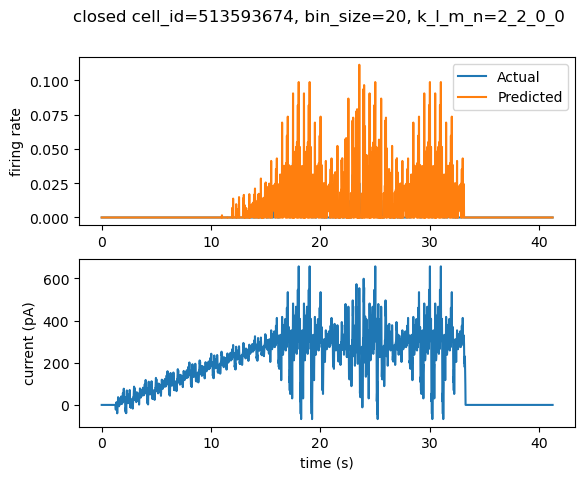

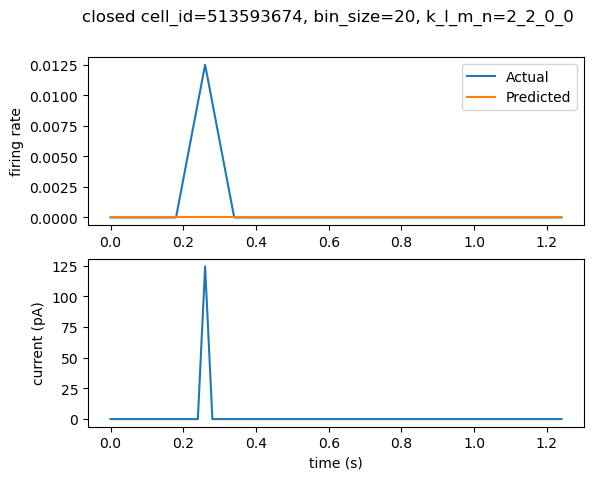

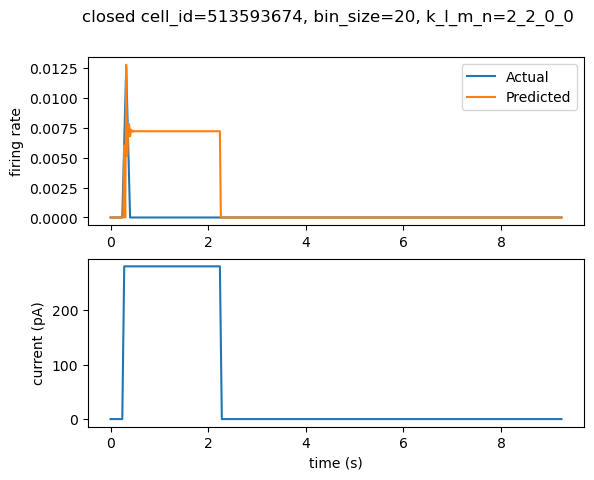

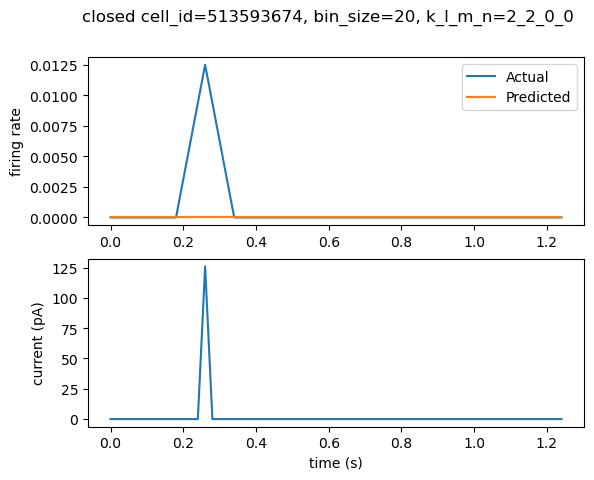

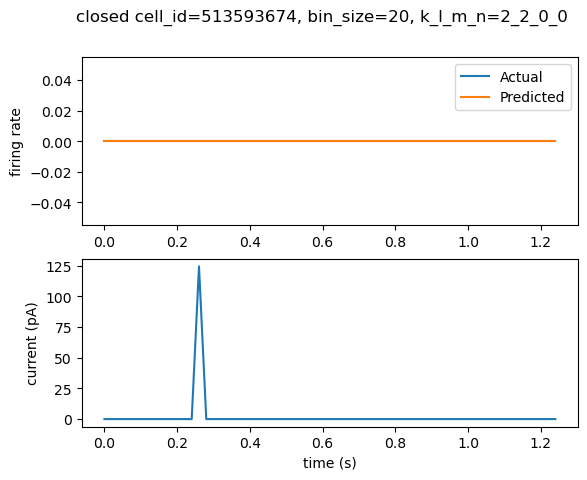

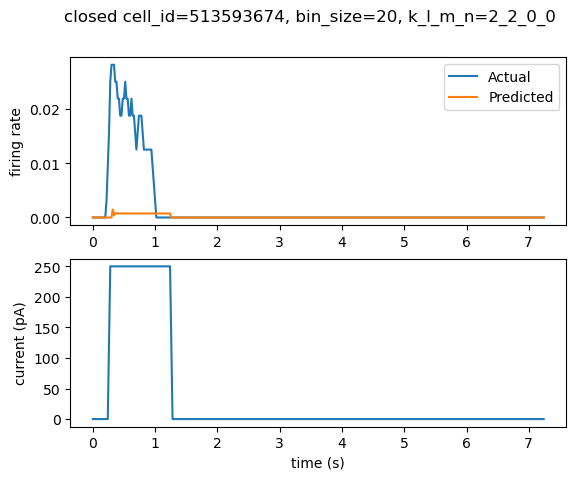

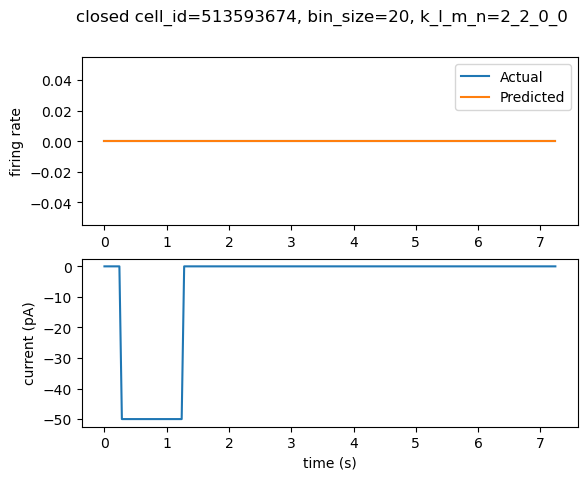

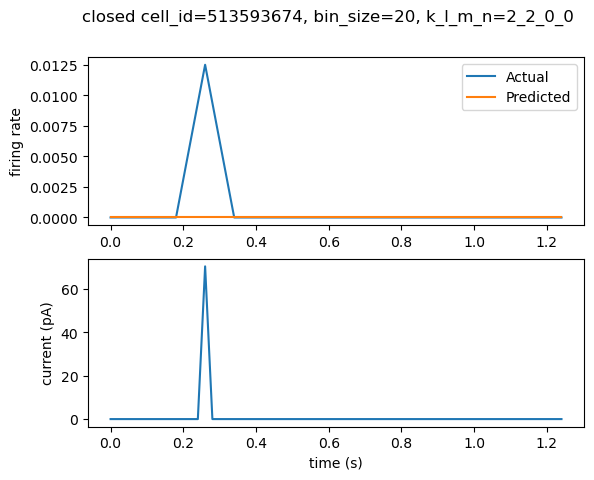

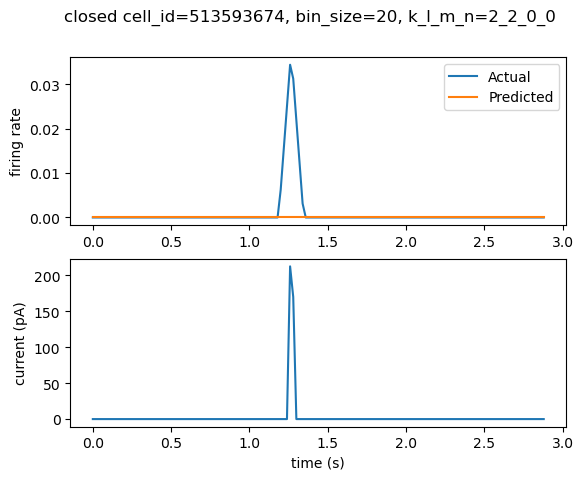

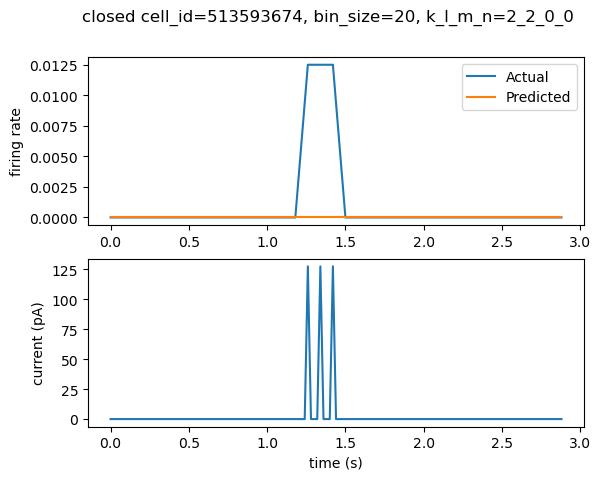

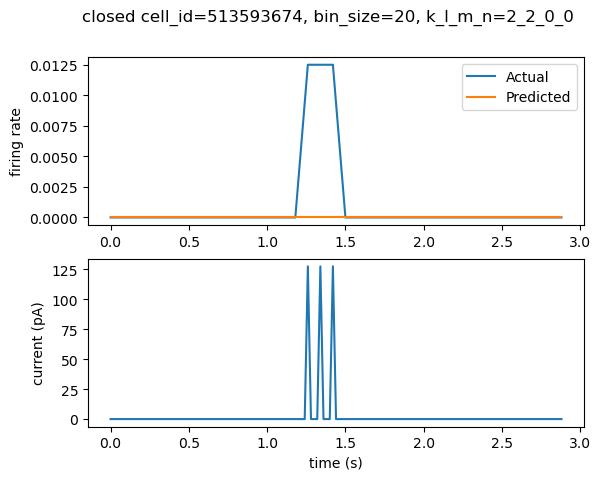

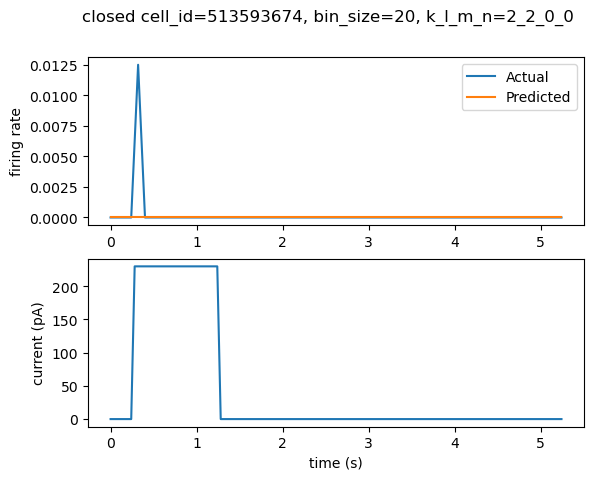

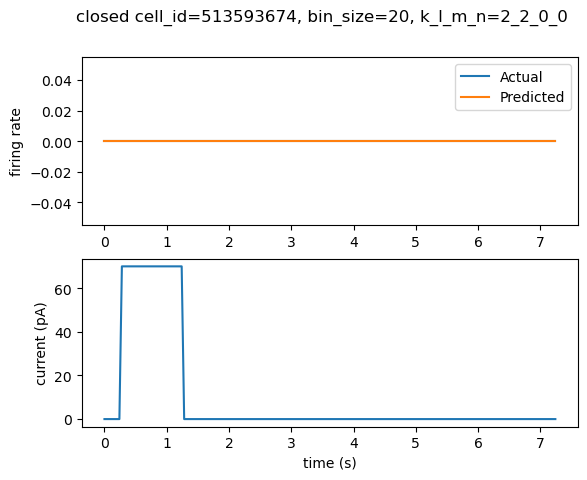

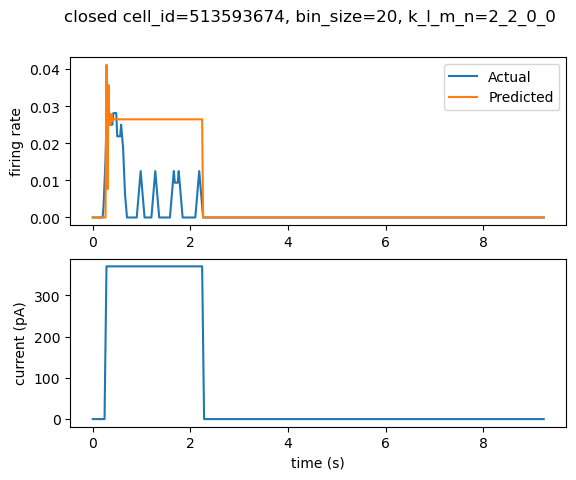

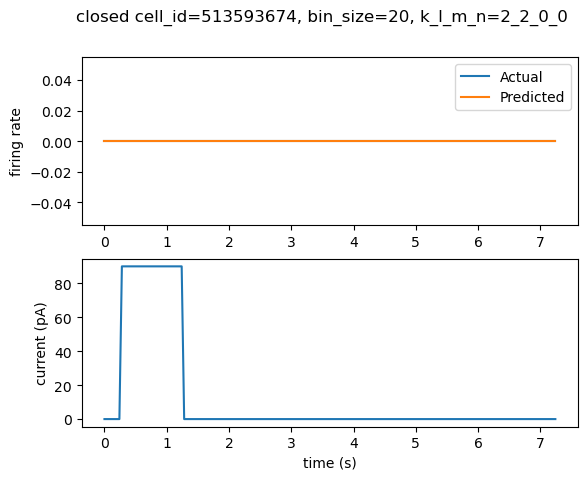

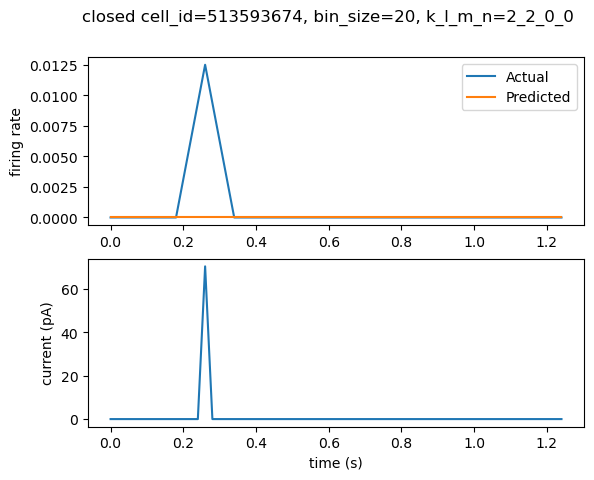

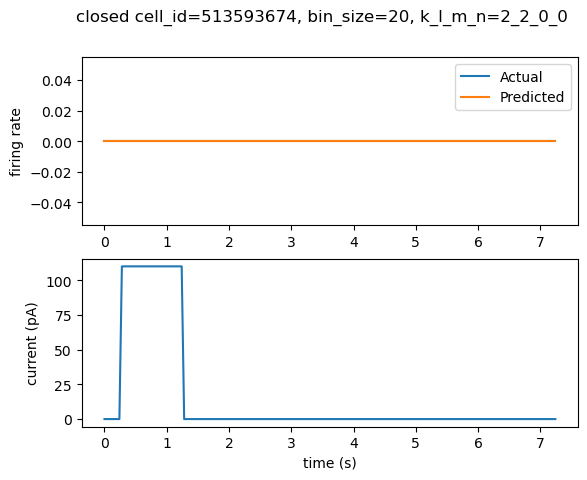

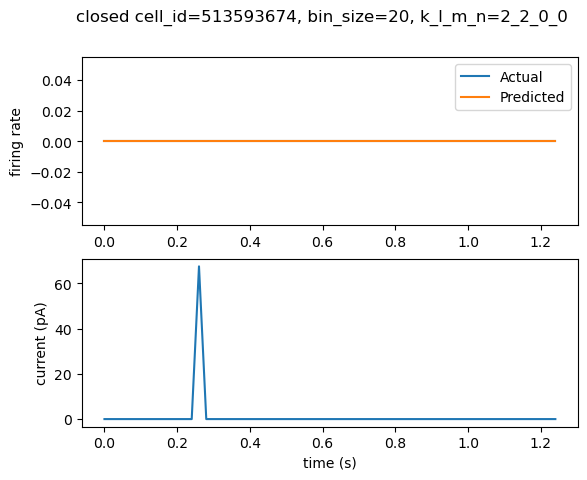

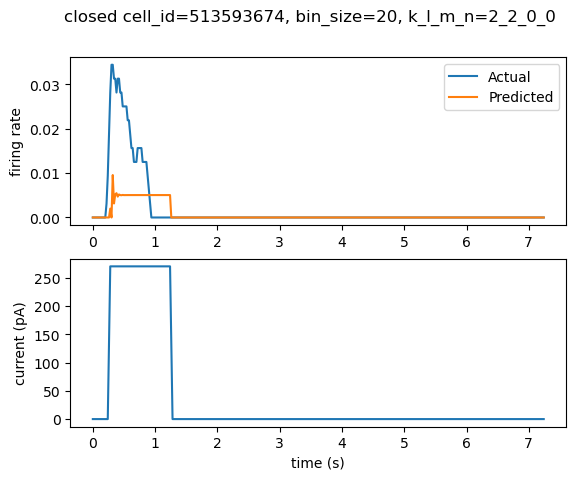

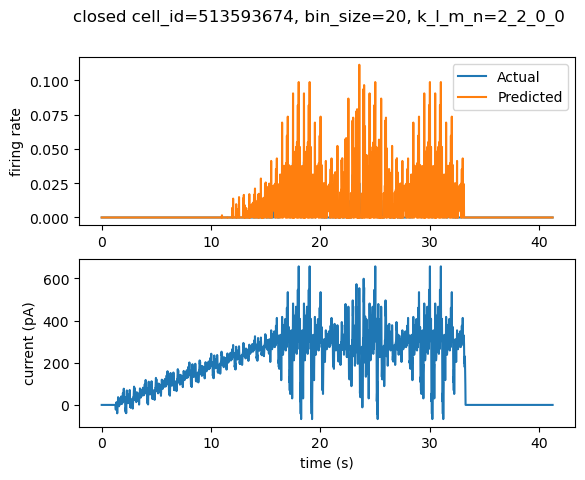

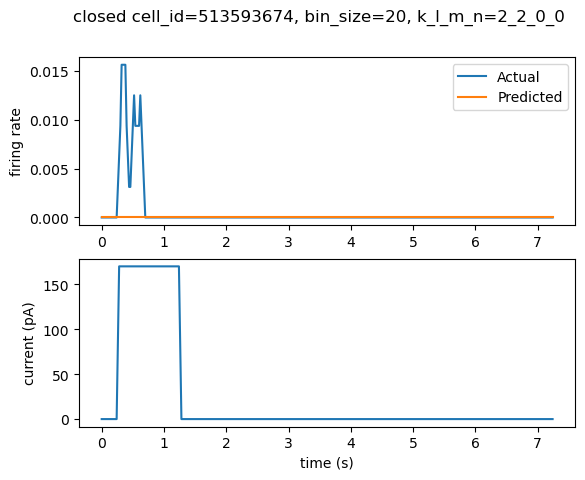

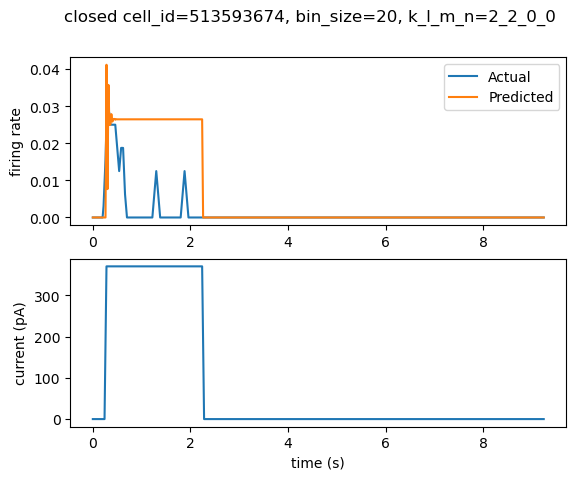

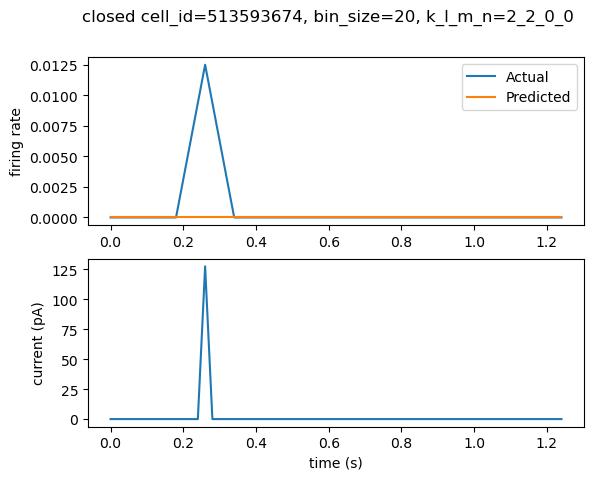

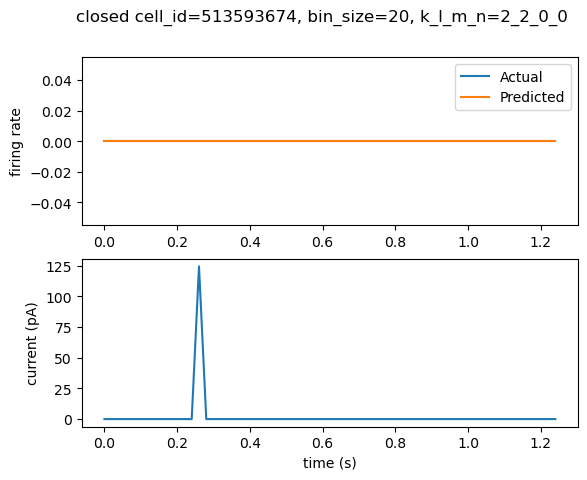

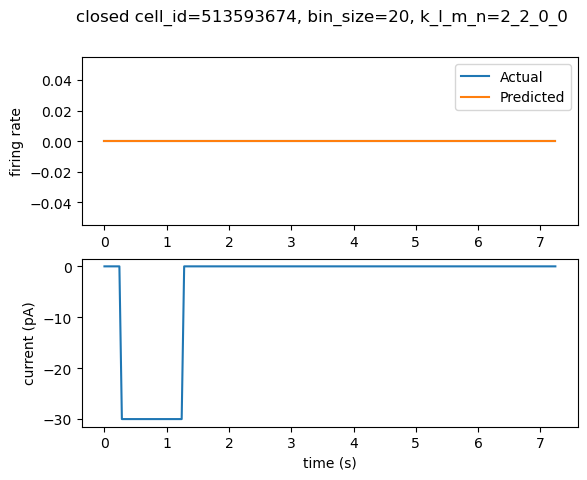

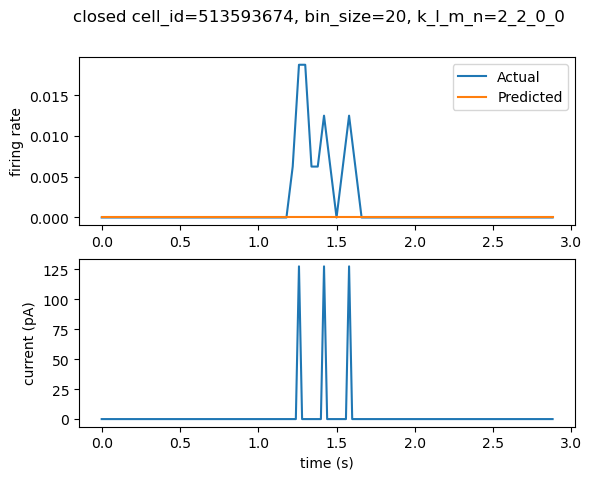

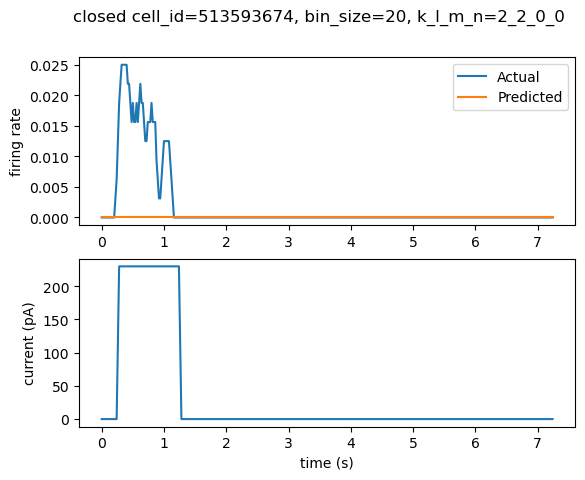

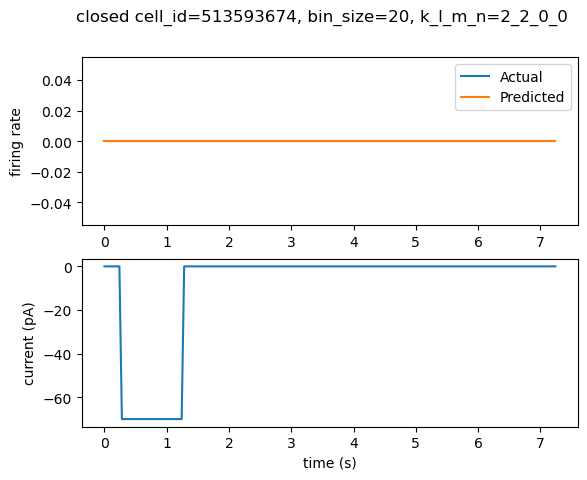

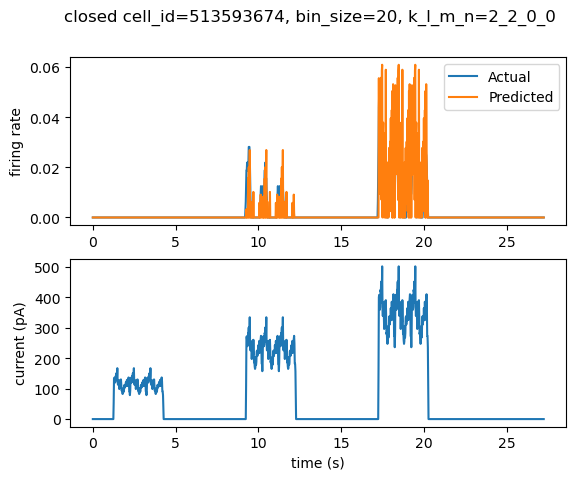

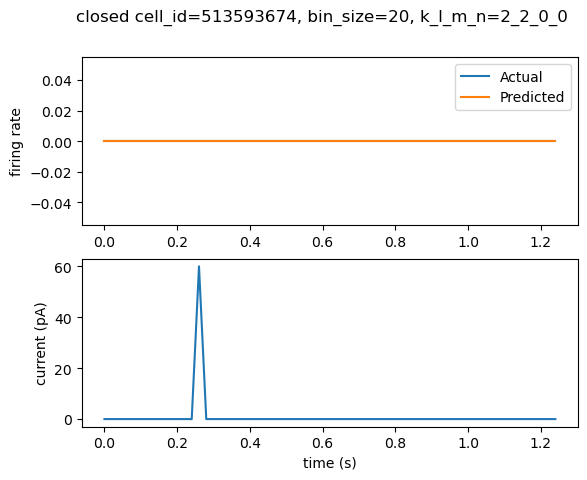

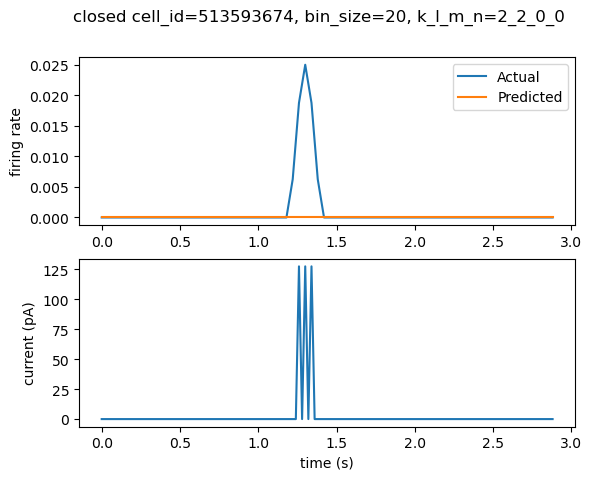

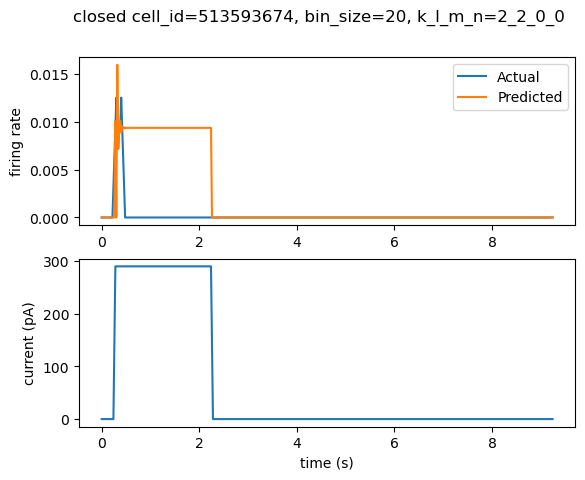

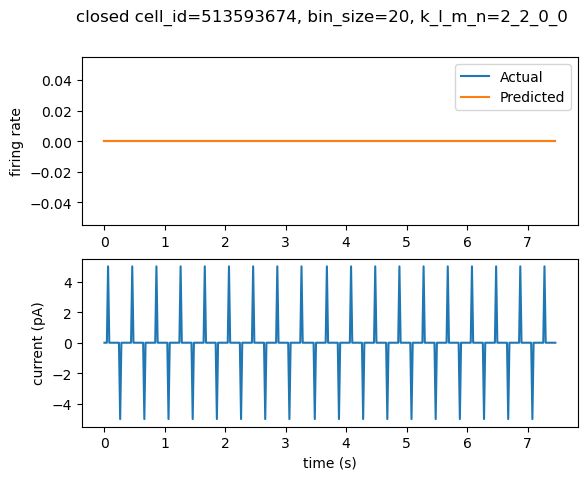

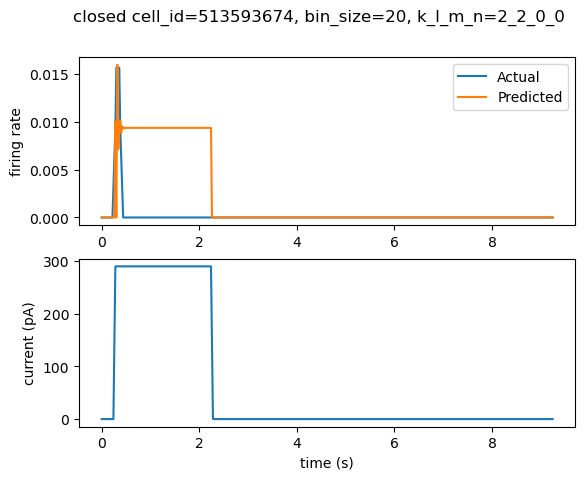

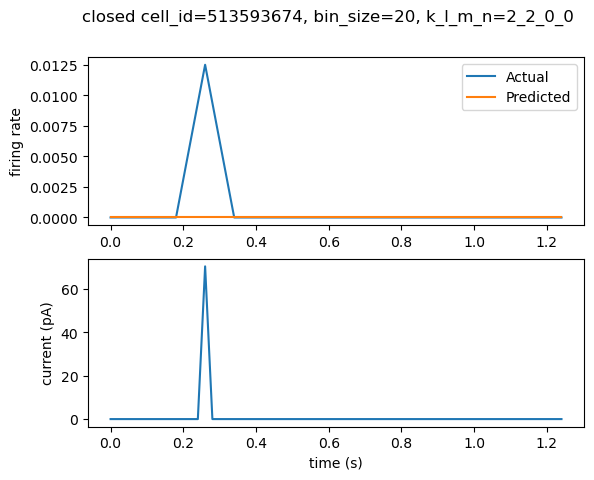

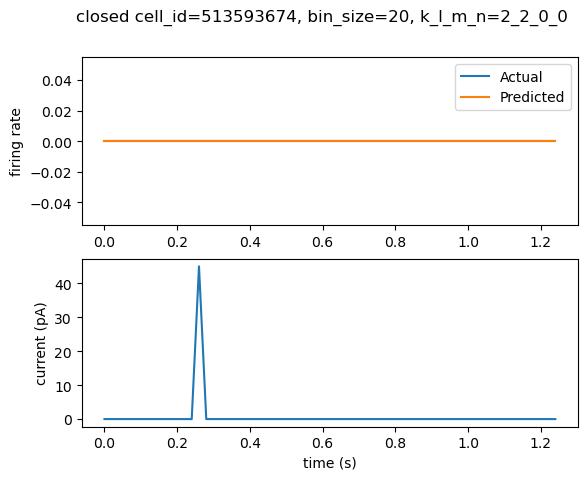

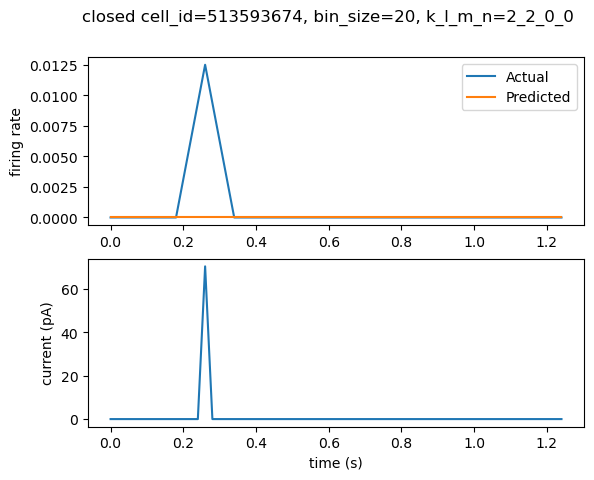

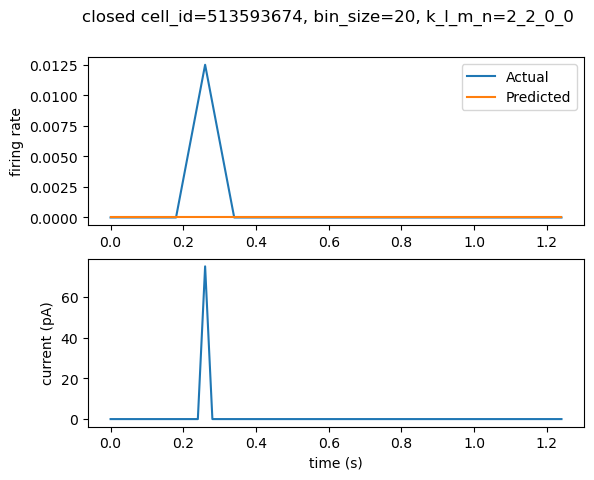

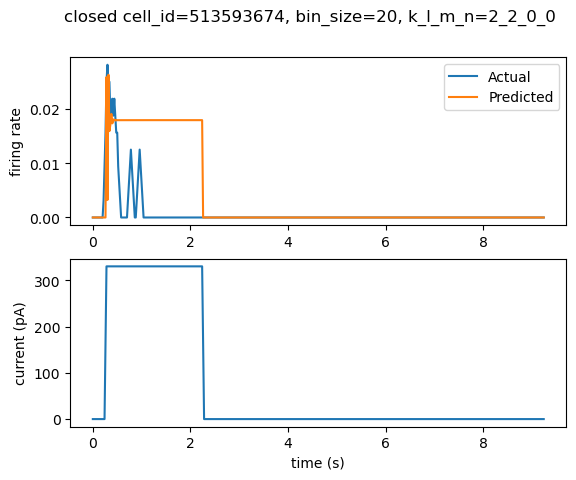

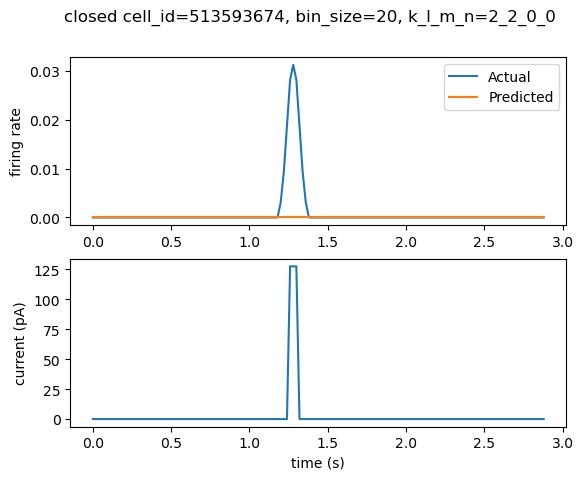

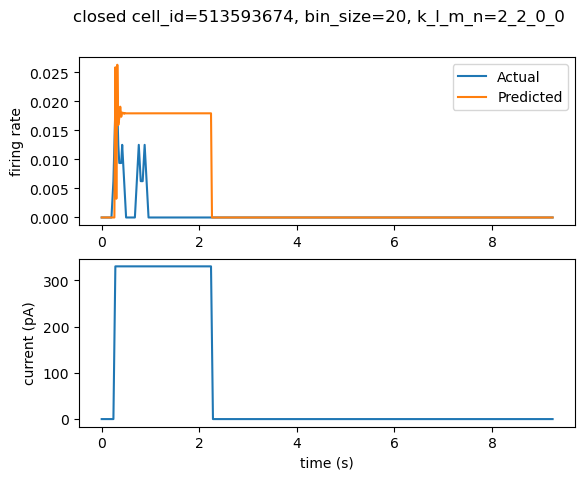

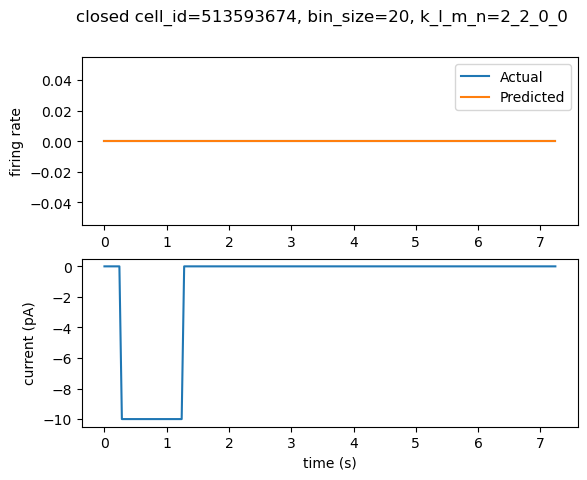

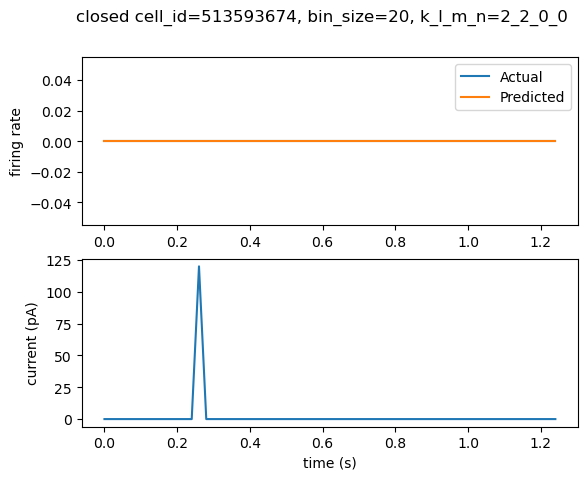

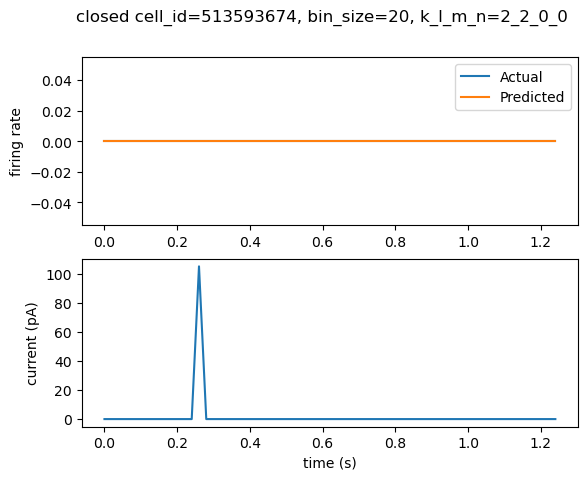

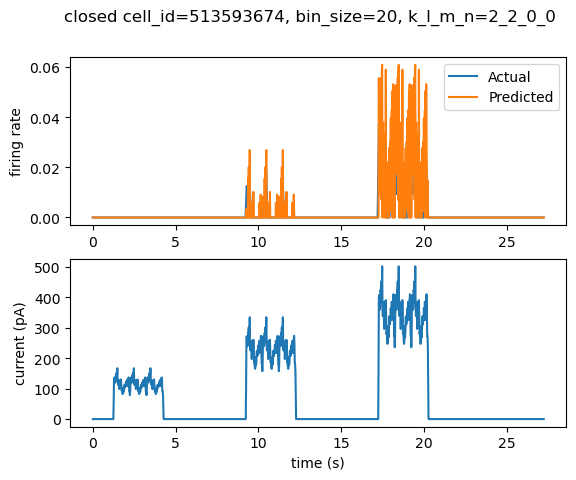

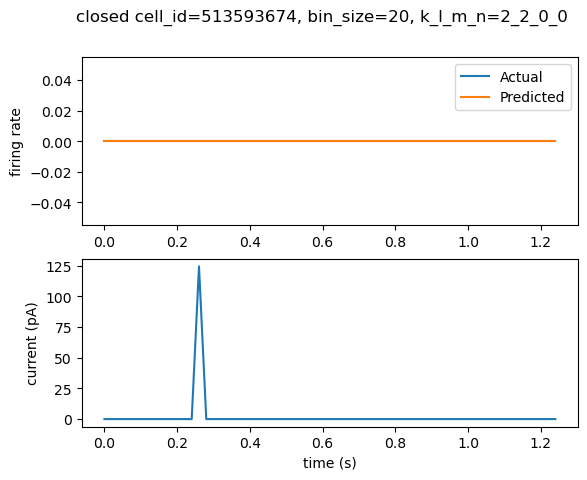

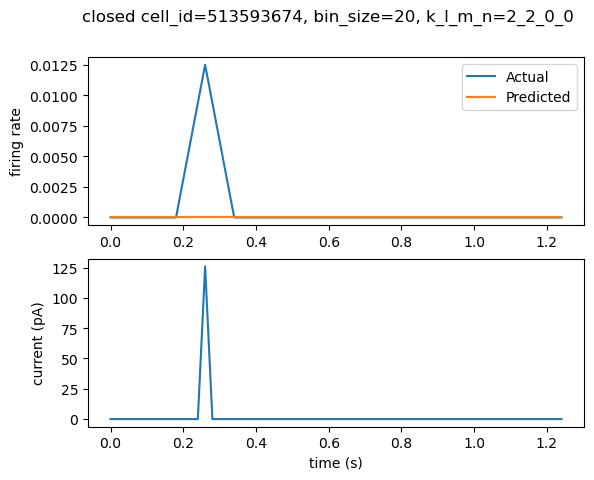

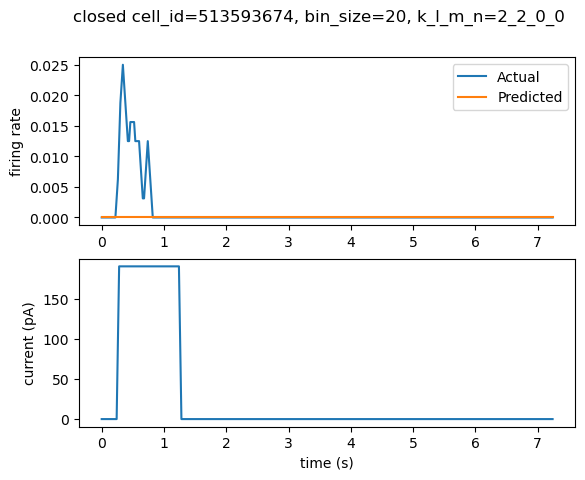

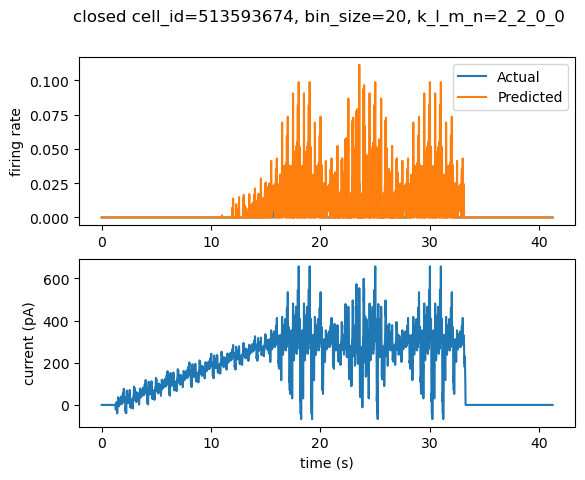

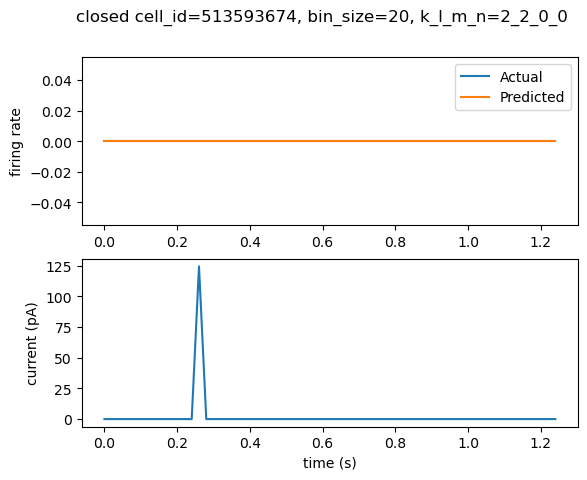

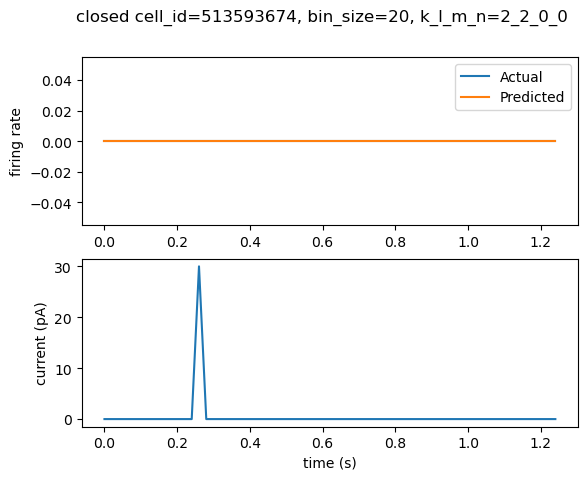

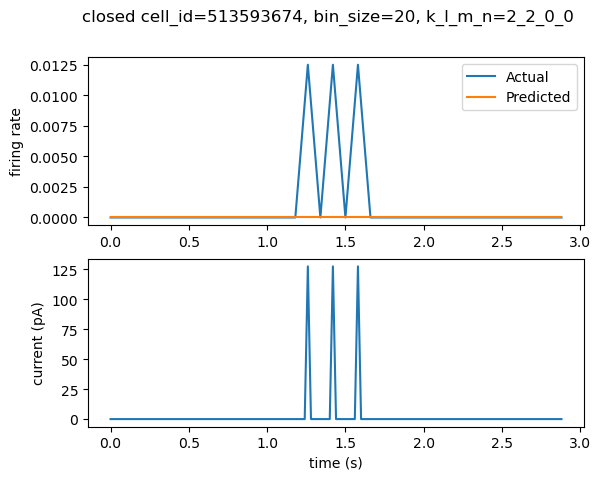

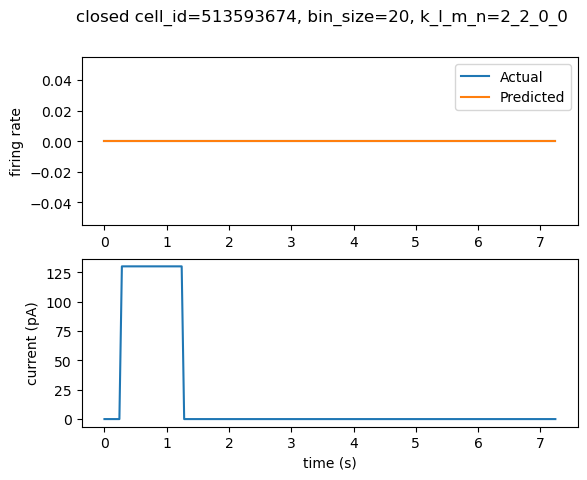

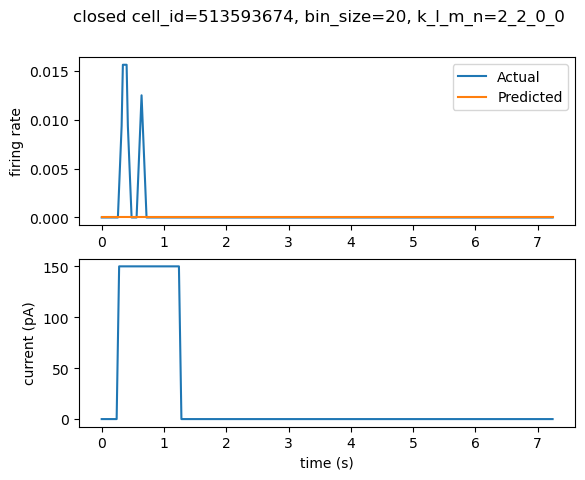

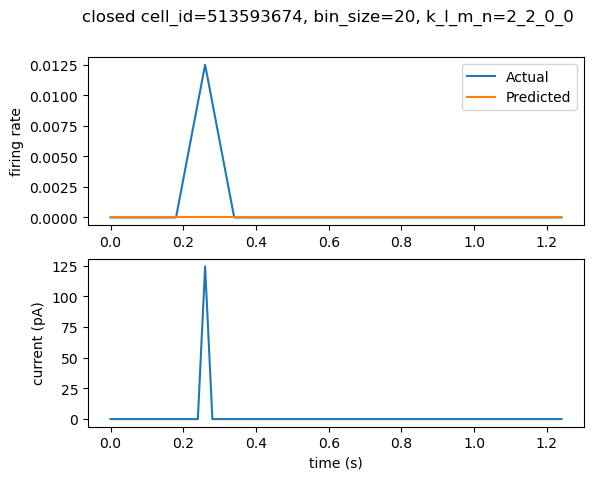

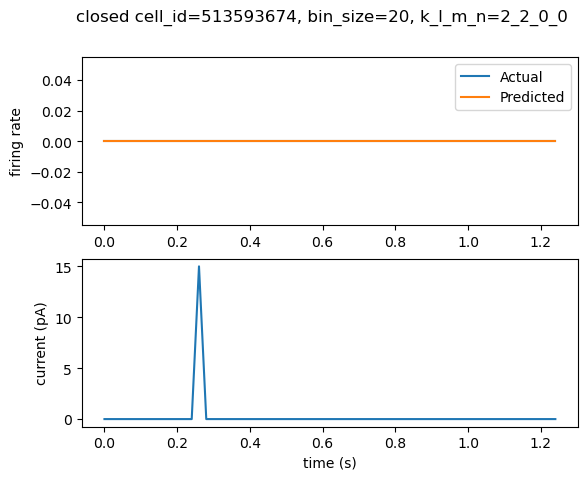

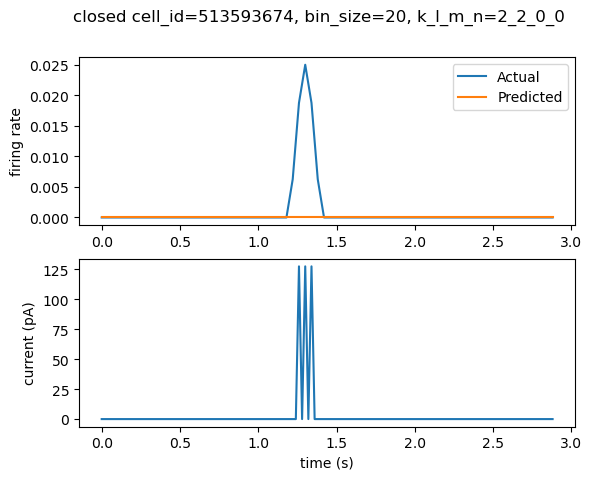

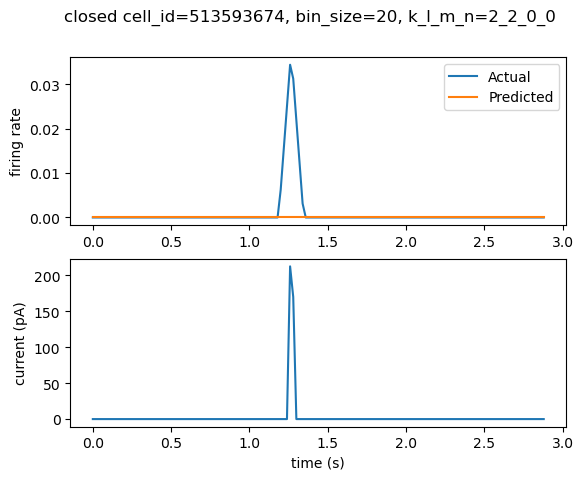

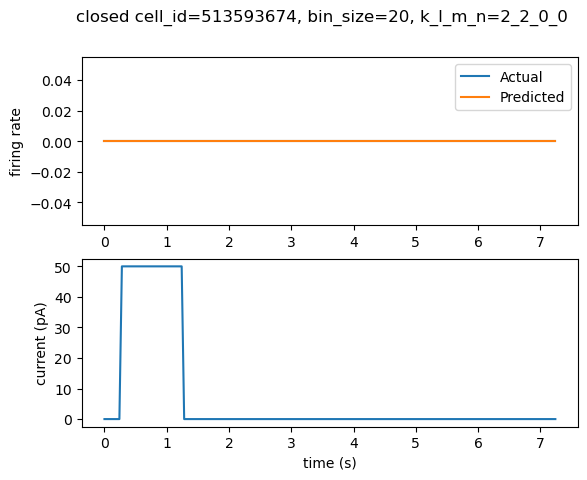

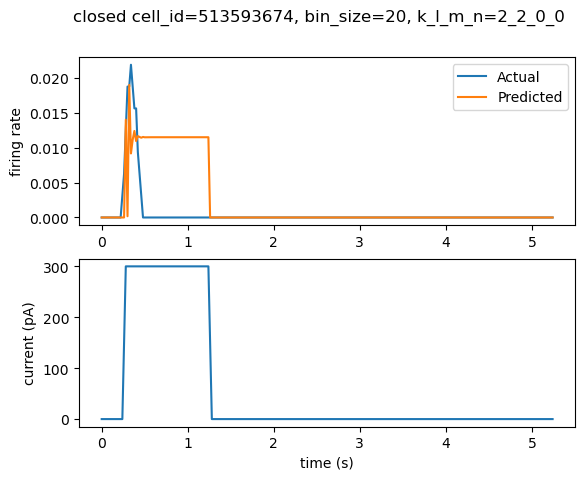

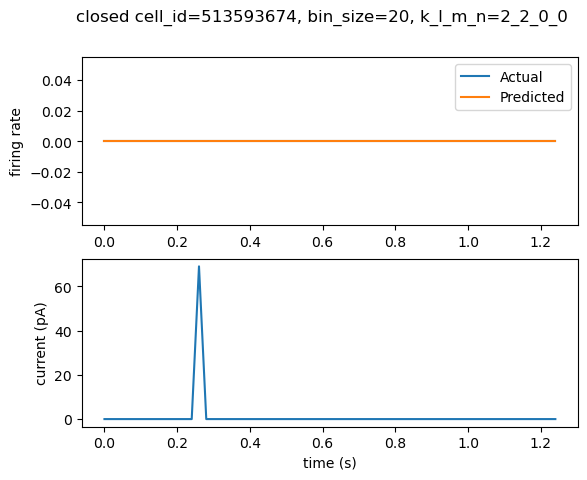

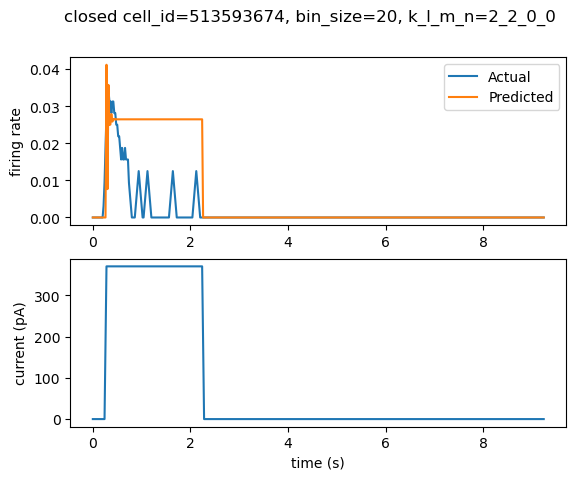

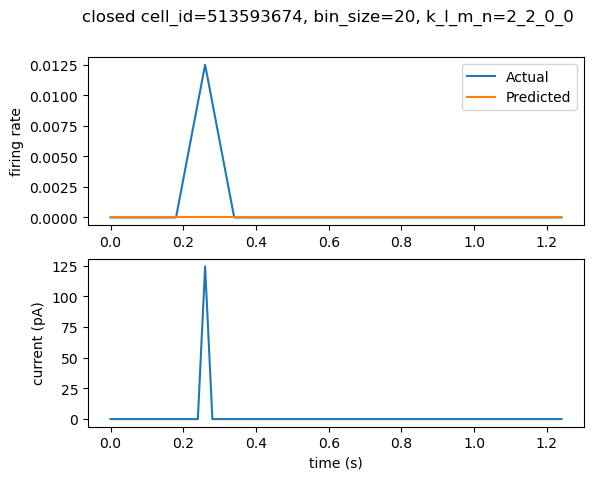

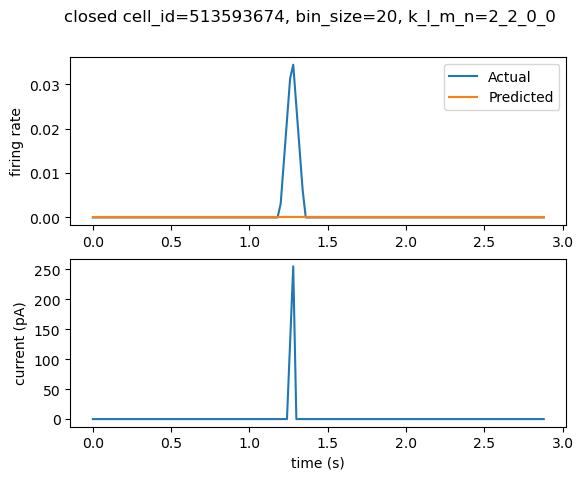

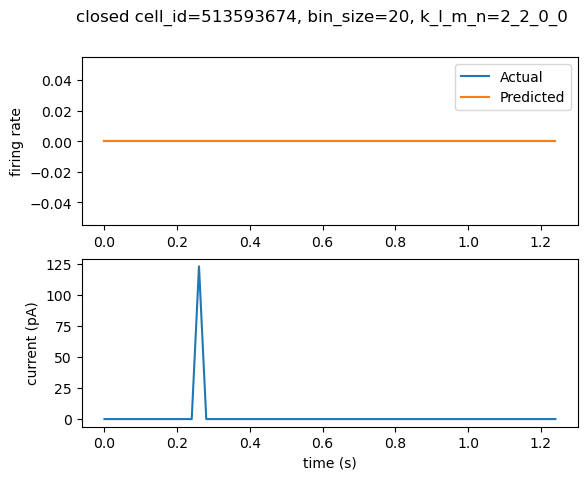

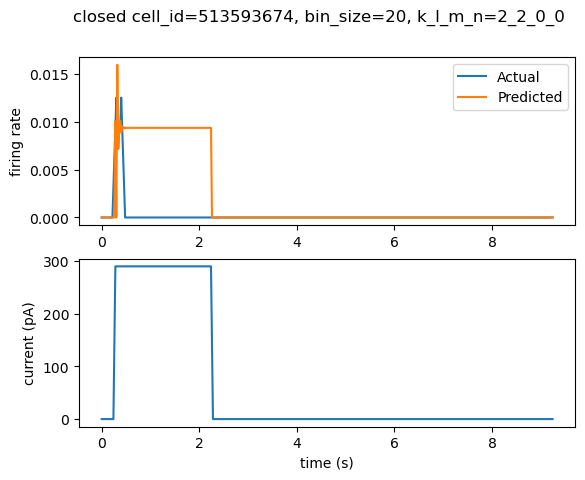

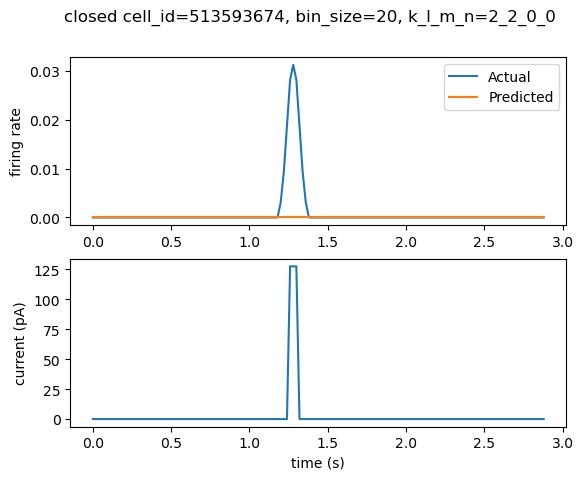

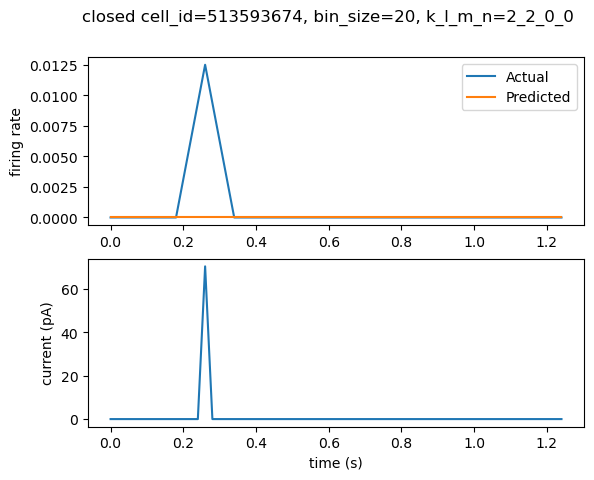

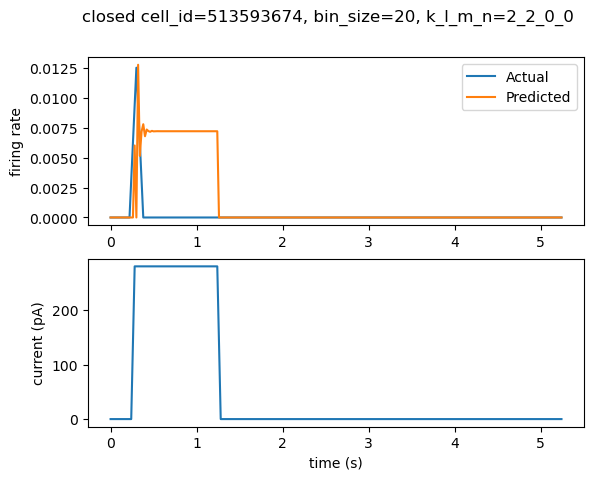

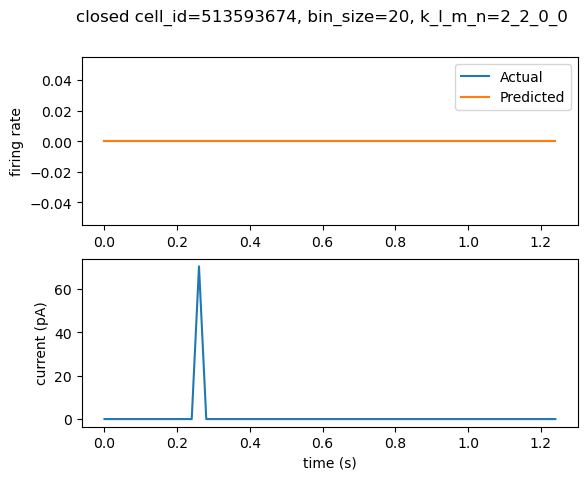

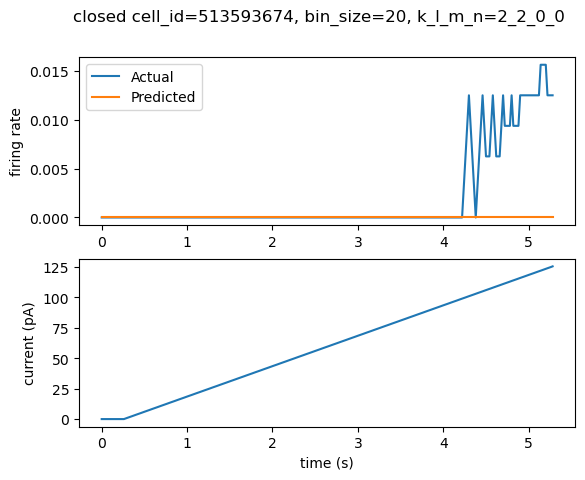

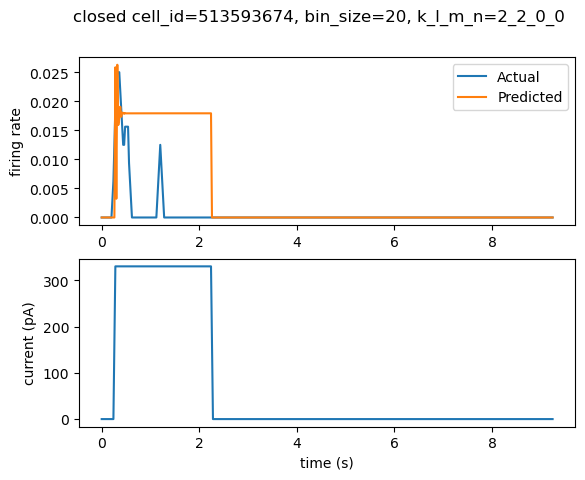

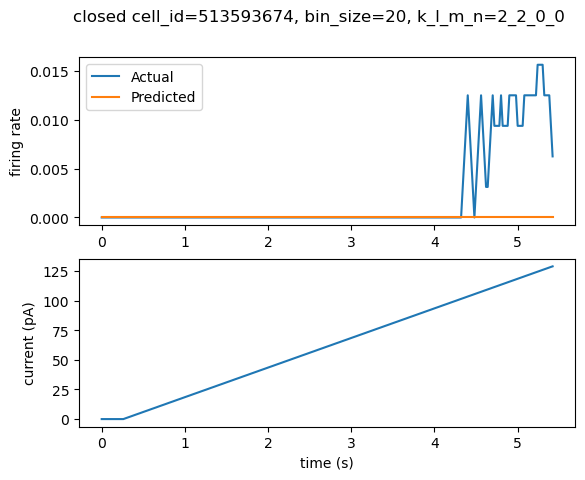

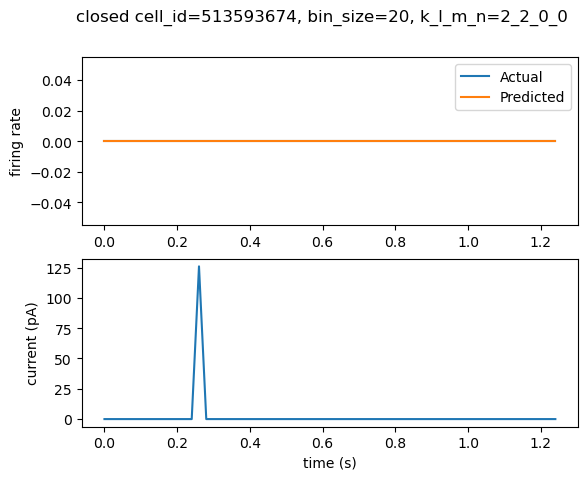

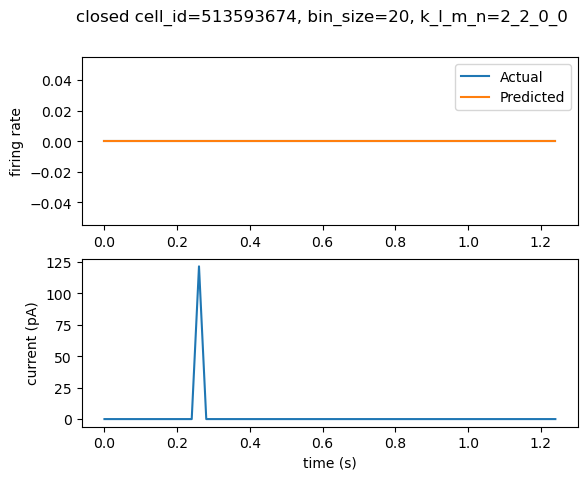

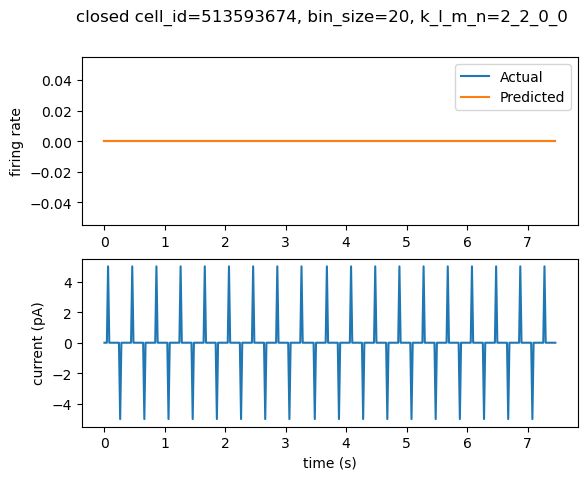

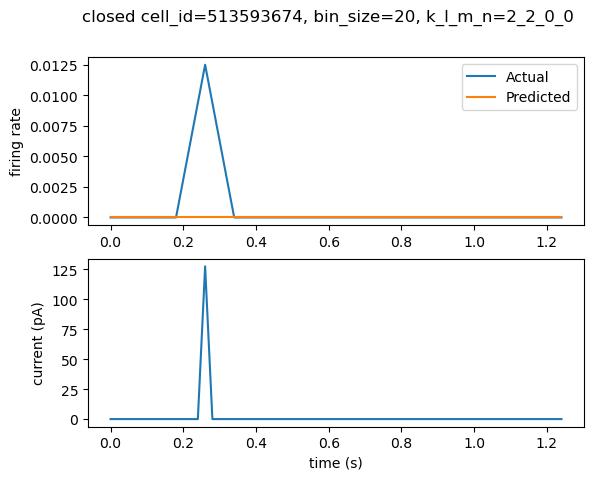

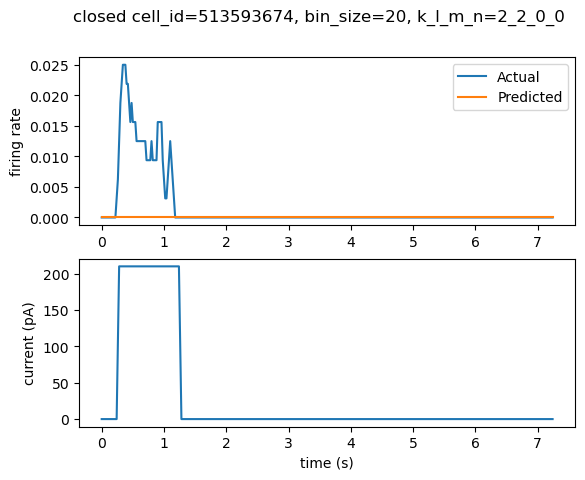

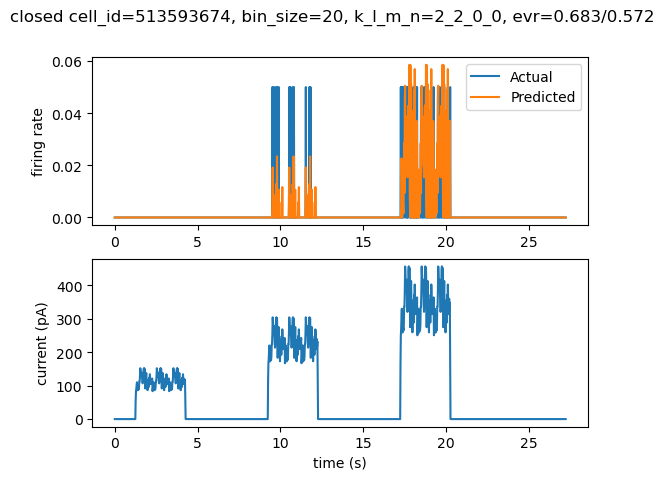

In [79]:
def exists(params, cell_id, bin_size, k, l, m, n):
    return cell_id in params and bin_size in params[cell_id] and (k, l, m, n) in params[cell_id][bin_size]

cell_id, bin_size, k, l = 513593674, 20, 2, 2
params = {}
m, n = 0, 0
for cell_id in [cell_id]:
    for bin_size in [bin_size]:
        for k in [k]:
            for l in [l]:
                print(f"cell_id={cell_id}, bin_size={bin_size}, k={k}, l={l}, m={m}, n={n}")
                if exists(params, cell_id, bin_size, k, l, m, n):
                    print("Skipped")
                else:
                    model = train(cell_id, bin_size, k, l, m, n, "poisson", save=False, static_g=True)
                    if cell_id not in params:
                        params[cell_id] = {}
                    if bin_size not in params[cell_id]:
                        params[cell_id][bin_size] = {}
                    params[cell_id][bin_size][(k, l, m, n)] = model.get_params()
                    print(model.a.tolist(), model.b.tolist(), model.c.tolist(), model.d.tolist())
                    
                    #with open('model/params.pickle', 'wb') as handle:
                    #    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [80]:
print(model.a.tolist(), model.b.tolist(), model.c.tolist(), model.d.tolist())

[0.1853727102279663, -0.23888233304023743] [-0.604421079158783, -1.5982969999313354] [] []


/var/folders/1d/cmypn_251jlfyvc132scjqd40000gp/T/ipykernel_48116/2483228628.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2)


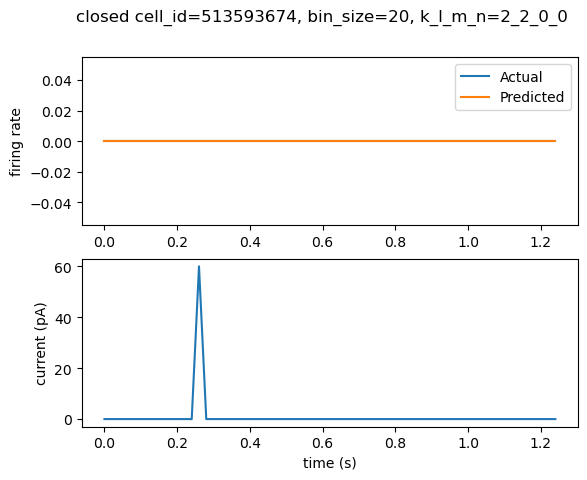

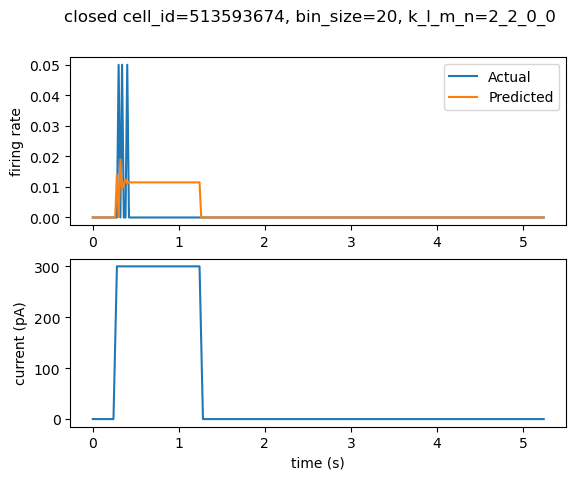

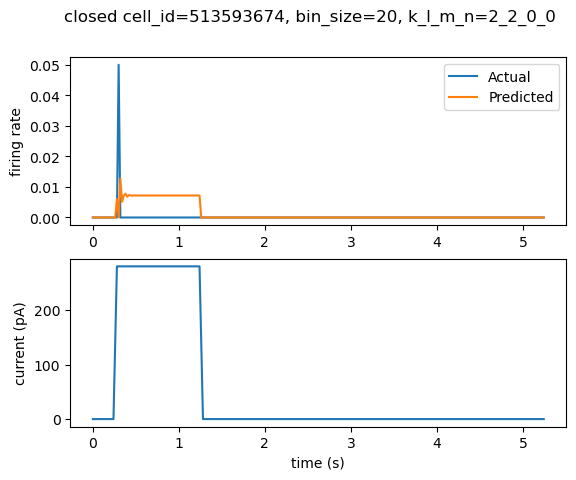

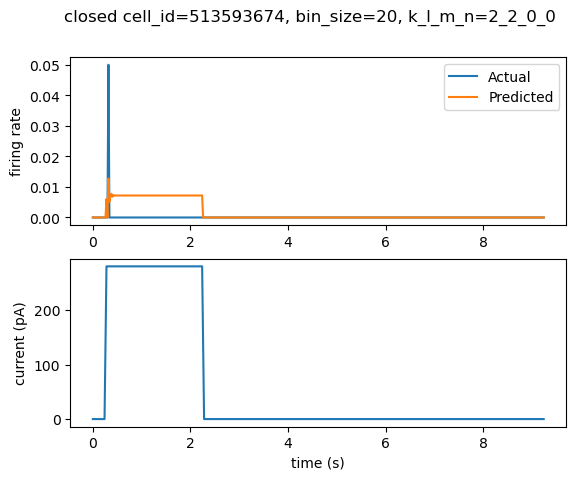

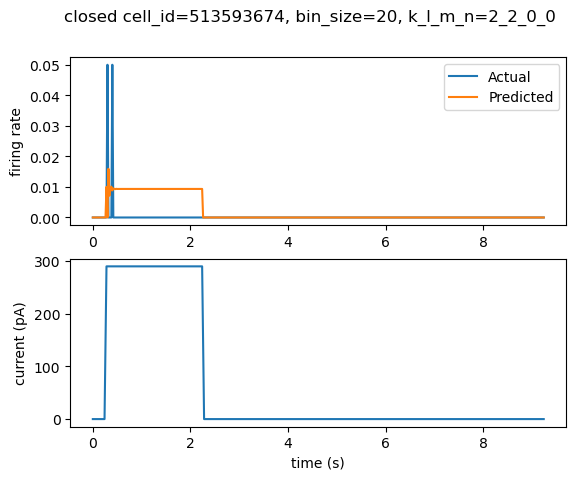

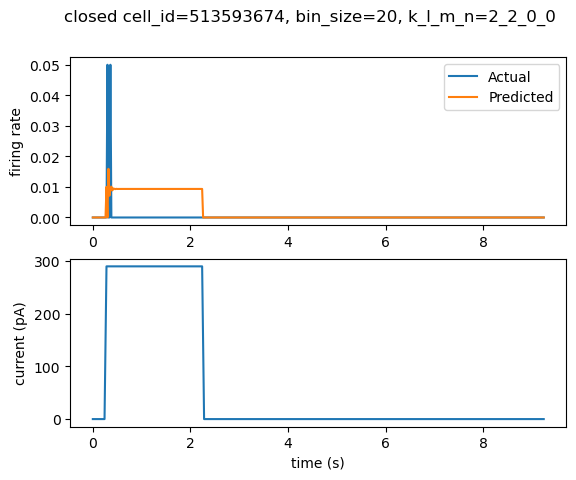

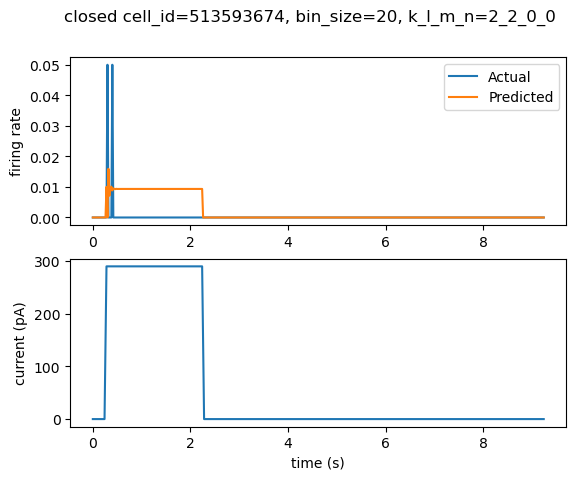

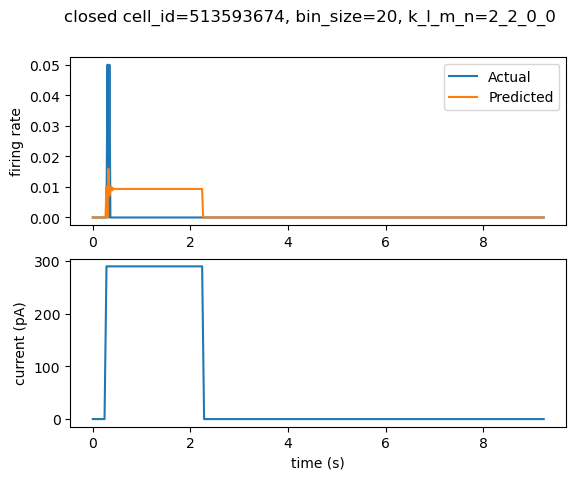

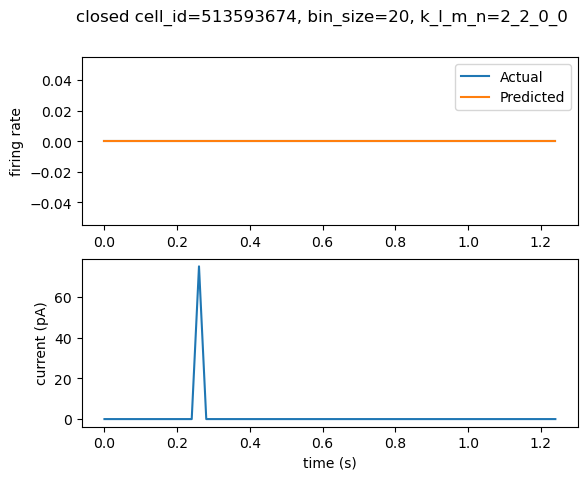

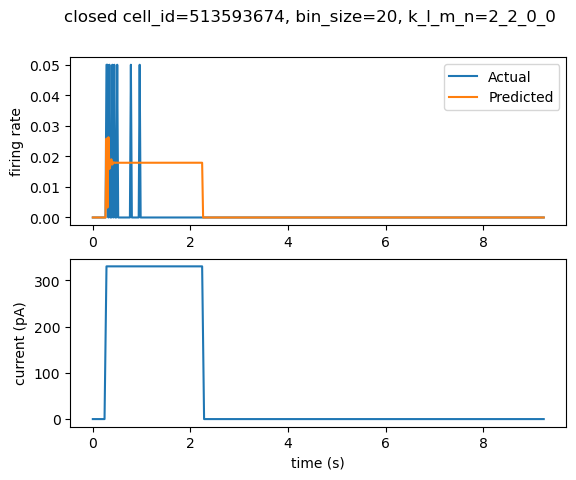

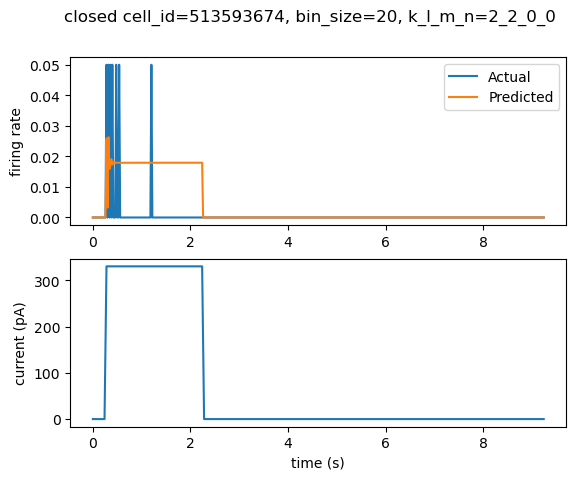

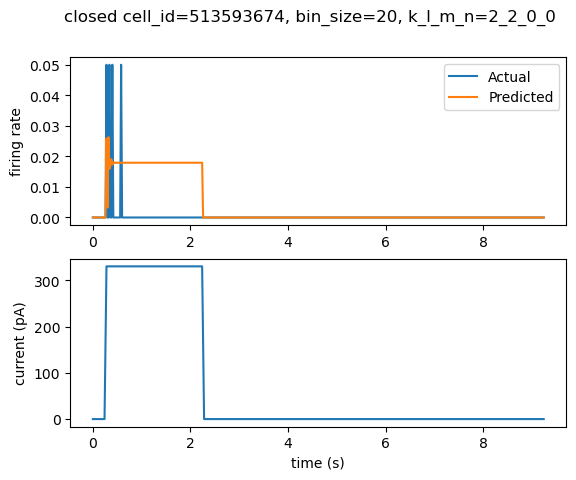

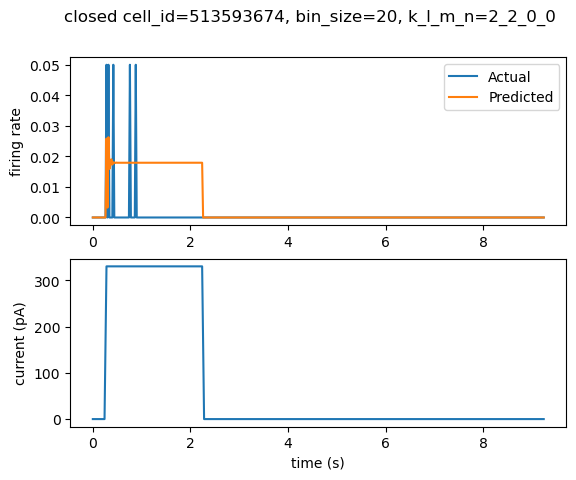

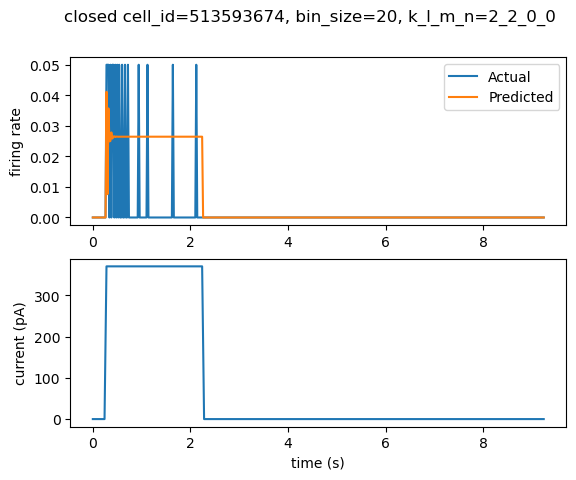

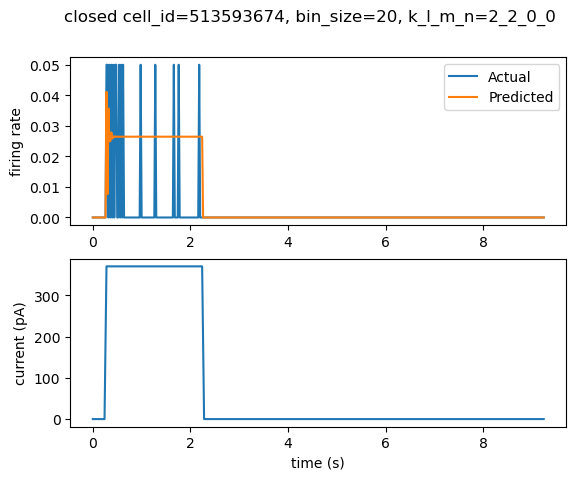

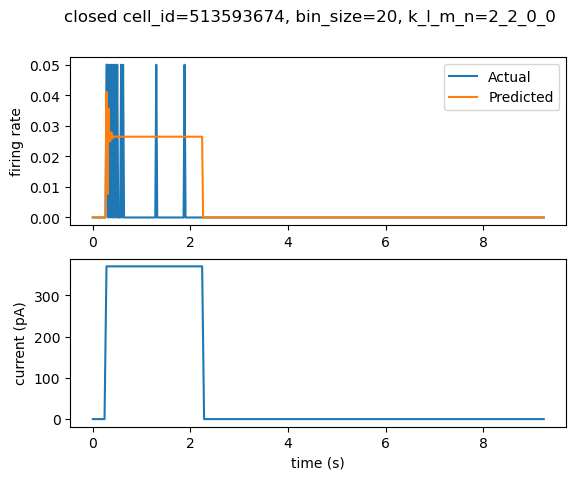

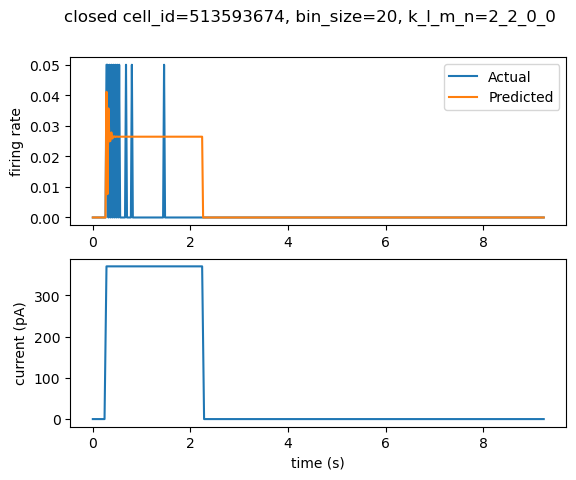

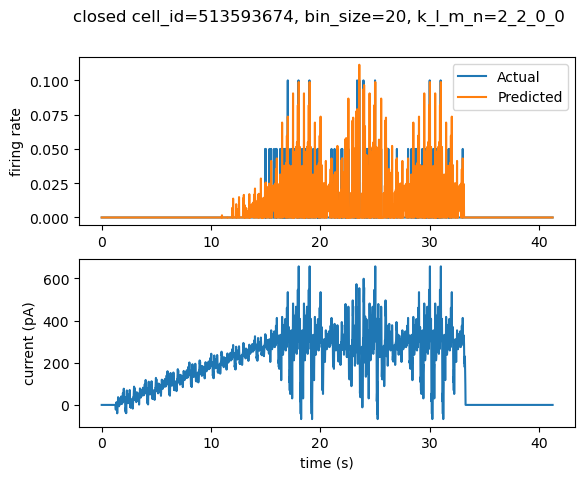

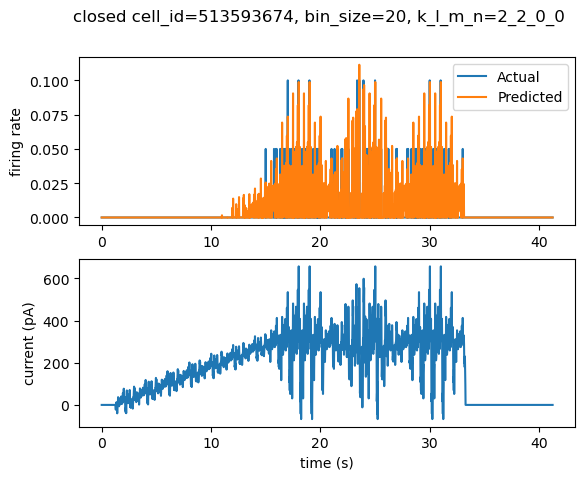

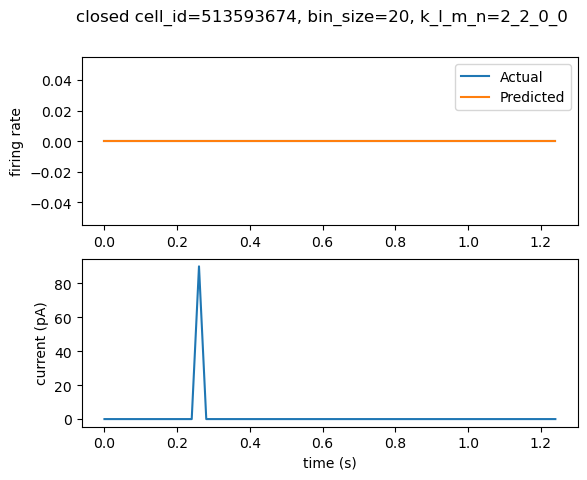

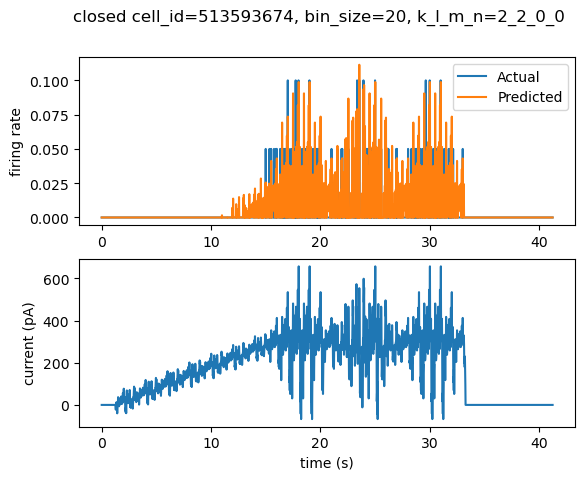

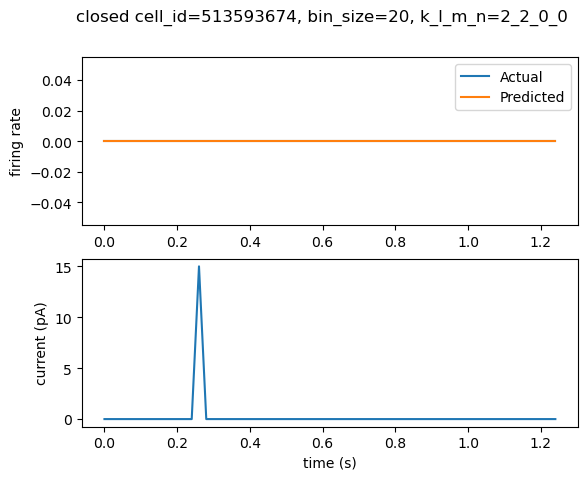

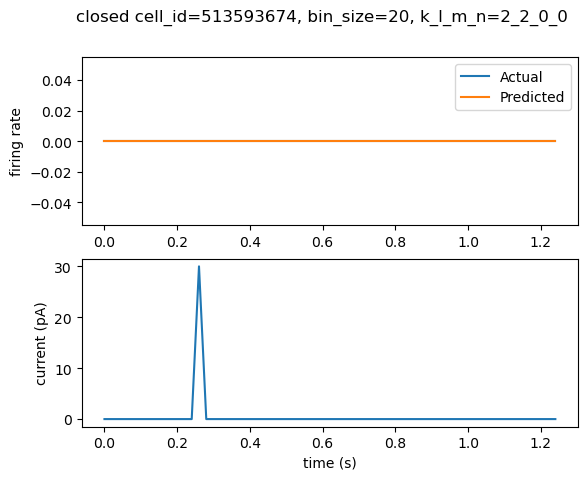

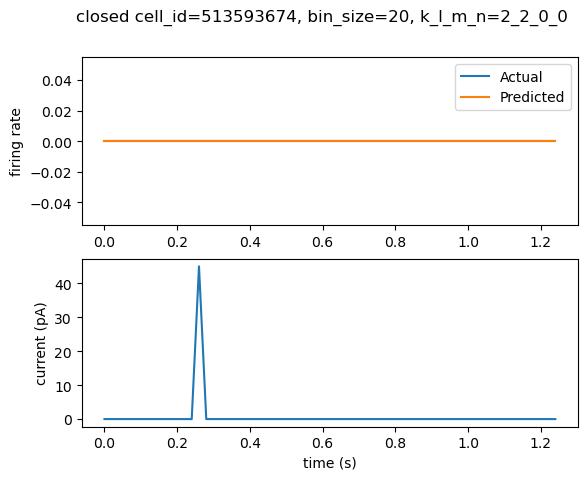

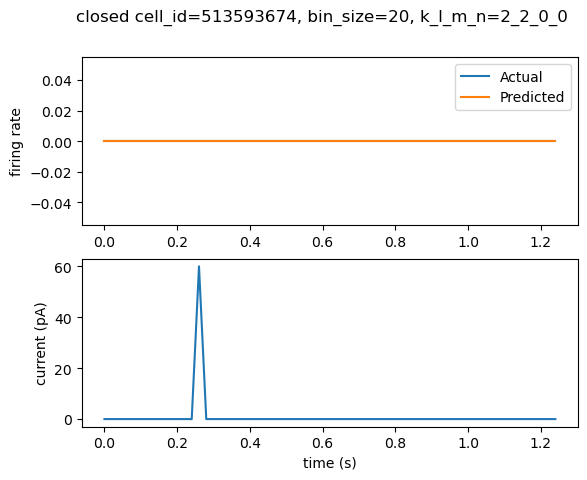

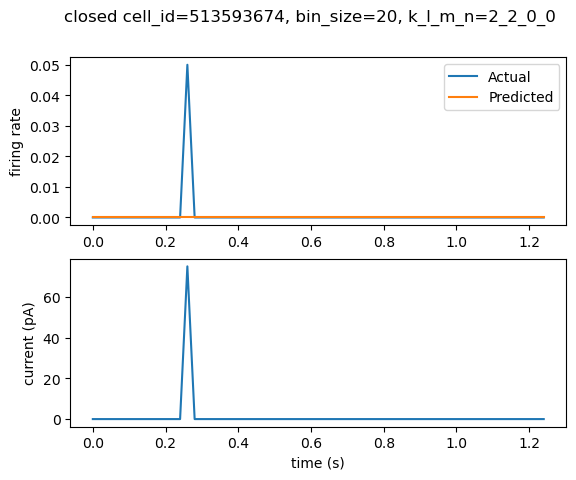

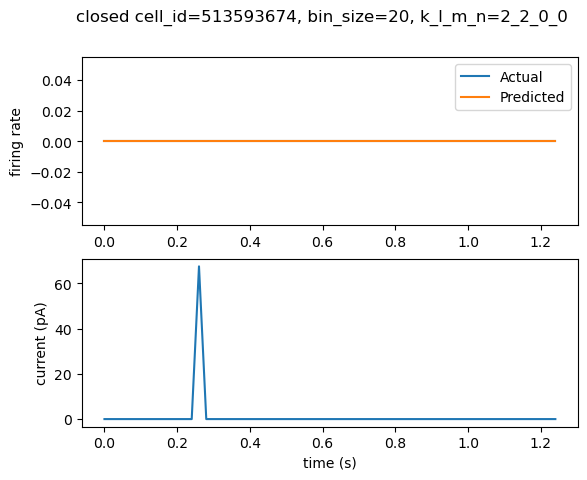

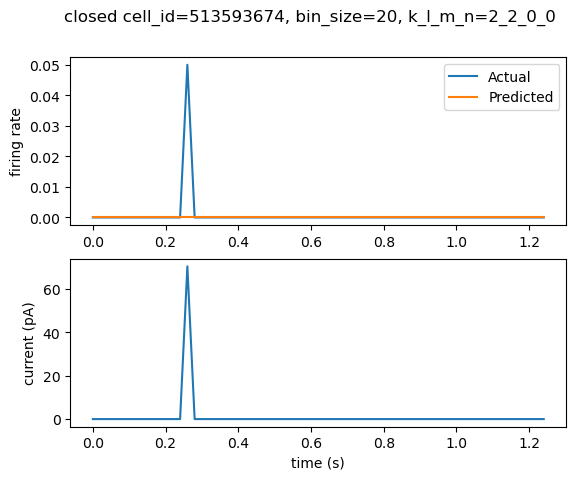

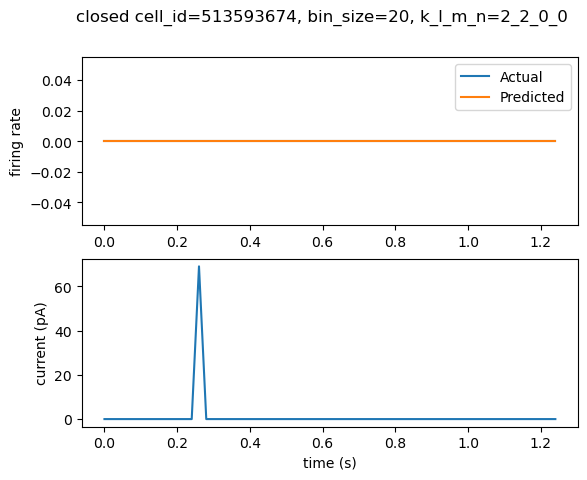

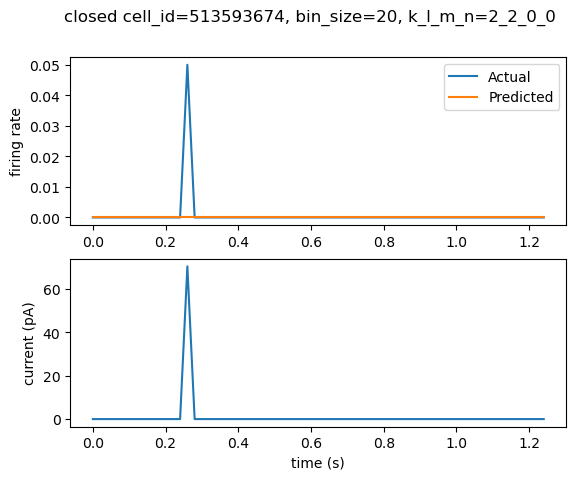

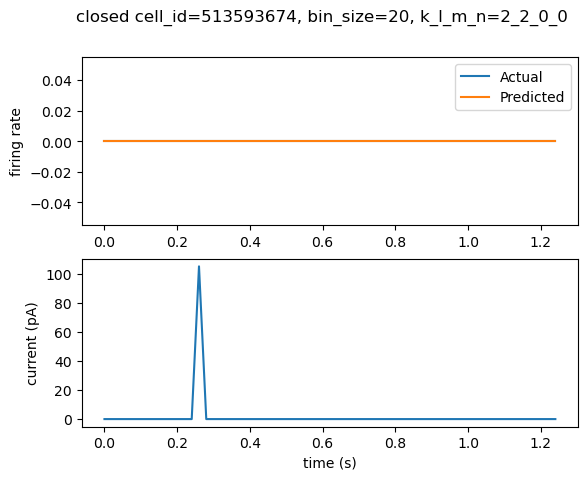

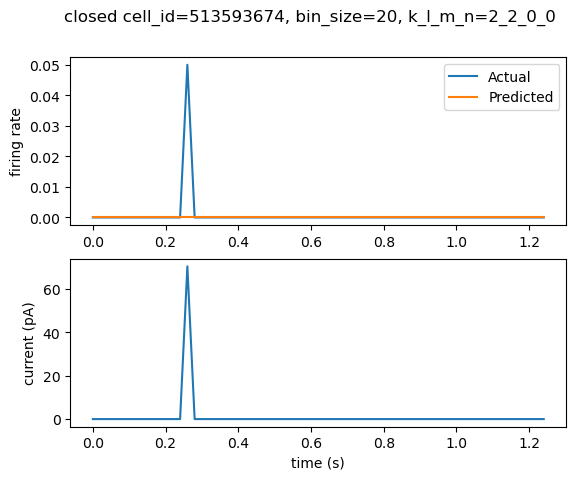

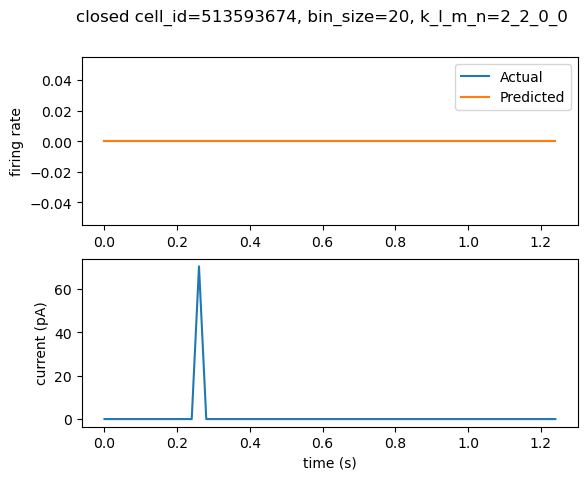

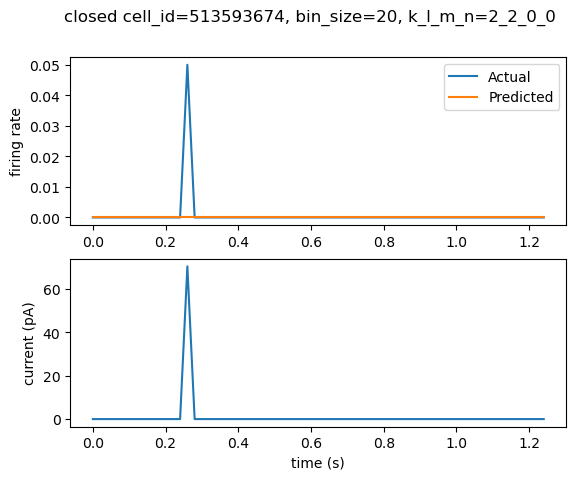

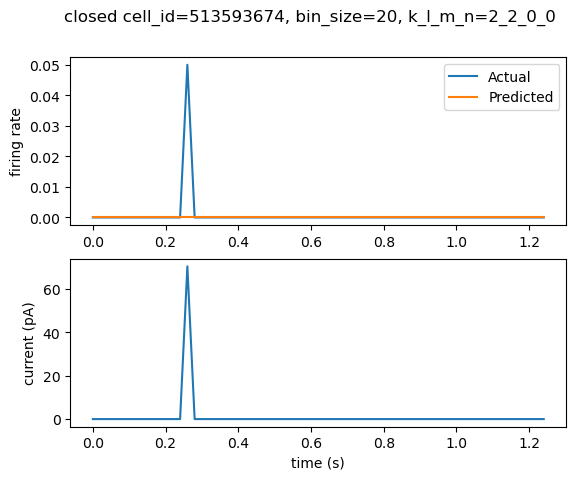

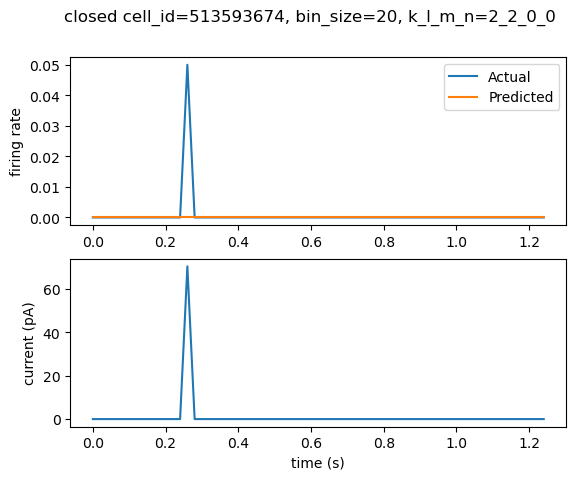

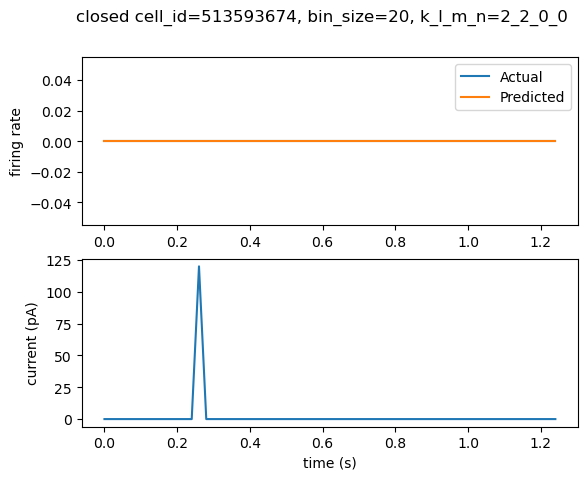

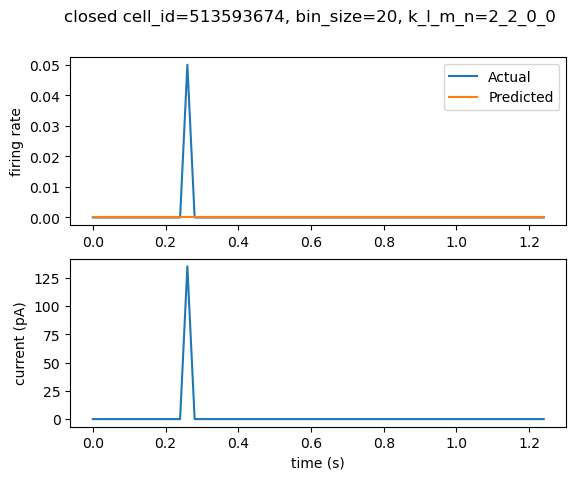

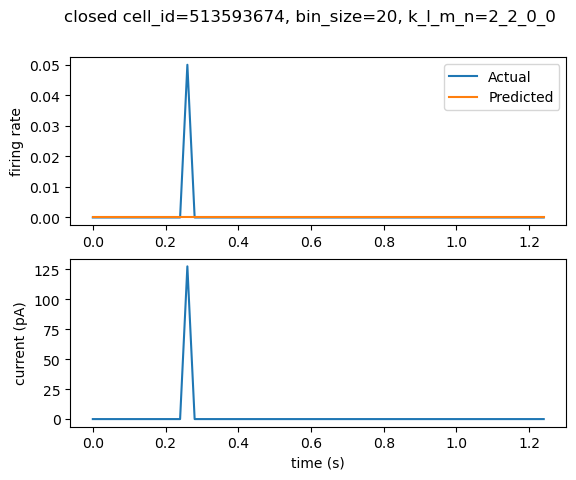

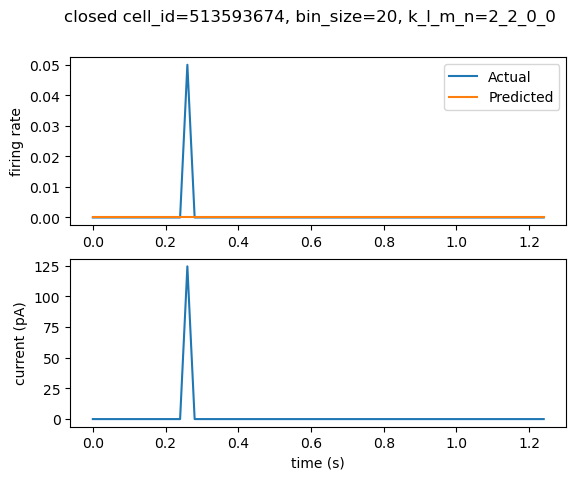

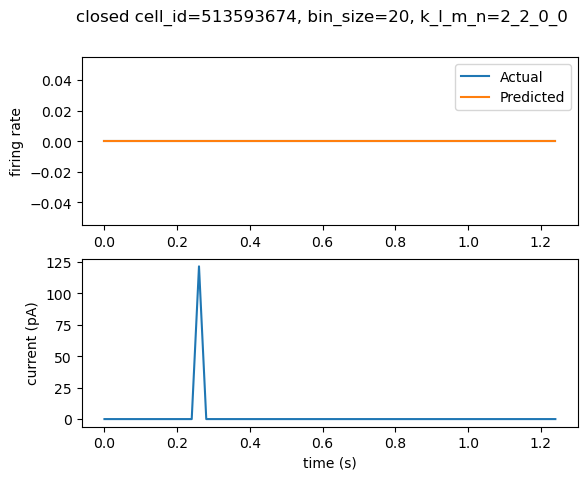

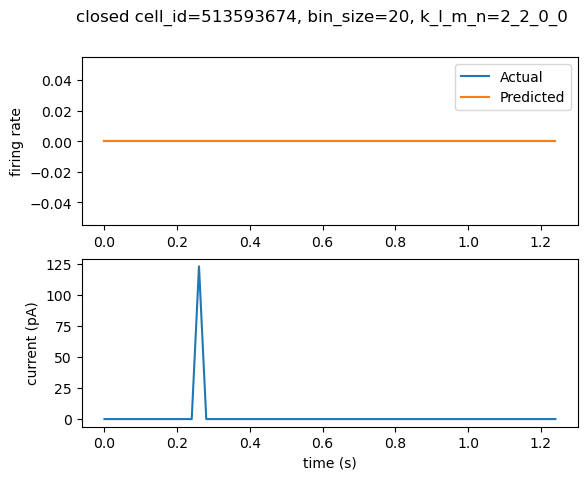

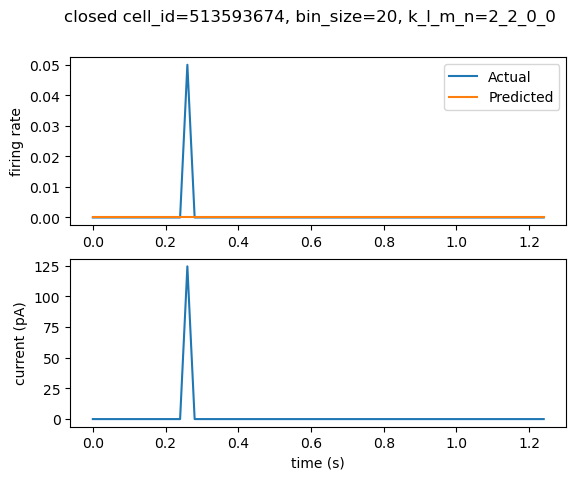

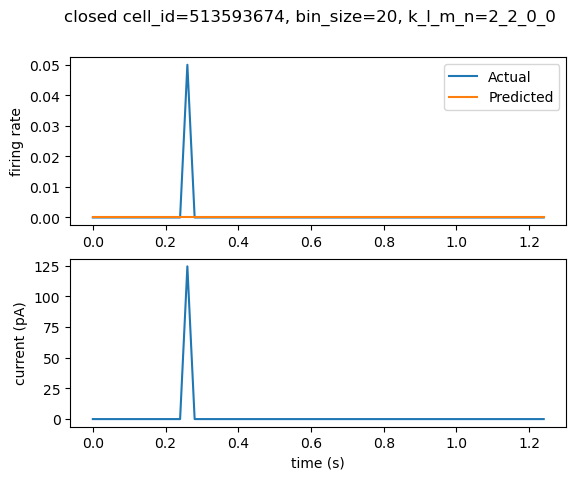

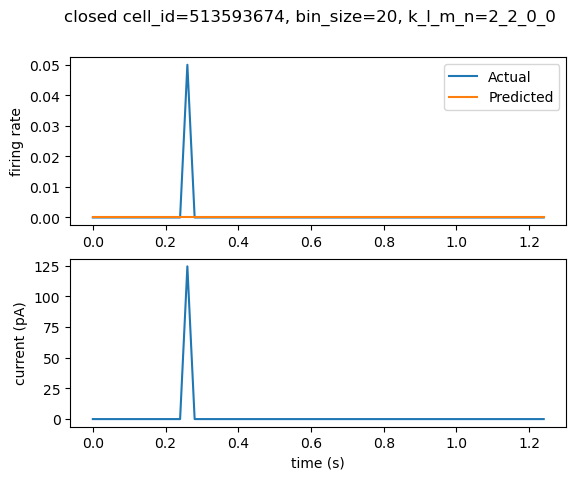

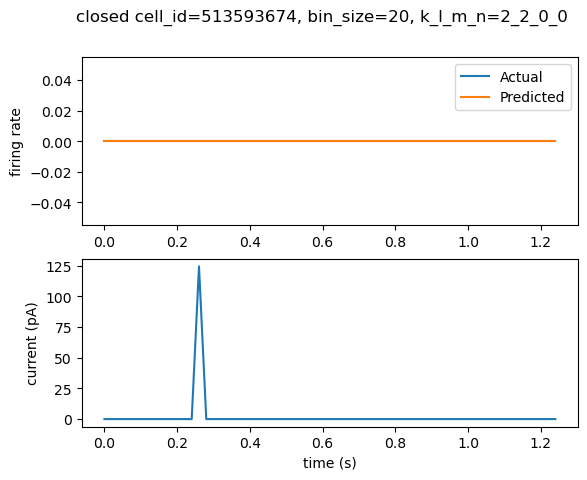

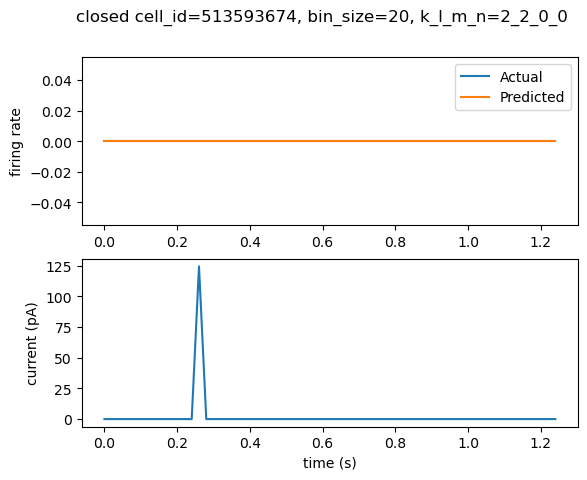

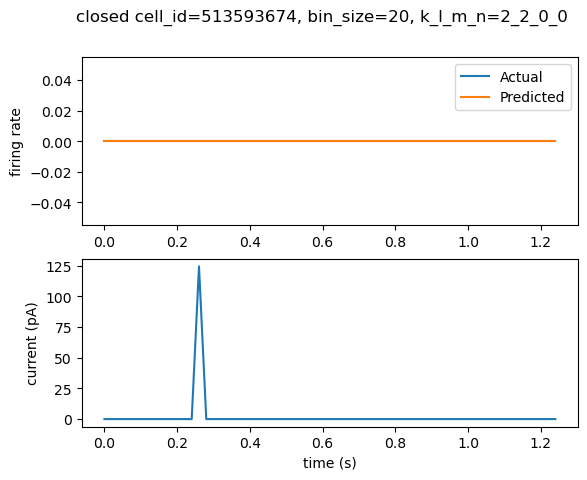

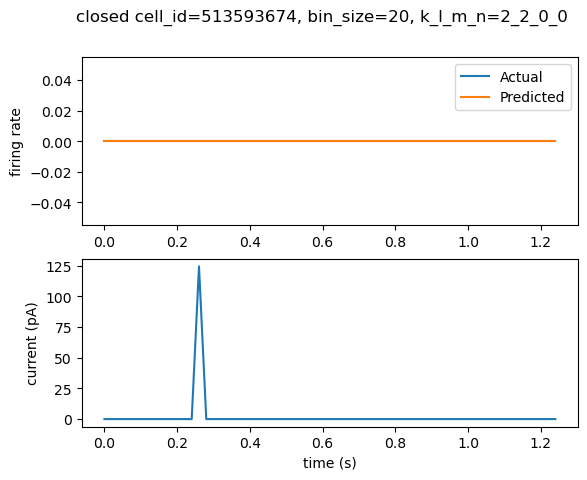

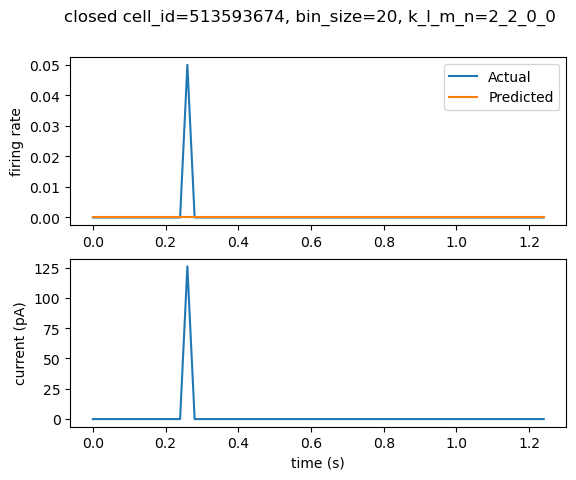

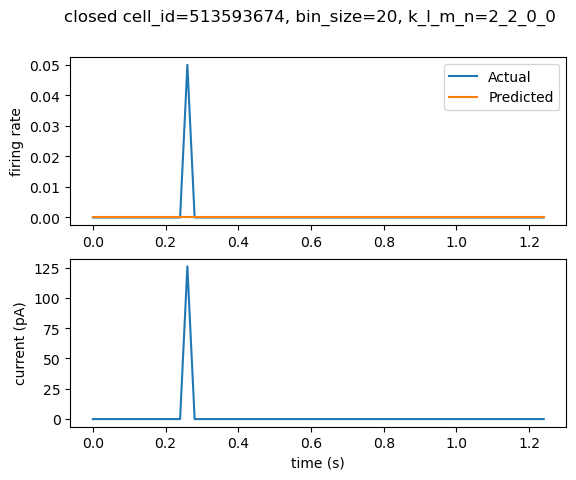

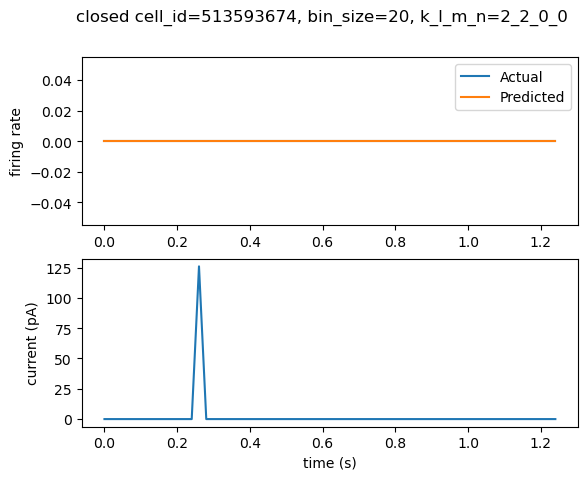

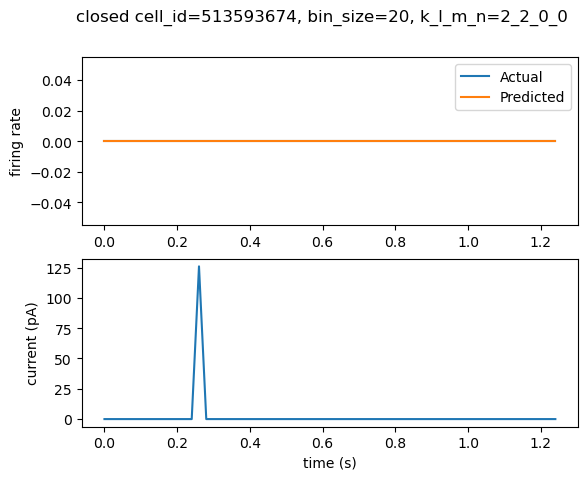

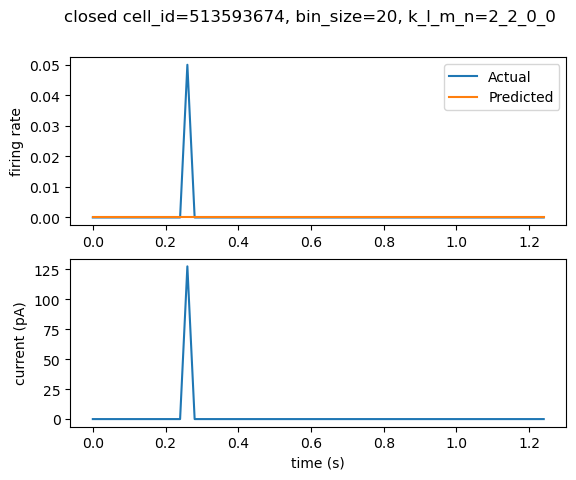

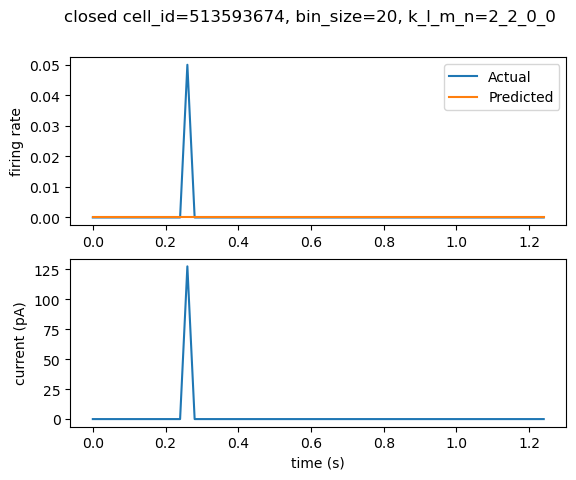

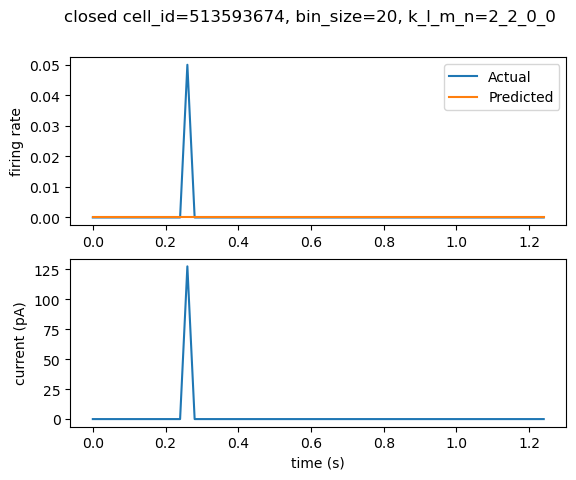

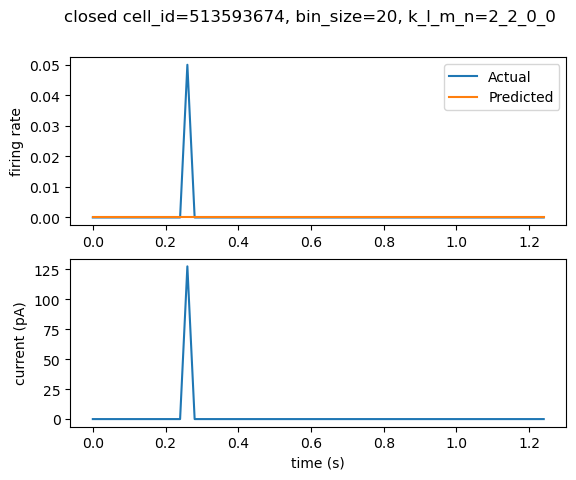

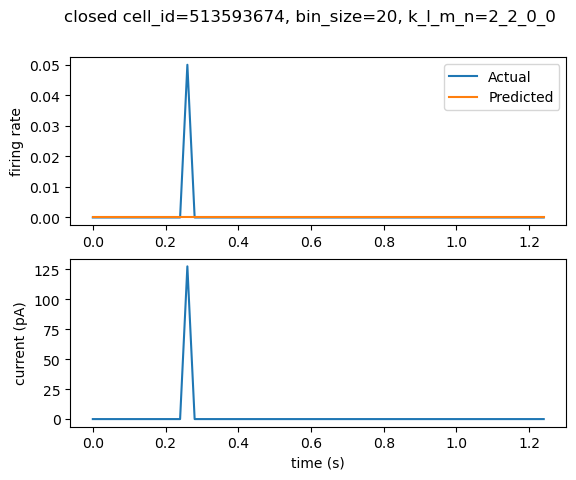

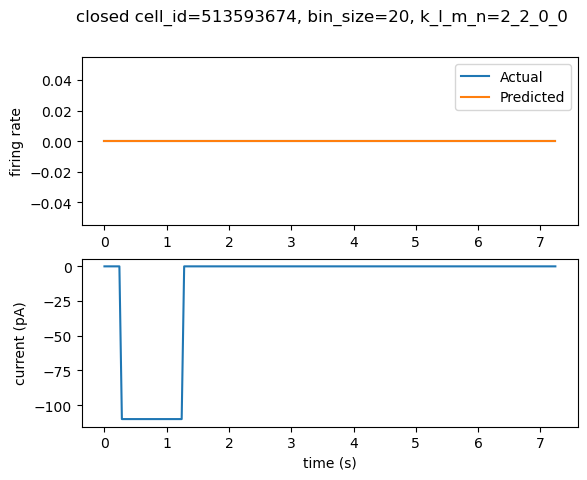

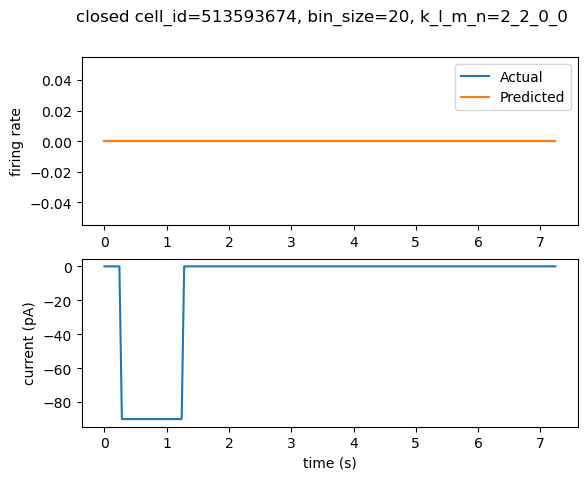

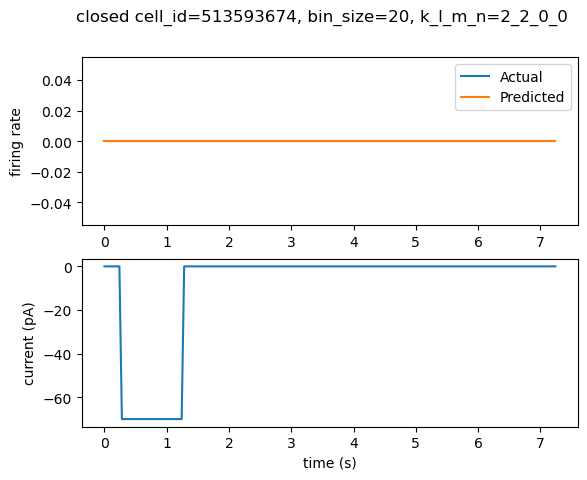

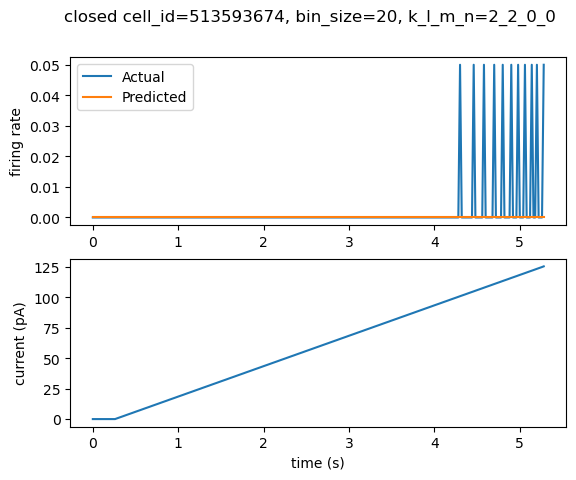

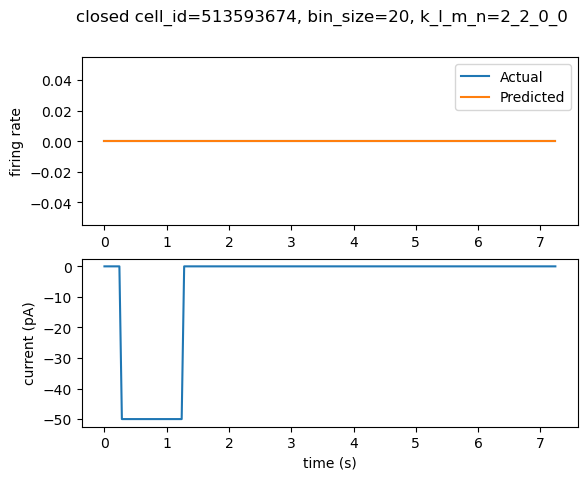

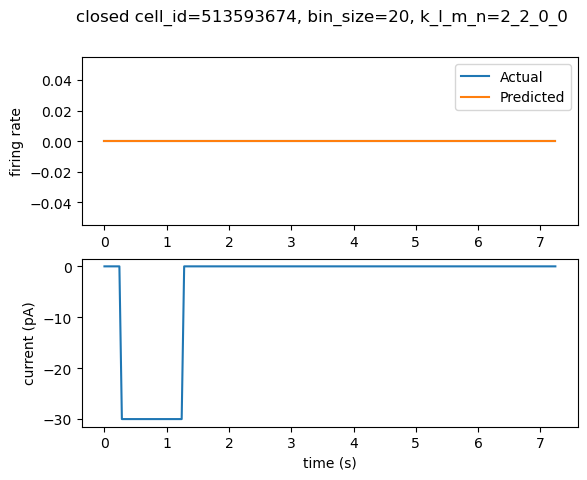

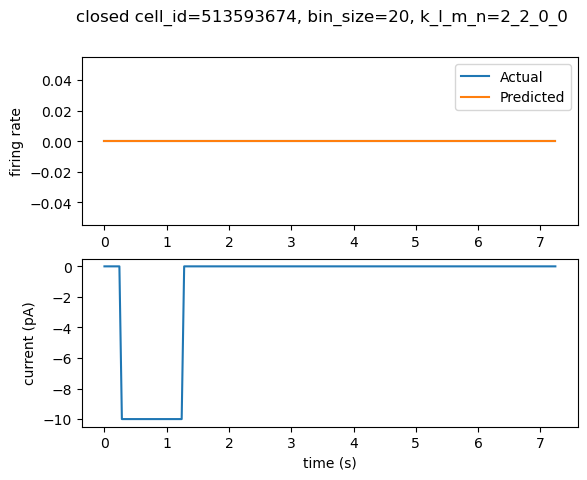

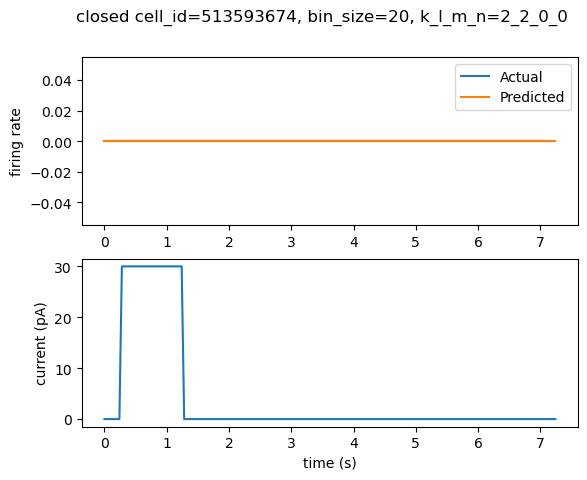

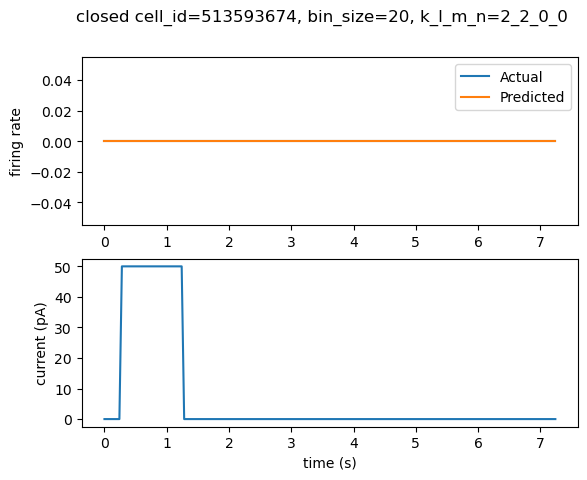

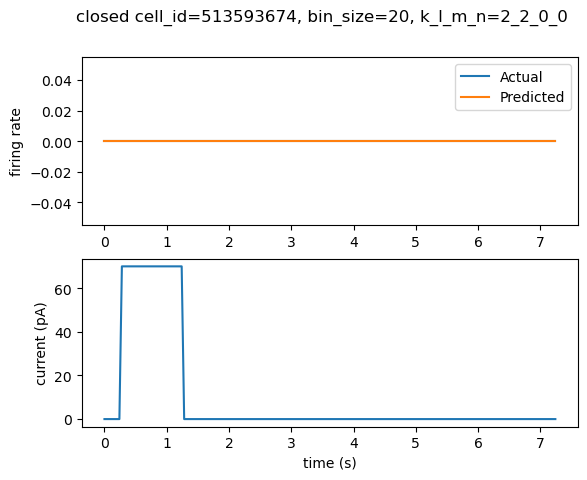

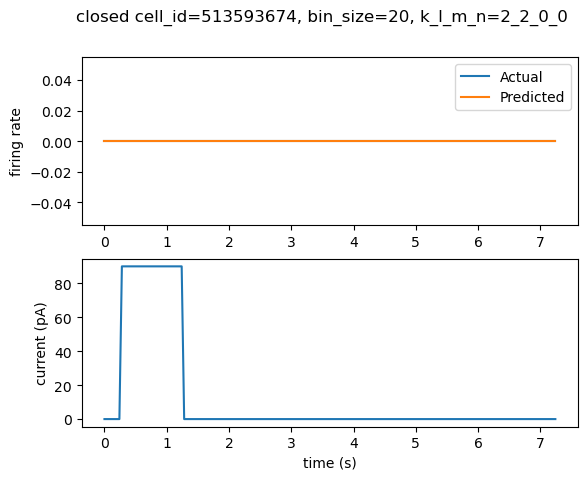

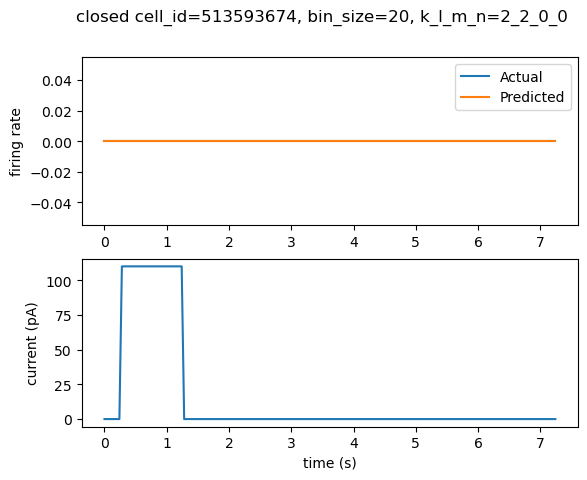

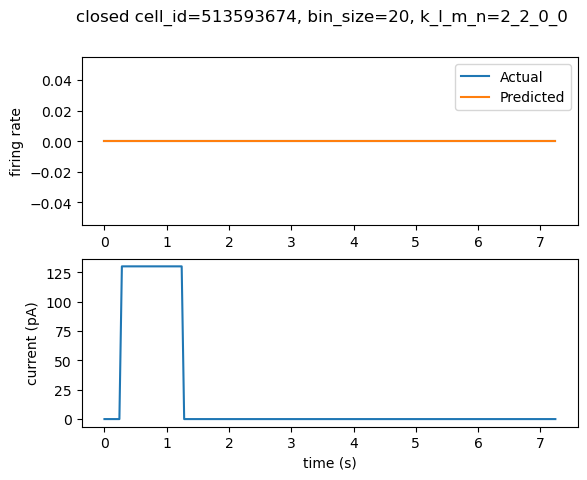

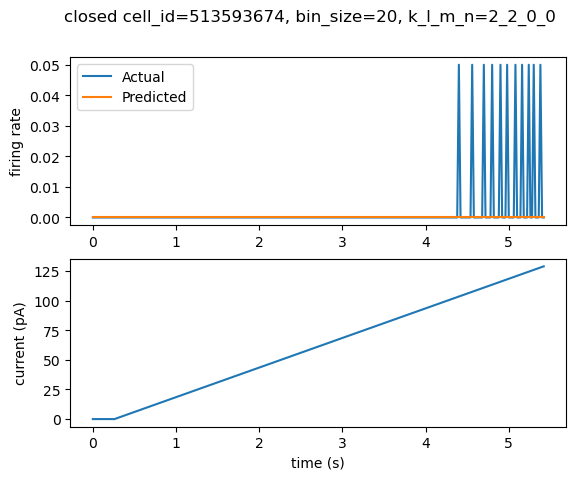

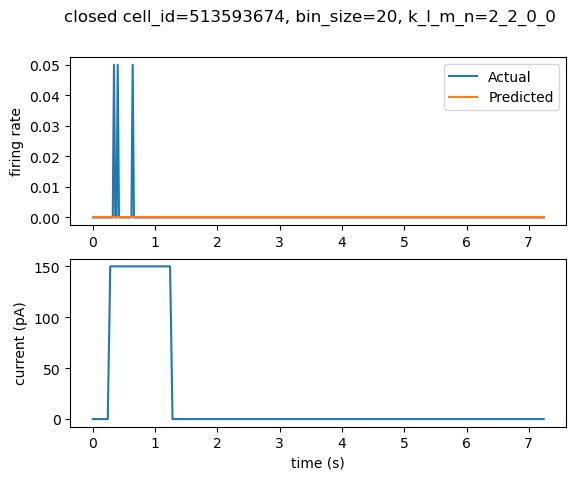

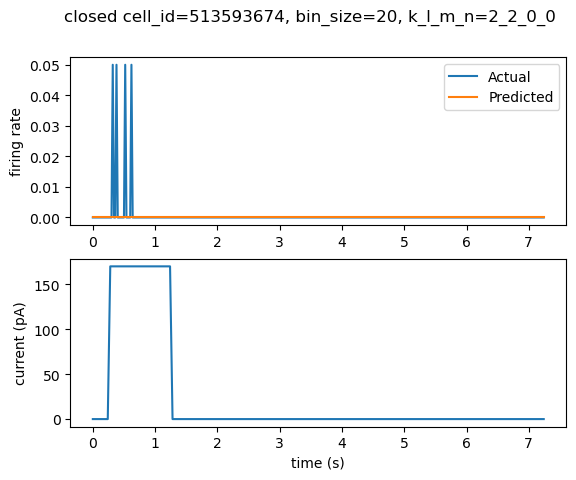

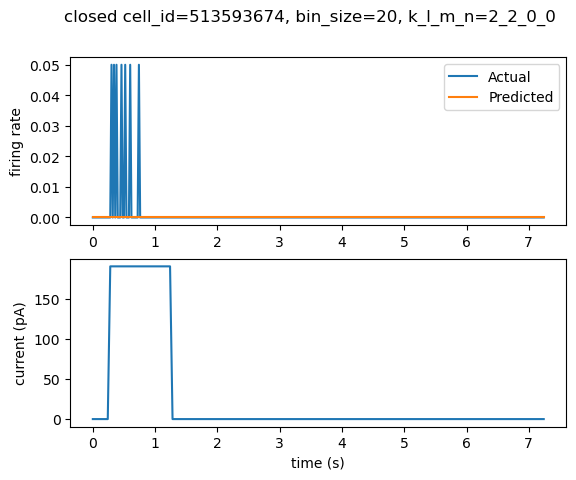

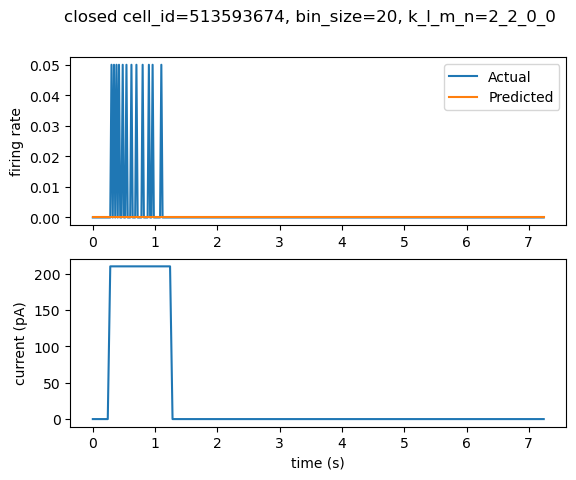

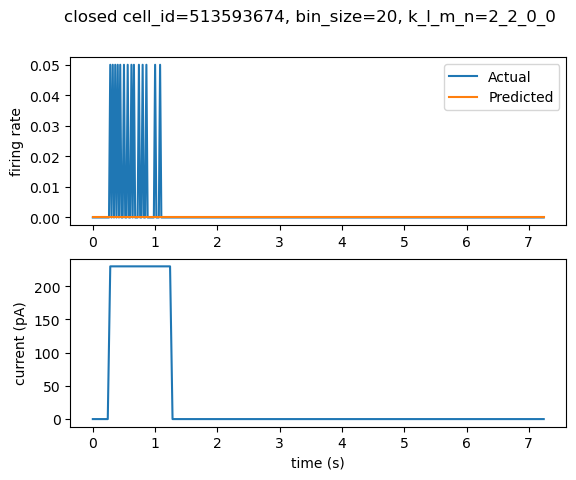

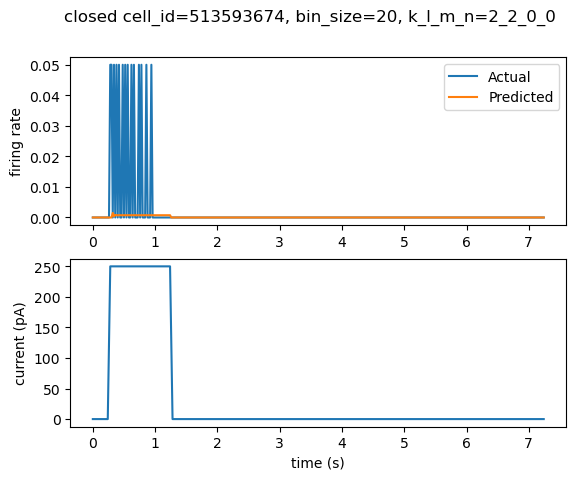

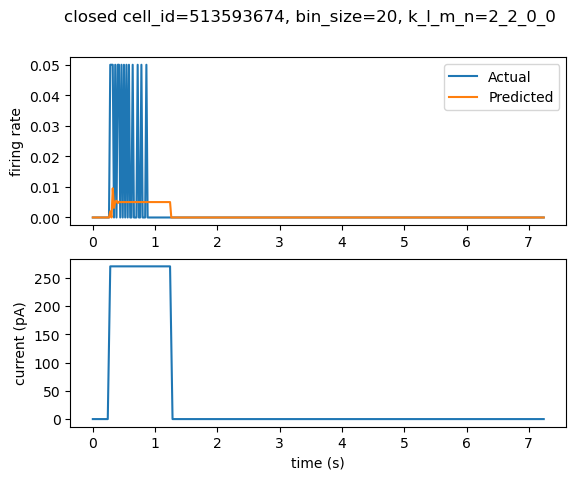

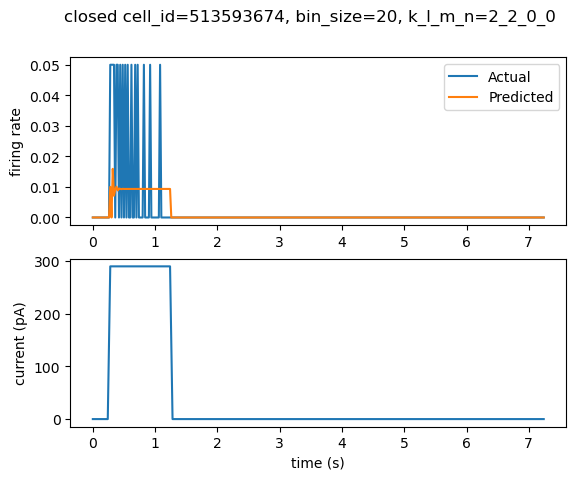

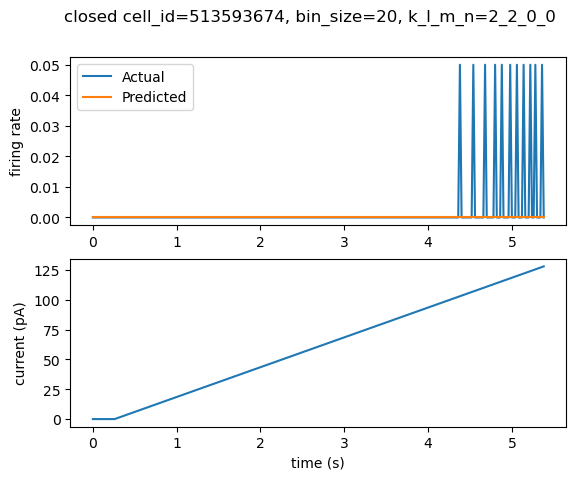

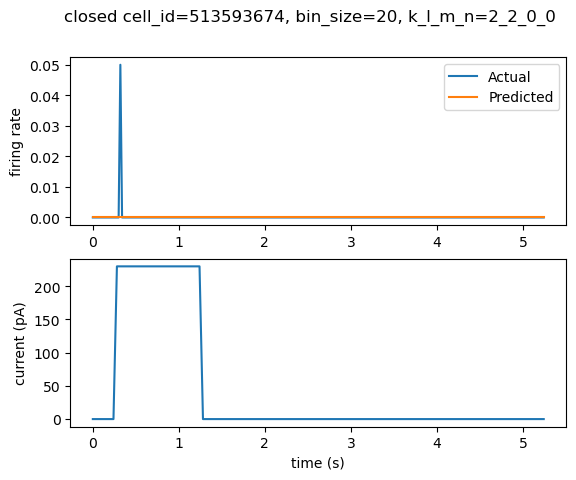

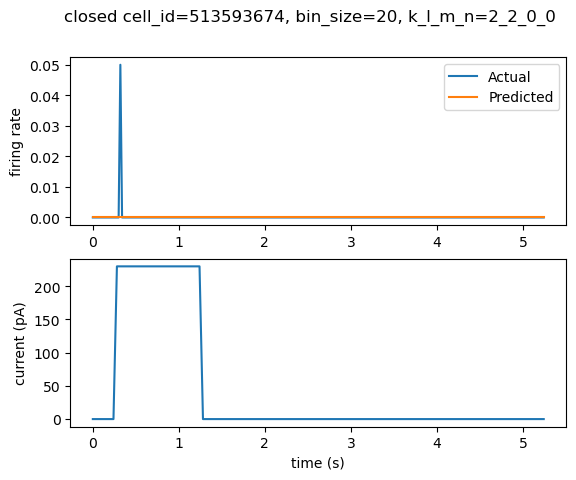

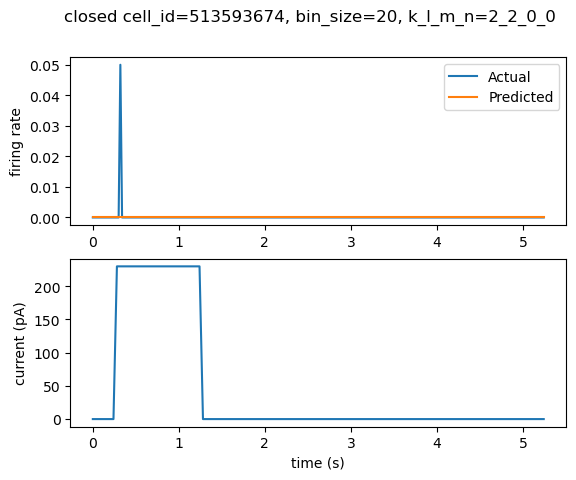

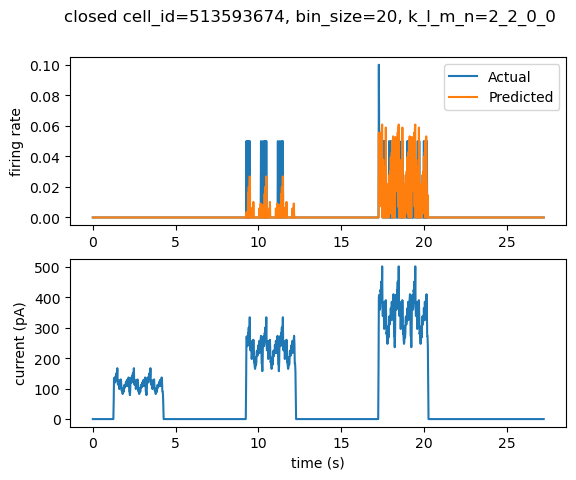

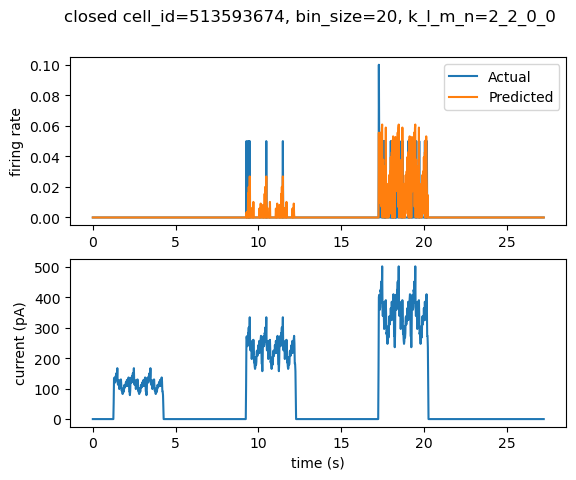

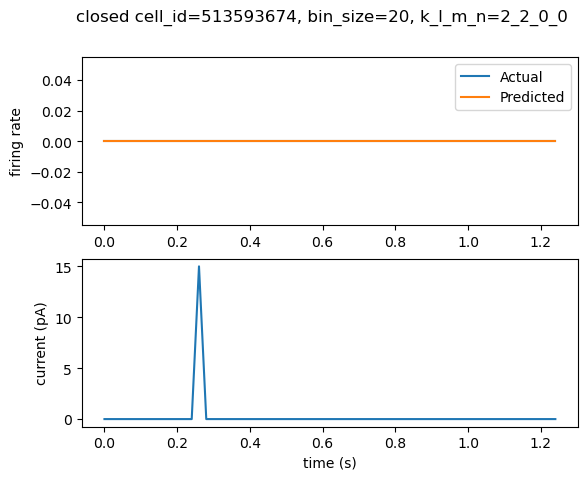

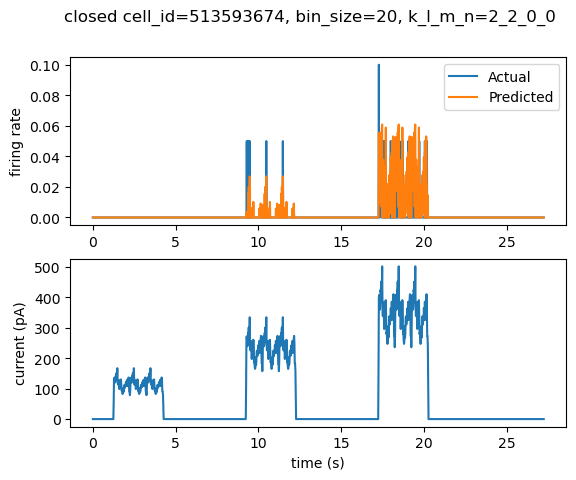

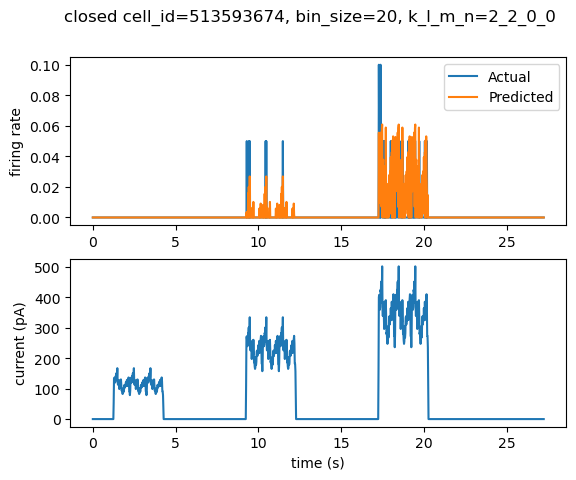

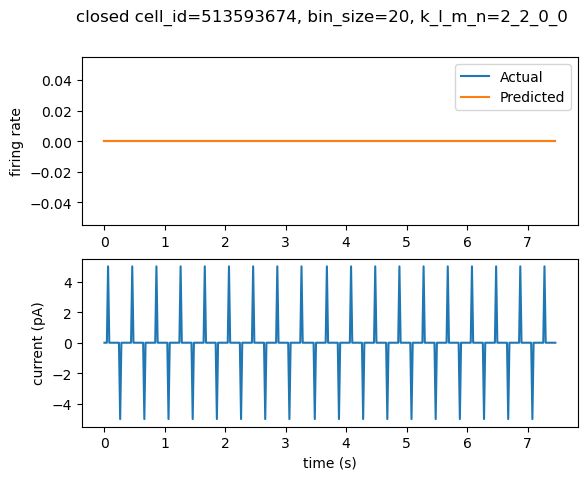

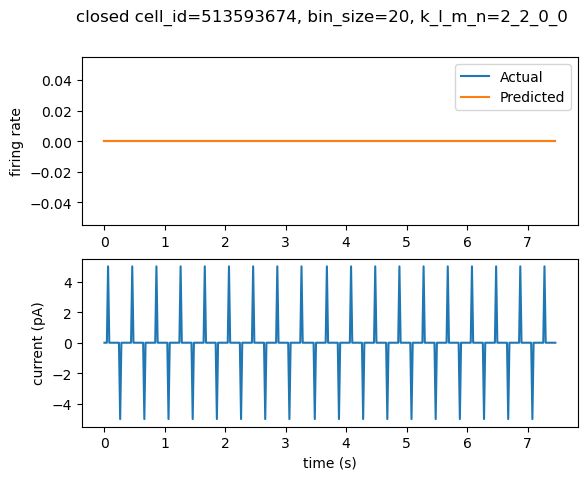

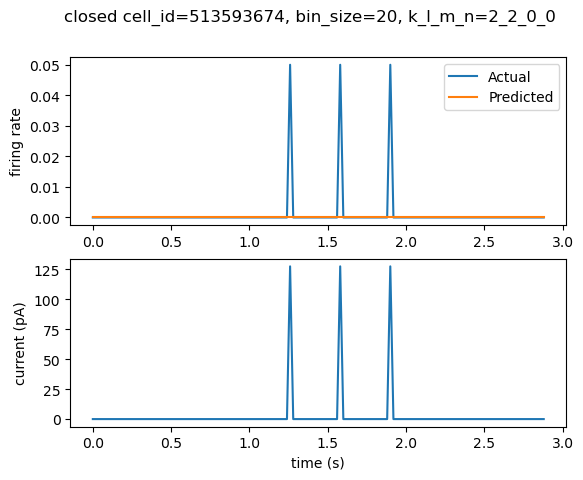

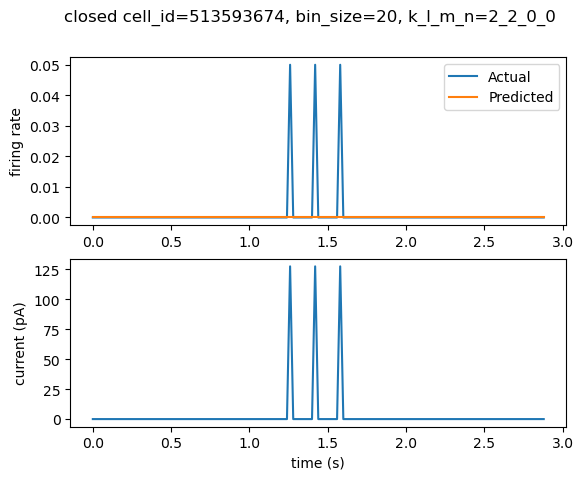

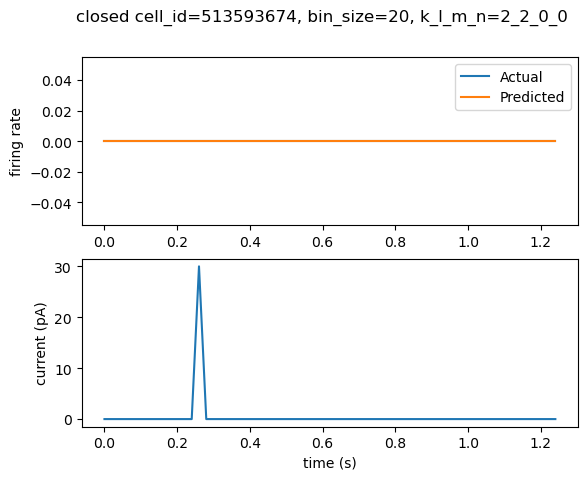

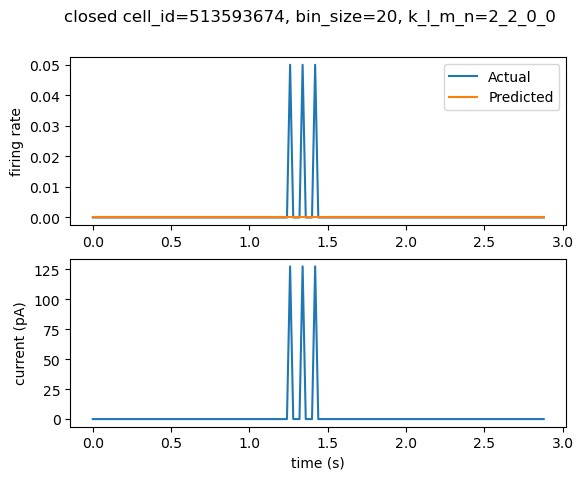

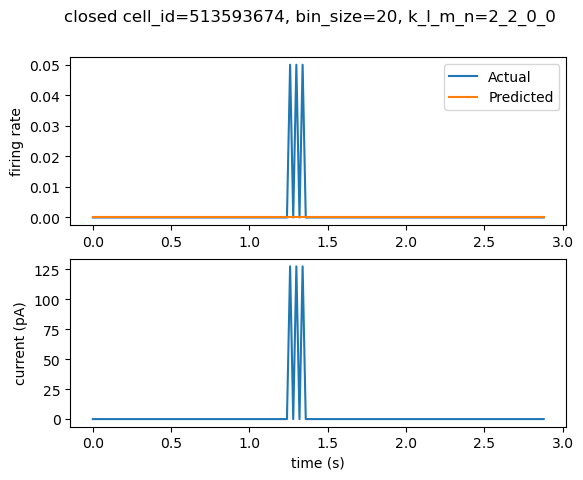

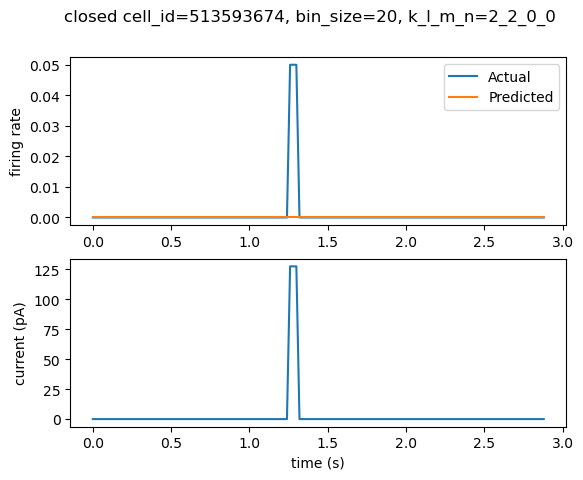

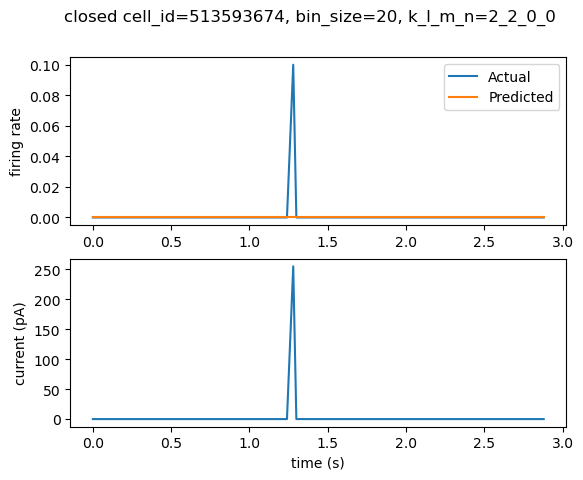

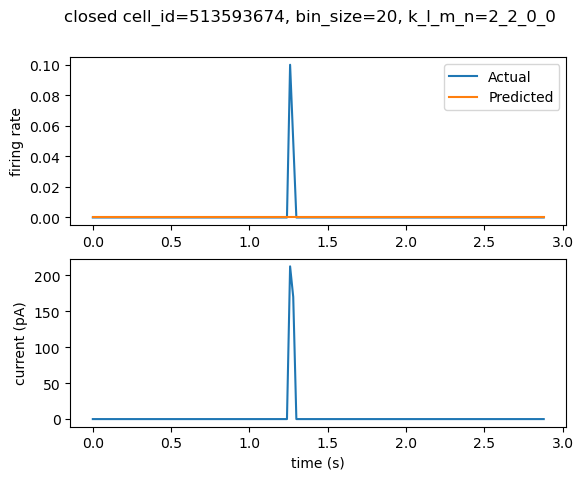

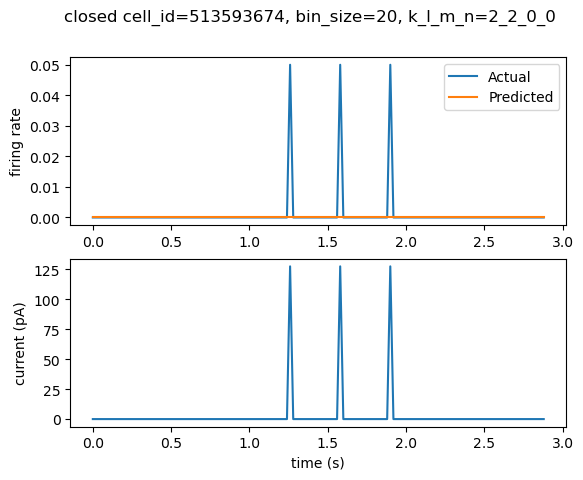

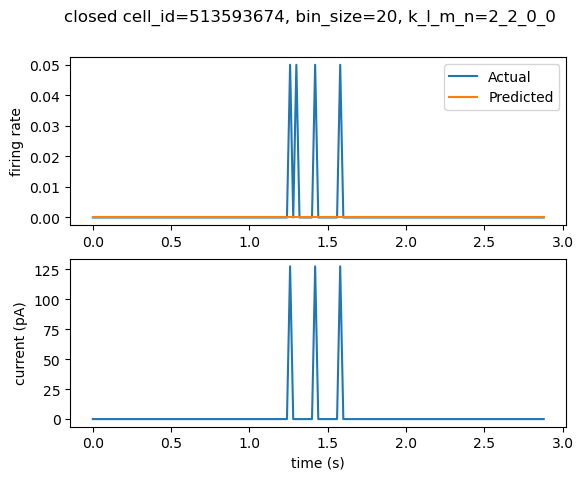

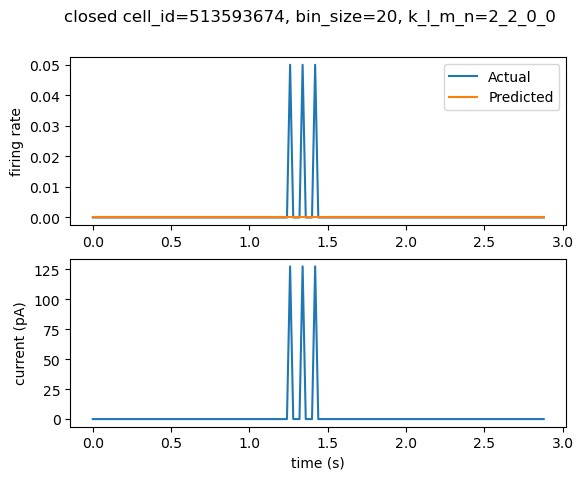

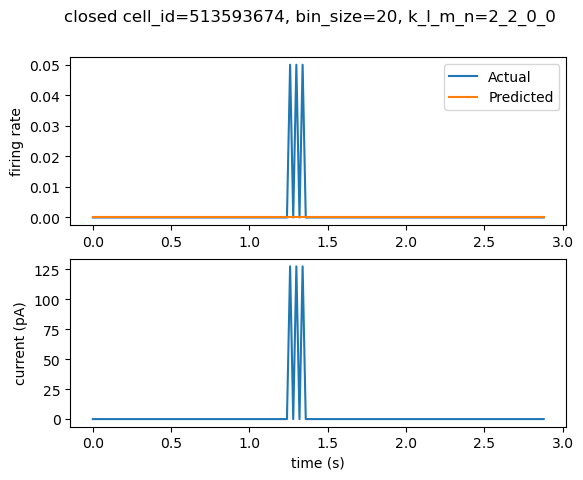

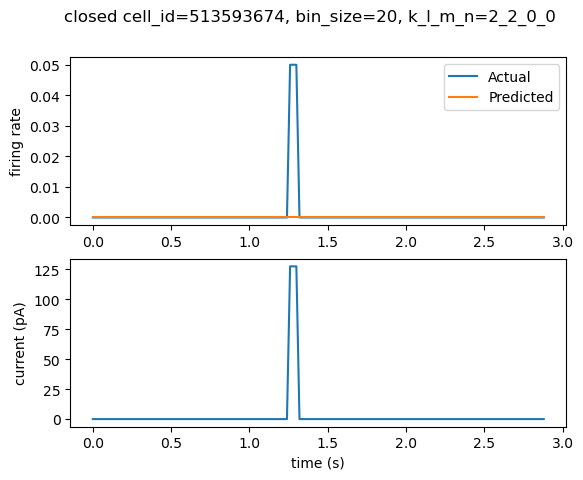

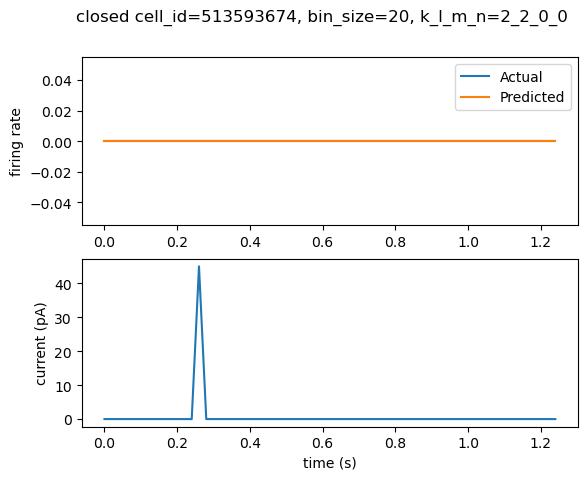

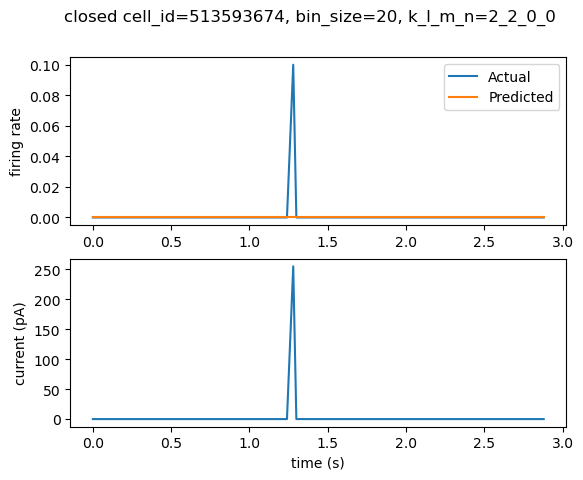

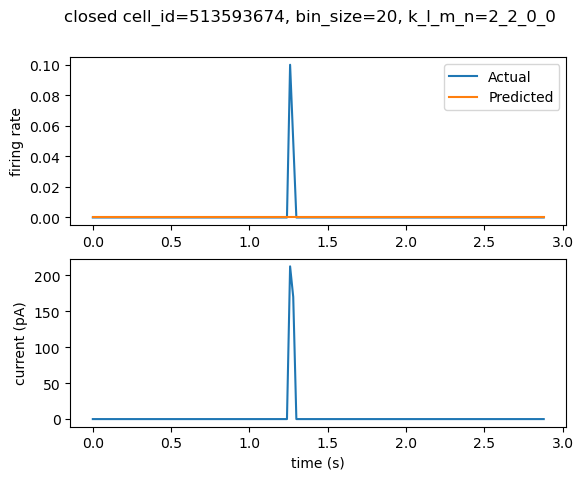

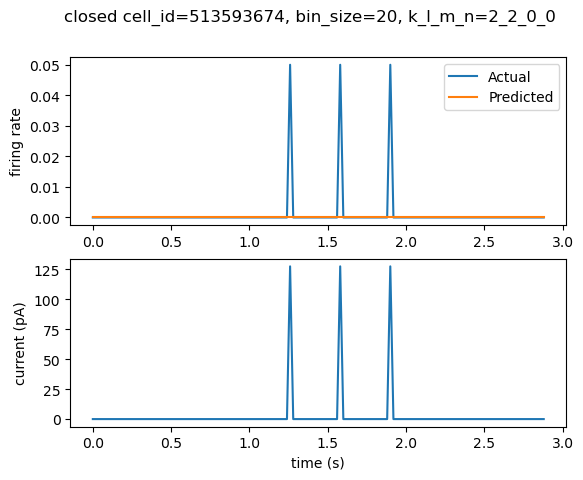

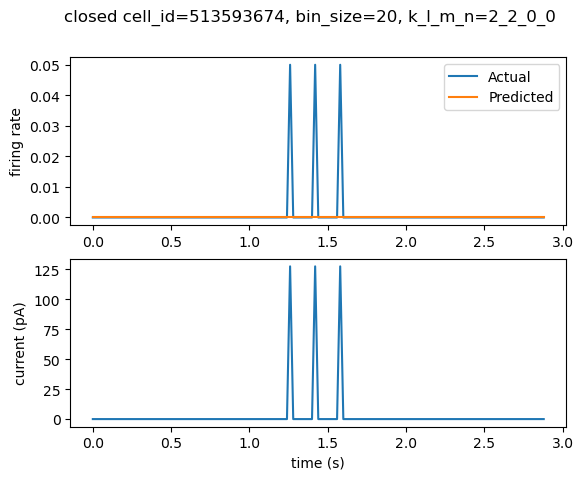

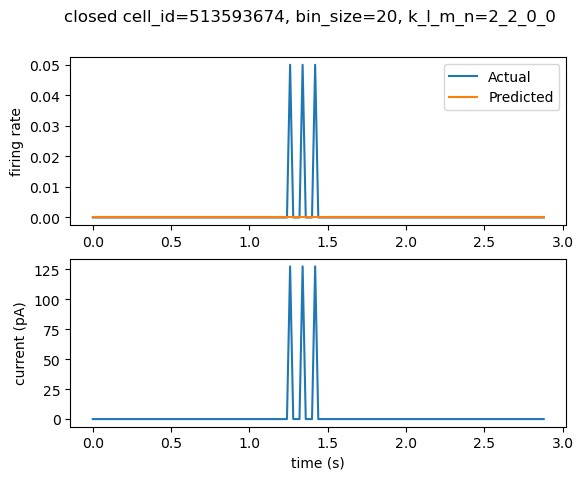

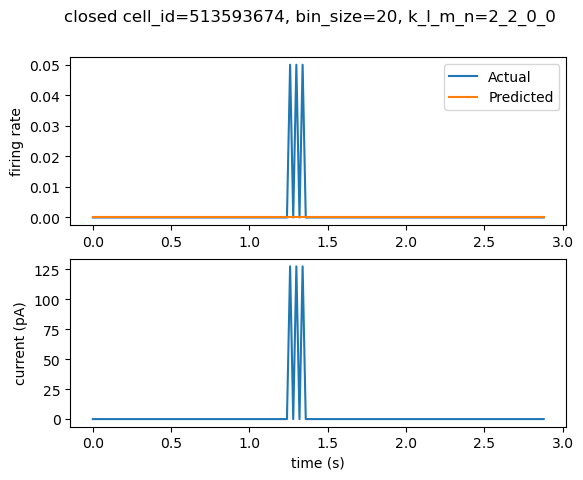

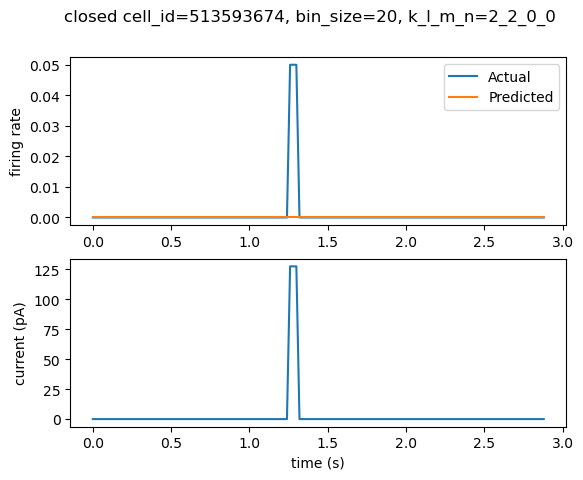

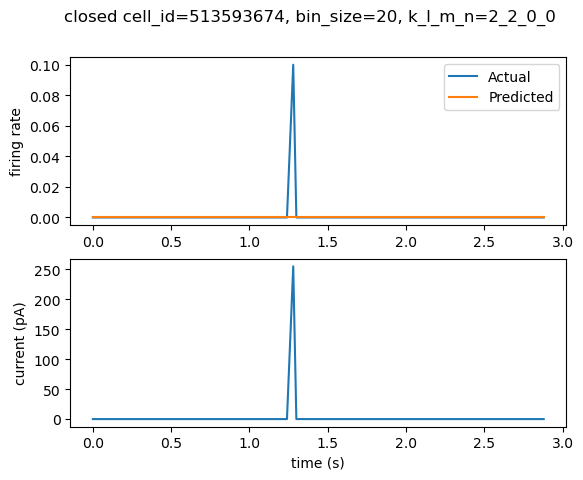

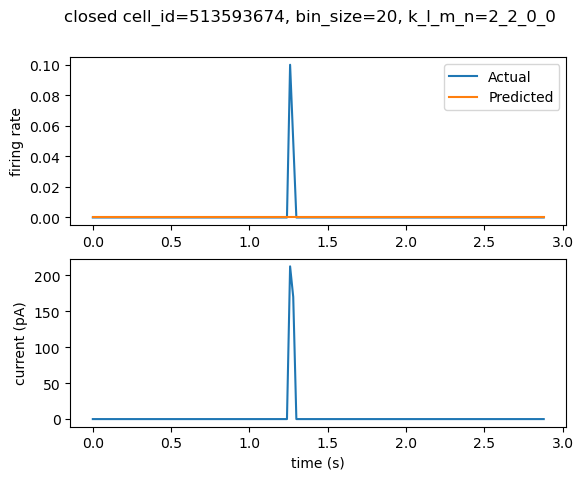

In [81]:
save = False
Is_tr, fs_tr, Is_te, fs_te, ws = get_train_test_data(data, cell_id, bin_size, device=device)
for i in range(len(Is_tr)):
    plot_predictions(model, Is_tr[i], fs_tr[i], evr=None)
    if save:
        plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}_{0}_{0}_{i}.png")
        plt.close()

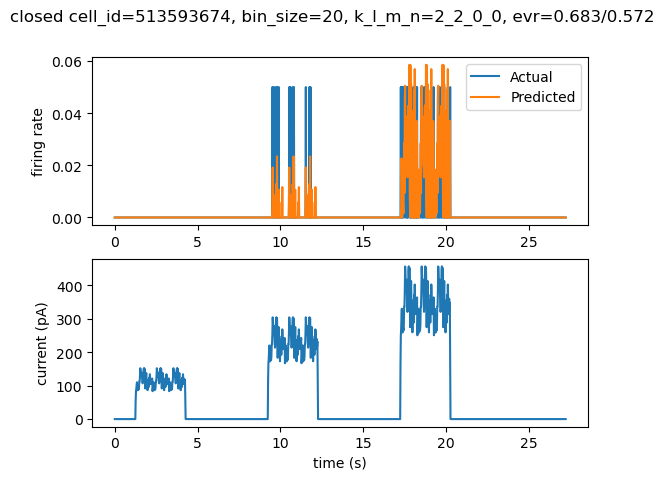

In [82]:
r = explained_variance_ratio(model, Is_te, fs_te, bin_size)
rq = explained_variance_ratio(model, Is_te, fs_te, bin_size, quantize=True)
plot_predictions(model, Is_te[0], fs_te[0], evr=(r, rq))
if save:
    plt.savefig(f"figures/model/{cell_id}/bin_size_{bin_size}/{k}_{l}_{0}_{0}_noise2.png")
    plt.close()

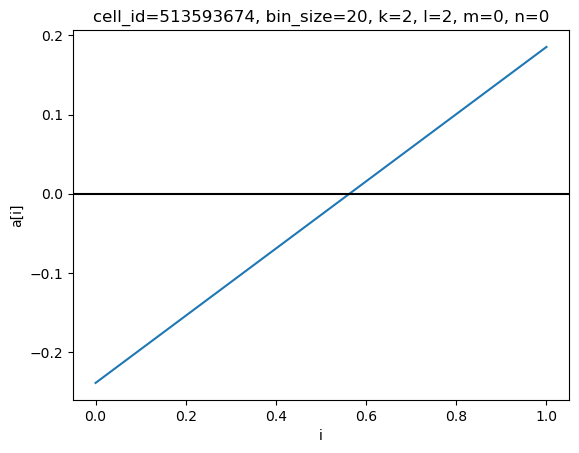

In [83]:
s = len(model.a)
plt.plot(list(range(s)), model.a.tolist()[::-1])
plt.axhline(0, color='black')
plt.xlabel("i")
plt.ylabel("a[i]")
plt.title(f"cell_id={cell_id}, bin_size={bin_size}, k={k}, l={l}, m={0}, n={0}");

Text(0.5, 1.0, 'cell_id=513593674, bin_size=20, k=2, l=2, m=0, n=0')

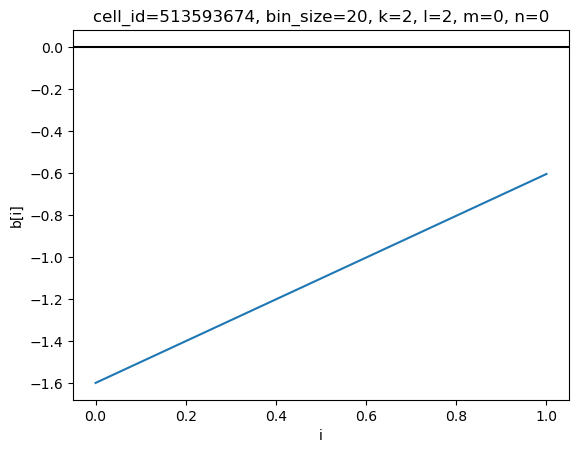

In [84]:
plt.plot(list(range(len(model.b))), model.b.tolist()[::-1])
plt.xlabel("i")
plt.ylabel("b[i]")
plt.axhline(0, color='black')
plt.title(f"cell_id={cell_id}, bin_size={bin_size}, k={k}, l={l}, m={0}, n={0}")